In [67]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
#Functions
def create_year_x(year, days):
    """Makes a list with the days of the dataset with a specific year"""
    List = []
    n_days = len(days)
    for i in range(n_days):
        if (int(days[i][-4:]) == year):
            List.append(days[i])
    return List
def creatematrices(days, data, n_rc):
    """Makes matrices of n_rc x n_rc shape using a list of days and a dataframe"""
    X = []
    n_days = len(days)
    matrix = np.zeros(shape=(n_rc,n_rc))
    n_sum_lat = (max_lat-min_lat)/n_rc
    n_sum_lon = (max_lon-min_lon)/n_rc
    for k in range (n_days):
        dayk = data.loc[(data['Date'] == days[k])]
        matrix_aux = matrix
        start_lon = min_lon
        end_lon = min_lon + n_sum_lon
        for i in range (n_rc):
            start_lat = min_lat
            end_lat = min_lat + n_sum_lat
            for j in range (n_rc):
                x = dayk[(dayk['Latitude'] >= start_lat) & (dayk['Longitude'] >= start_lon) & (dayk['Latitude'] <= end_lat) & (dayk['Longitude'] <= end_lon)]
                matrix_aux[i][j] = len(x)
                start_lat = end_lat
                end_lat += n_sum_lat
            start_lon = end_lon
            end_lon += n_sum_lon
        X.append(matrix_aux)
    return X

def transformToOneArray(Matrices):
    """Makes an array of matrices with the values of a matrix of matrices"""
    X = []
    for i in range(n_years):
        n_matrices_x = len(Matrices[i])
        for j in range(n_matrices_x):
            X.append(Matrices[i][j])
    return X

def createAllDays(year_i, month_i, day_i, year_f, month_f, day_f):
    sdate = date(year_i, month_i, day_i)   # start date
    edate = date(year_f, month_f, day_f)   # end date
    delta = edate - sdate       # as timedelta
    alldays = []
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        alldays.append(day.strftime("%m/%d/%Y"))
    return alldays

def completeMatrices(Matrices2, days, alldays, n_rc):
    n_days = len(days)
    n_alldays = len(alldays)
    X = []
    matrix_aux = np.zeros(shape=(n_rc,n_rc))
    c_aux = 0
    for i in range(n_alldays):
        if (alldays[i] in days):
            X.append(Matrices2[c_aux])
            c_aux += 1
        else:
            X.append(matrix_aux)
    return X

def highestCrimes(Crimesperday,rangetoiter):
    r1 = 0
    r2 = rangetoiter
    sumcrime = sum(Crimesperday[0:rangetoiter])
    for i in range(n_alldays-rangetoiter):
        sum_aux = sum(Crimesperday[i:i+rangetoiter])
        if(sum_aux>sumcrime):
            r1 = i
            r2 = i+rangetoiter
            sumcrime = sum_aux
    return (r1,r2,sumcrime)

def mapofCrimes(namefile, rrc, Matrices):
    rank_matrix = createRankMatrix(rrc,Matrices)
    fig, ax = plt.subplots()
    fig.set_figheight(rrc)
    fig.set_figwidth(rrc)
    ax.matshow(rank_matrix, cmap=plt.cm.Blues)

    for i in range(rrc):
        for j in range(rrc):
            c = rank_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')
    fig.savefig(namefile + '.pdf', bbox_inches='tight')

def createRankMatrix(rrc, Matrices):
    rank_matrix = np.zeros(shape=(rrc,rrc))
    n_matrices = len(Matrices)
    for k in range(n_matrices):
        for i in range(rrc):
            for j in range(rrc):
                rank_matrix[i][j] += Matrices[k][i][j]
    rank_matrix2 = rank_matrix.astype(int)
    return rank_matrix2


def createSet(Matrices,twdays,n_r, n_c):
    X = []
    Y = []
    n_matrix = len(Matrices)
    for i in range(n_matrix):
        if (i>=n_matrix-twdays):
            for j in range(twdays):
                X.append(Matrices[i])
            Y.append(Matrices[i])
        else:
            for j in range(twdays):
                X.append(Matrices[i + j])
            Y.append(Matrices[i+twdays])
    return (X, Y)
            
def createTrainingTest(Matrices,percentage, twdays, n_r, n_c):
    division = round(len(Matrices) * percentage)
    training = Matrices[:division]
    test = Matrices[division:]
    X_training, Y_training = createSet(training,twdays, n_r, n_c)
    X_test, Y_test = createSet(test,twdays, n_r, n_c)
    X_training = np.array(X_training).reshape(-1,twdays,n_r,n_c,1)
    Y_training = np.array(Y_training).reshape(-1,(n_r*n_c))
    X_test = np.array(X_test).reshape(-1,twdays,n_r,n_c,1)
    Y_test = np.array(Y_test).reshape(-1,(n_r*n_c))
    return (X_training, Y_training, X_test, Y_test)

def distanceInKm(max_lat, min_lat, max_lon, min_lon, n_rc):
    n_sum_lat = (max_lat-min_lat)/n_rc
    n_sum_lon = (max_lon-min_lon)/n_rc
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(min_lat)
    lon1 = radians(min_lon)
    lat2 = radians(min_lat + n_sum_lat)
    lon2 = radians(min_lon + n_sum_lon)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return (R*c)

data = https://catalog.data.gov/dataset/crimes-2001-to-present-398a4

In [5]:
data = pd.read_csv("Crimes_-_2001_to_present.csv")
data.dropna(inplace=True)
data = data.loc[(data['Primary Type'] == "THEFT")]
data["Date"] = data["Date"].str[:10]
days = np.unique(data["Date"].values).tolist()
days.sort(key = lambda date: datetime.strptime(date, "%m/%d/%Y"))
alldays = createAllDays(2001,1,1 ,2019,12,31)
data = data[data.Latitude != 36.619446395]
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,8,9,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ID Case Number        Date                  Block  IUCR  \
62615  11622422    JC183696  03/12/2019        008XX E 38TH PL  0820   
63349  11661997    JC228271  04/17/2019   034XX W ARMITAGE AVE  0820   
63381  11662440    JC231024  04/18/2019  026XX W FULLERTON AVE  0820   
63489  11663358    JC232931  04/21/2019  052XX N NASHVILLE AVE  0810   
63553  11667017    JC237342  04/25/2019    016XX N WESTERN AVE  0820   

      Primary Type     Description            Location Description Arrest  \
62615        THEFT  $500 AND UNDER   RESIDENTIAL YARD (FRONT/BACK)  False   
63349        THEFT  $500 AND UNDER  PARKING LOT/GARAGE(NON.RESID.)  False   
63381        THEFT  $500 AND UNDER                          STREET  False   
63489        THEFT       OVER $500                RESIDENCE-GARAGE  False   
63553        THEFT  $500 AND UNDER                       CTA TRAIN  False   

      Domestic  ...  Ward  Community Area  FBI Code  X Coordinate  \
62615    False  ...   4.0            36.0        06     1182276.0   
63349    False  ...  26.0            22.0        06     1153253.0   
63381    False  ...   1.0            22.0        06     1158218.0   
63489    False  ...  45.0            10.0        06     1131583.0   
63553    False  ...   1.0            24.0        06     1160111.0   

      Y Coordinate    Year              Updated On   Latitude Longitude  \
62615    1879784.0  2019.0  08/17/2019 03:57:45 PM  41.825347  -87.6068   
63349    1913079.0  2019.0  08/17/2019 03:57:45 PM  41.917336  -87.7124   
63381    1915850.0  2019.0  08/17/2019 03:57:45 PM  41.924840  -87.6941   
63489    1934489.0  2019.0  08/17/2019 03:57:45 PM  41.976491  -87.7915   
63553    1910846.0  2019.0  08/17/2019 03:57:45 PM  41.911070  -87.6872   

                            Location  
62615  (41.825346902, -87.606780575)  
63349  (41.917336159, -87.712375085)  
63381   (41.924839894, -87.69405765)  
63489  (41.976490526, -87.791494995)  
63553  (41.911069617, -87.687240439)  

[5 rows x 22 columns]

In [69]:
max_lat = data['Latitude'].max()
min_lat = data['Latitude'].min()
max_lon = data['Longitude'].max()
min_lon = data['Longitude'].min()
print(min_lat,max_lat,min_lon,max_lon)

kms32 = distanceInKm(max_lat, min_lat, max_lon, min_lon, 32)
kms64 = distanceInKm(max_lat, min_lat, max_lon, min_lon, 64)
print("Kms in 64x64 =",kms64)
print("Kms in 32x32 =",kms32)

41.644589713 42.022671246 -87.934272688 -87.524529465
Kms in 64x64 = 0.845536953076732
Kms in 32x32 = 1.691043194619929


In [7]:
years = list(map(int, data.Year.unique().tolist()))
years.sort()
n_years = len(years)
listDates = [[] for x in range(n_years)]
dataPartitioned = [[] for x in range(n_years)]

for i in range(n_years):
    listDates[i] = create_year_x(years[i], days)
    dataPartitioned[i] = data.loc[data['Year'] == years[i]]

In [6]:
Matrices = [[] for x in range(n_years)]
for i in range(n_years):
    Matrices[i] = creatematrices(listDates[i], dataPartitioned[i], 32)

In [7]:
import pickle
pickle_out = open("Matrices1-19_32x32.pickle","wb")
pickle.dump(Matrices,pickle_out)
pickle_out.close()

In [6]:
import pickle
pickle_in = open("Matrices1-19_32x32.pickle","rb")
Matrices = pickle.load(pickle_in)

In [17]:
import pickle
pickle_out = open("Matrices1-19.pickle","wb")
pickle.dump(Matrices,pickle_out)
pickle_out.close()

In [8]:
import pickle
pickle_in = open("Matrices1-19.pickle","rb")
Matrices = pickle.load(pickle_in)

In [9]:
Matrices2 = transformToOneArray(Matrices)
Matrices3 = completeMatrices(Matrices2, days, alldays, 64)

In [8]:
import pickle
pickle_out = open("Matrices3.pickle","wb")
pickle.dump(Matrices3,pickle_out)
pickle_out.close()

In [10]:
Crimesperday = []
n_days = len(days)
n_alldays = len(alldays)
n_rc = 32
len(Matrices3)
for i in range(n_alldays):
    sumcrime = 0
    for j in range(n_rc):
        for k in range(n_rc):
            sumcrime += Matrices3[i][j][k]
    Crimesperday.append(sumcrime)

In [11]:
#Select the matrices from 2015 to 2019
fromy = (365*4)+1
for i in range(n_alldays):
    if (alldays[i]==days[-1]):
        toy = i

In [88]:
Matrices3 = Matrices3[fromy:toy]

In [23]:
print(len(Matrices3),len(alldays[fromy:toy]))

5429 5429


In [24]:
r1, r2, sumcrime = highestCrimes(Crimesperday,1000)
print(r1,r2,sumcrime, alldays[r1], alldays[r2])

5574 6574 134020.0 04/06/2016 01/01/2019


In [34]:
#Con dos días anteriores
X1_training, Y1_training, X1_test, Y1_test = createTrainingTest(Matrices3, 0.7, 2, 64, 64)
print(X1_training.shape)
print(Y1_training.shape)
print(X1_test.shape)
print(Y1_test.shape)

(4857, 2, 64, 64, 1)
(4857, 4096)
(2082, 2, 64, 64, 1)
(2082, 4096)


In [35]:
#Con siete días anteriores
X2_training, Y2_training, X2_test, Y2_test = createTrainingTest(Matrices3, 0.7, 7, 64, 64)
print(X2_training.shape)
print(Y2_training.shape)
print(X2_test.shape)
print(Y2_test.shape)

(4857, 7, 64, 64, 1)
(4857, 4096)
(2082, 7, 64, 64, 1)
(2082, 4096)


In [13]:
#Con 15 días anteriores
X3_training, Y3_training, X3_test, Y3_test = createTrainingTest(Matrices3, 0.7, 15, 64, 64)

In [25]:
#Con 15 días anteriores
X3_training, Y3_training, X3_test, Y3_test = createTrainingTest(Matrices3, 0.7, 15, 32, 32)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


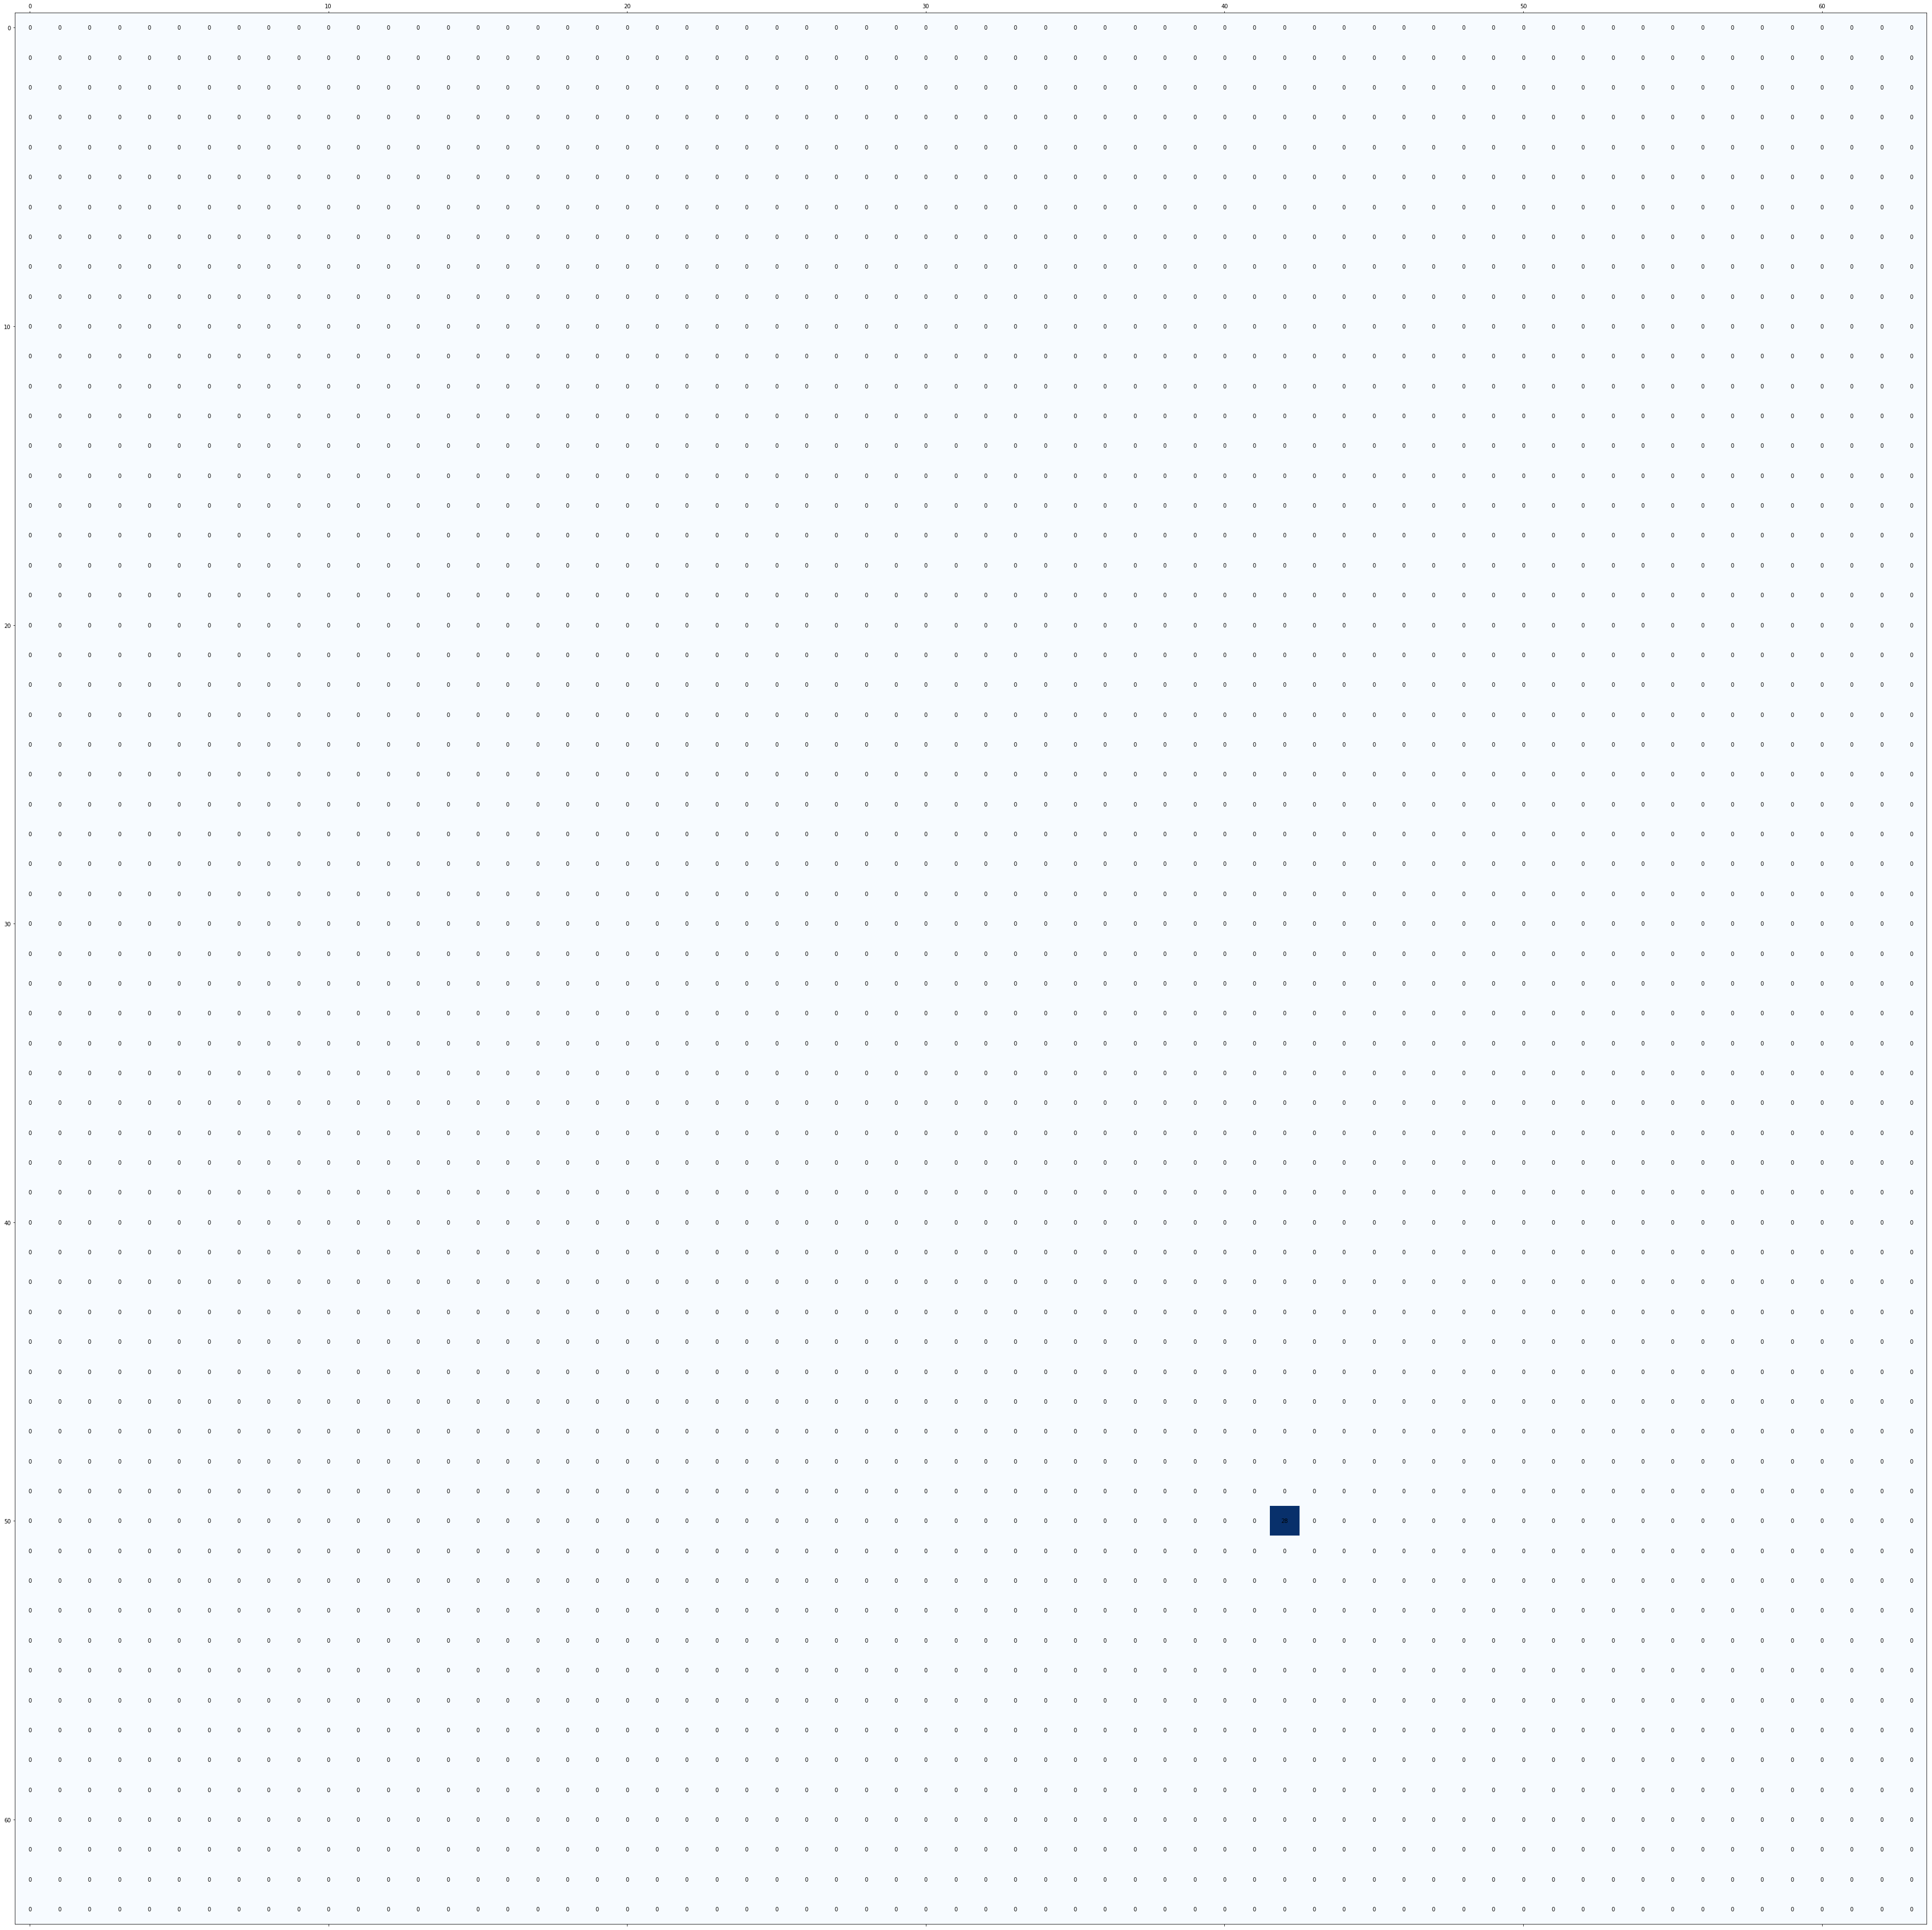

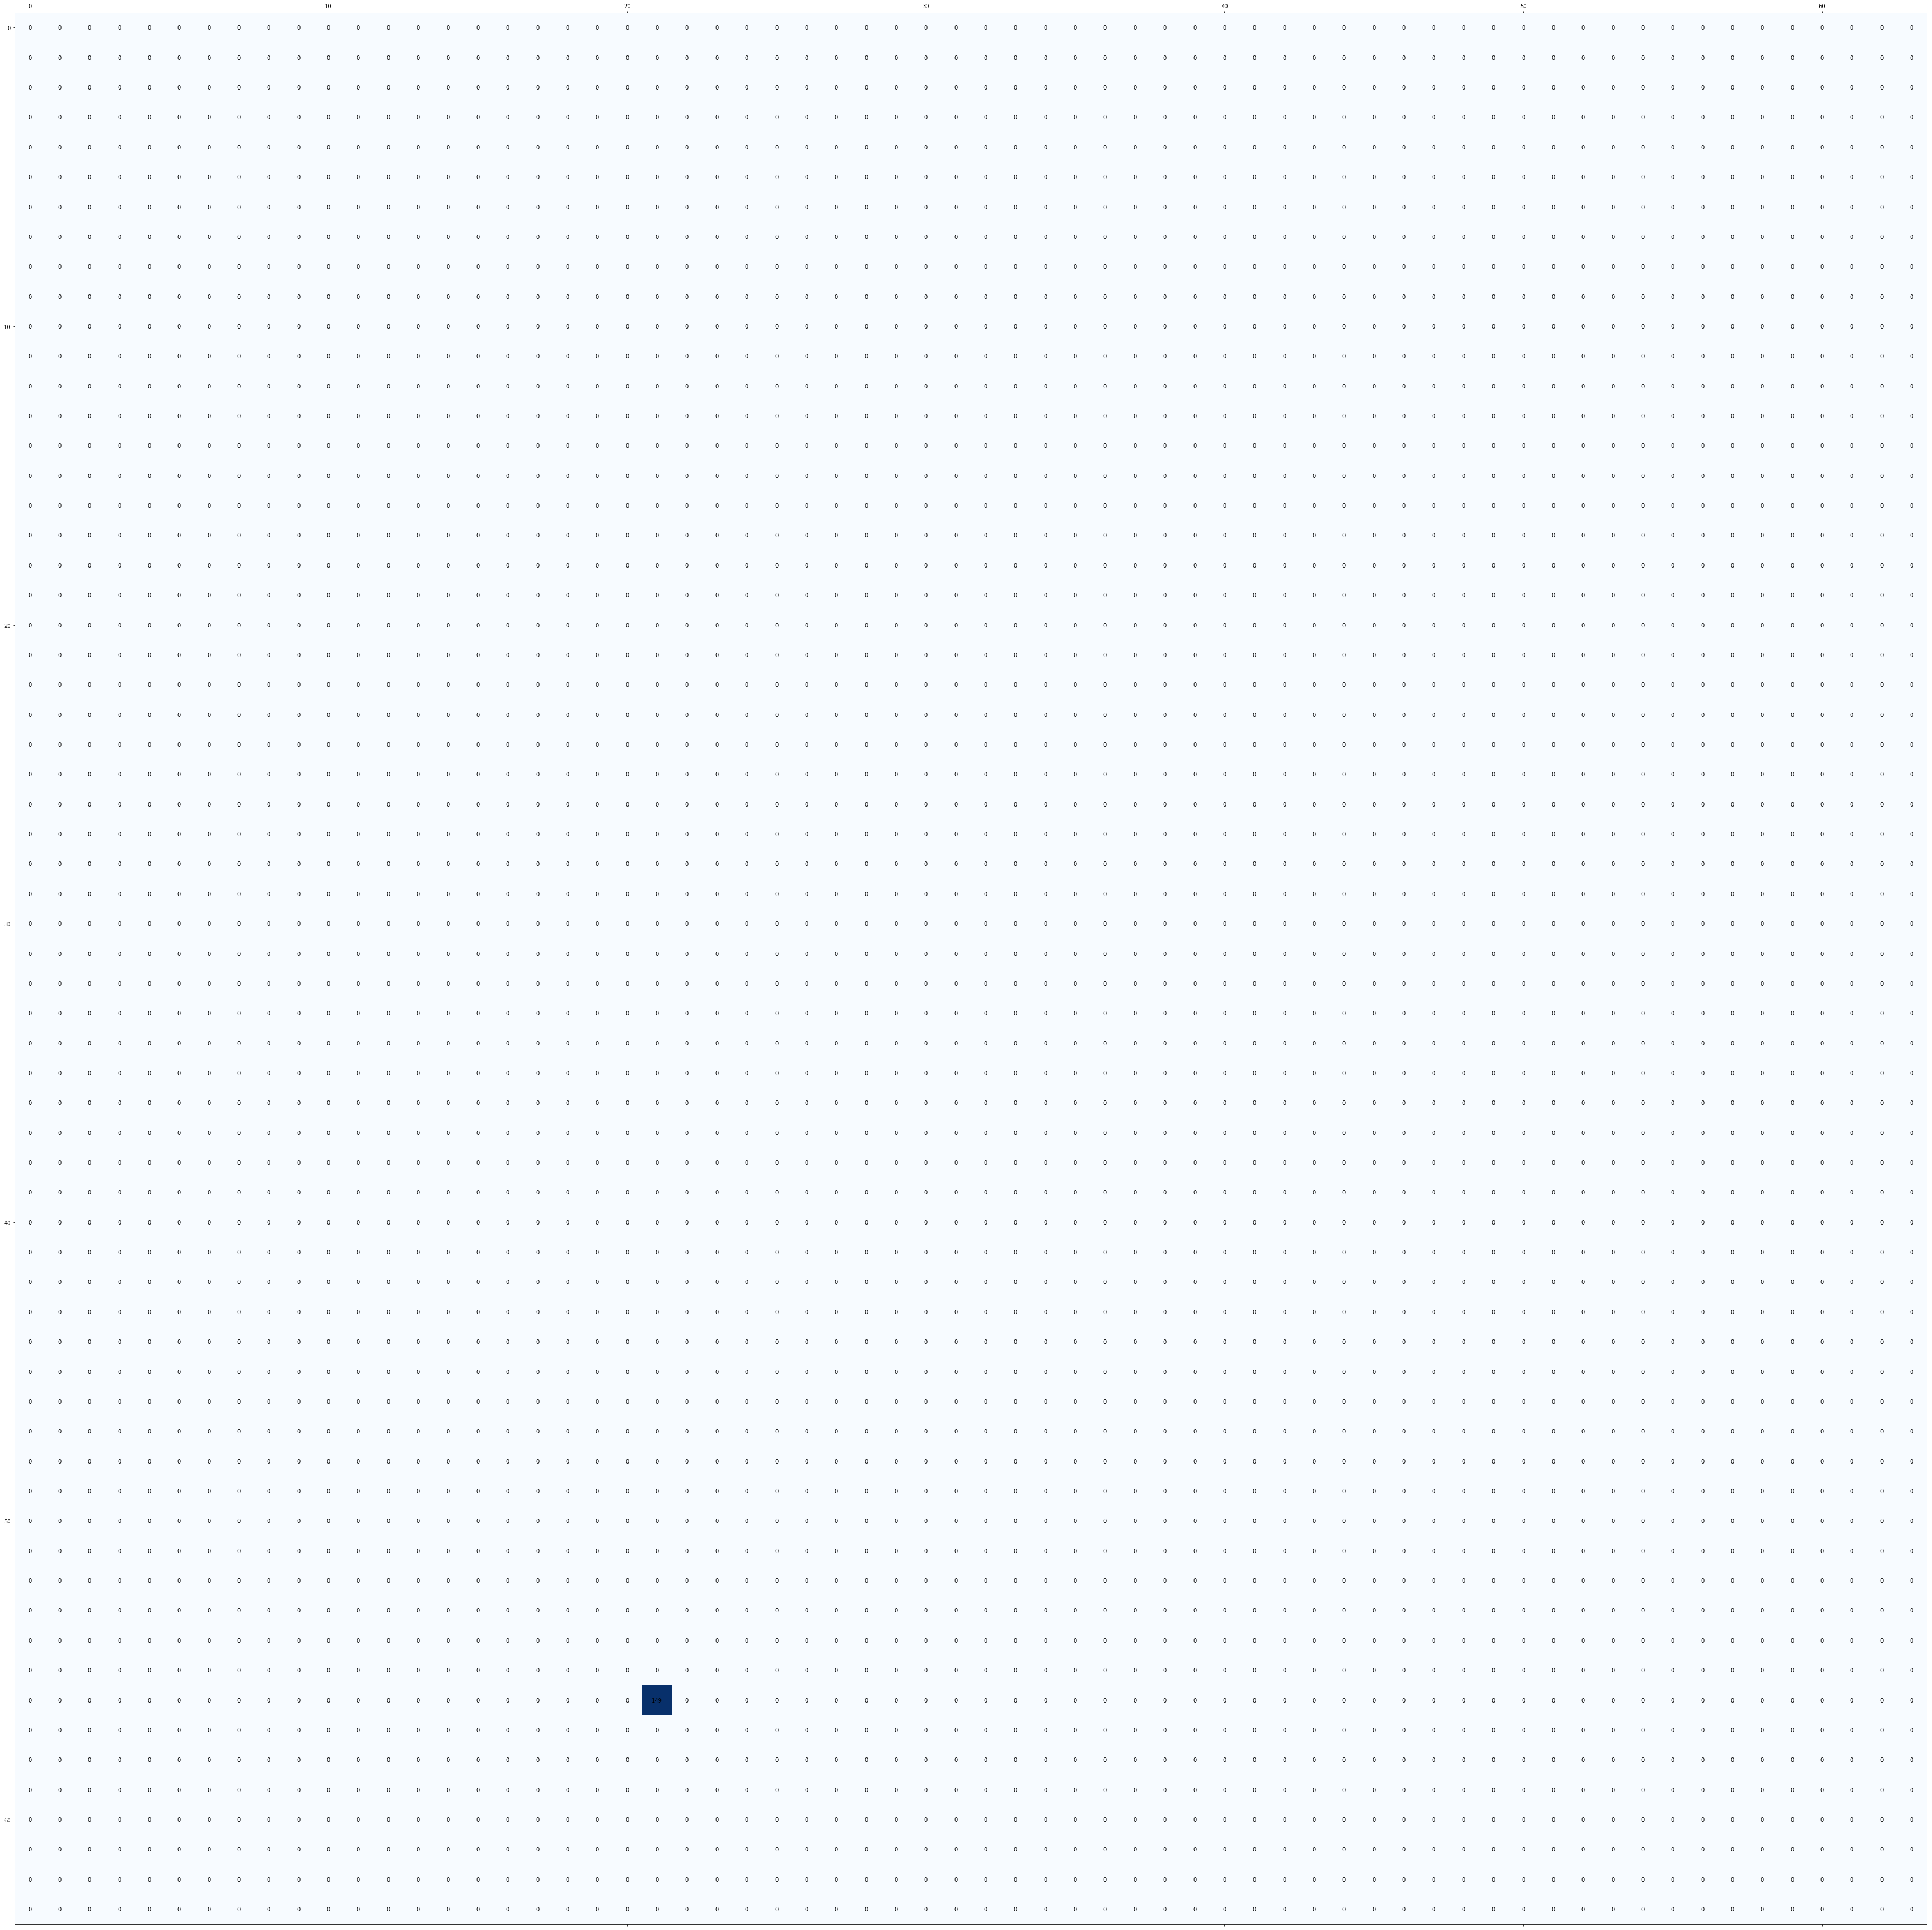

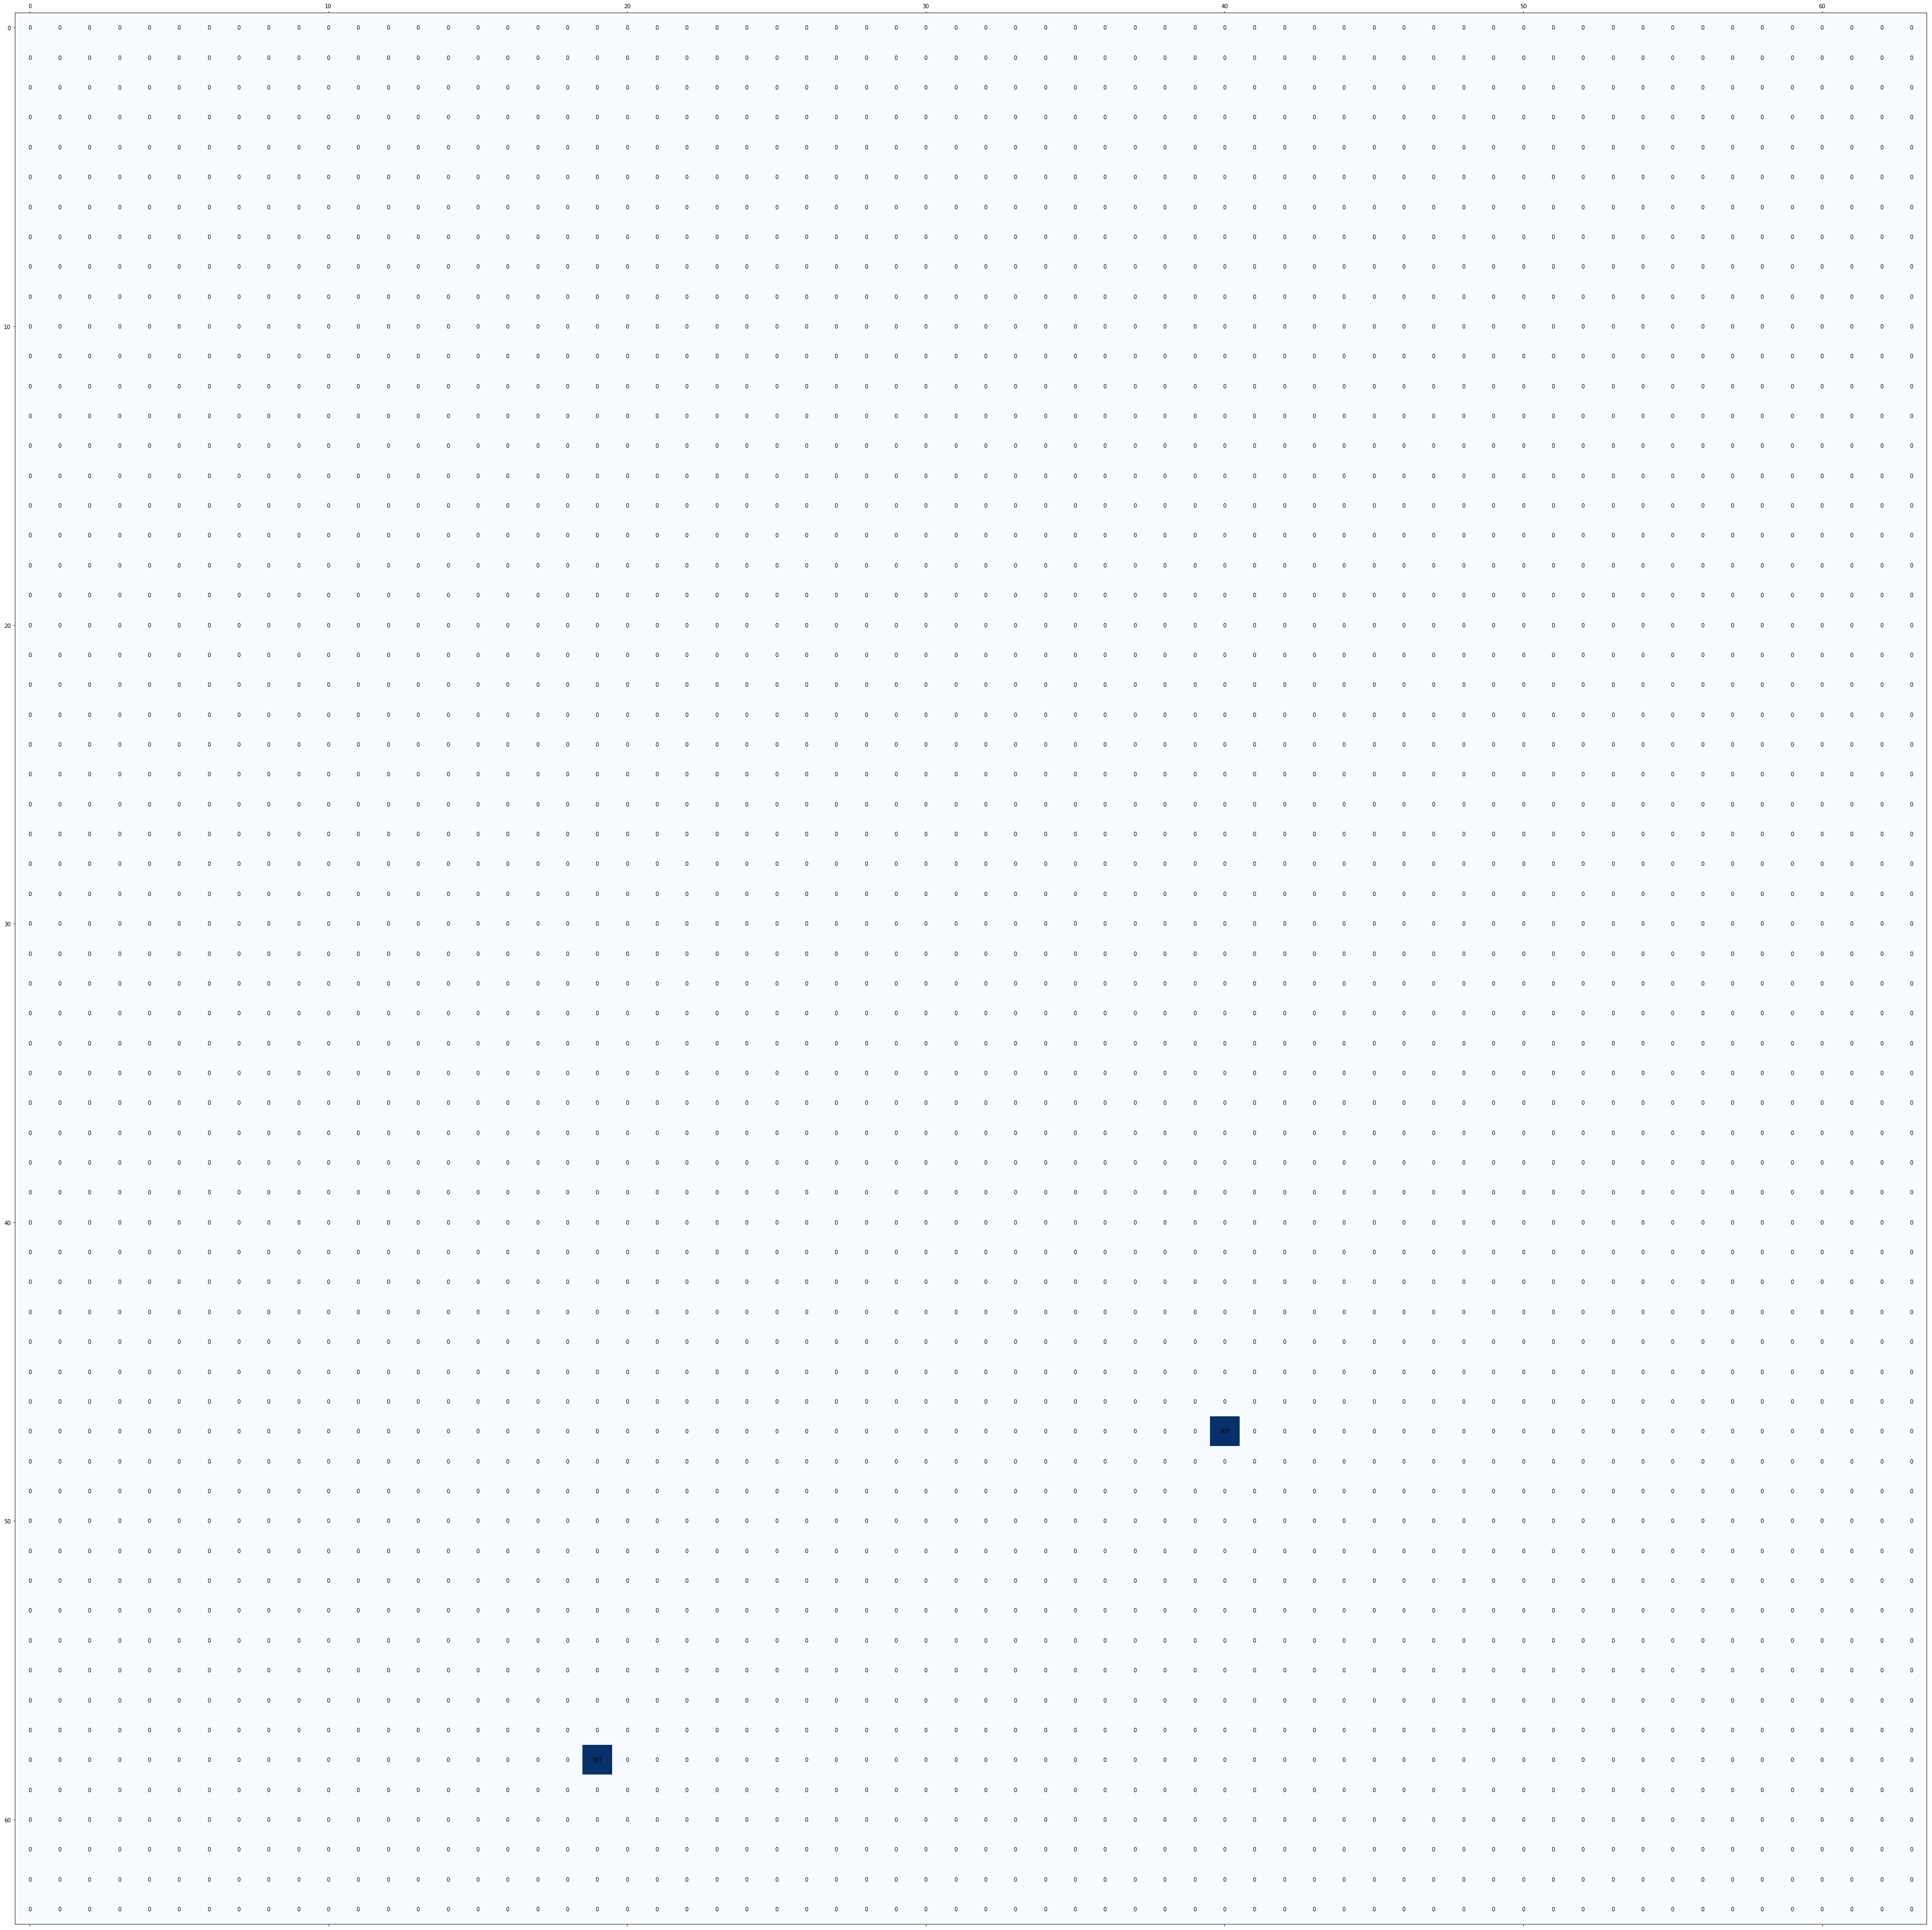

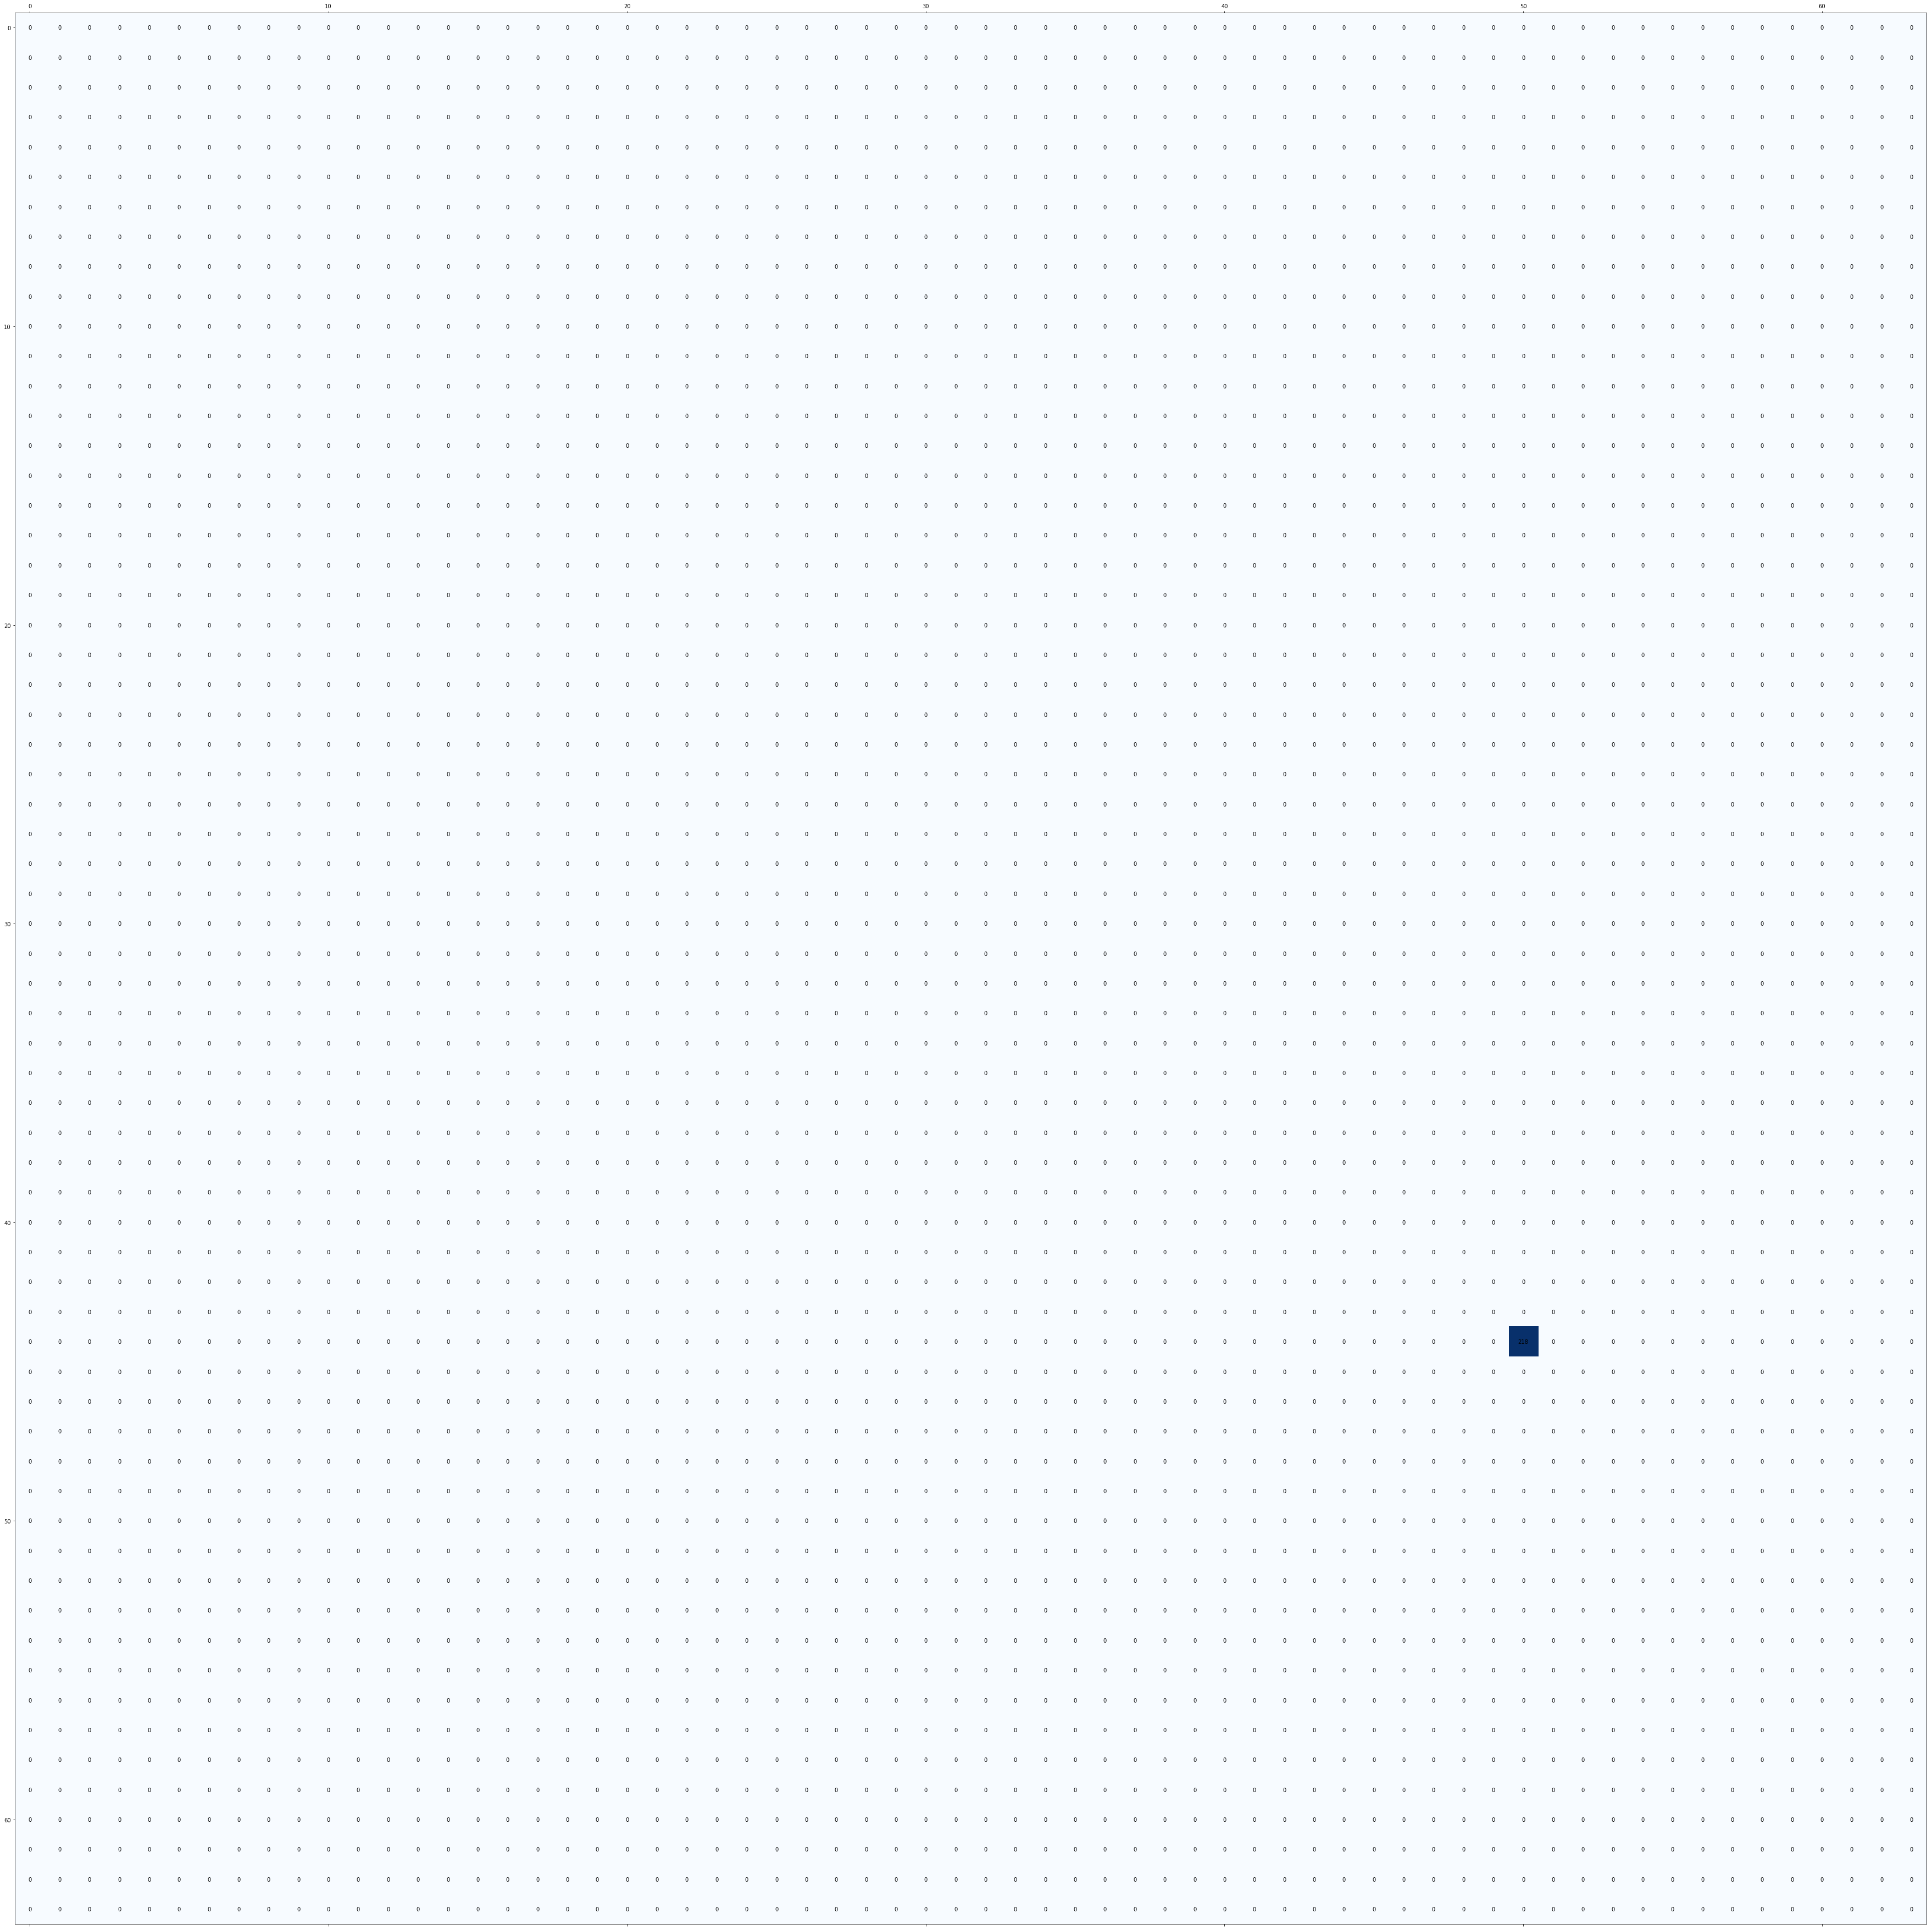

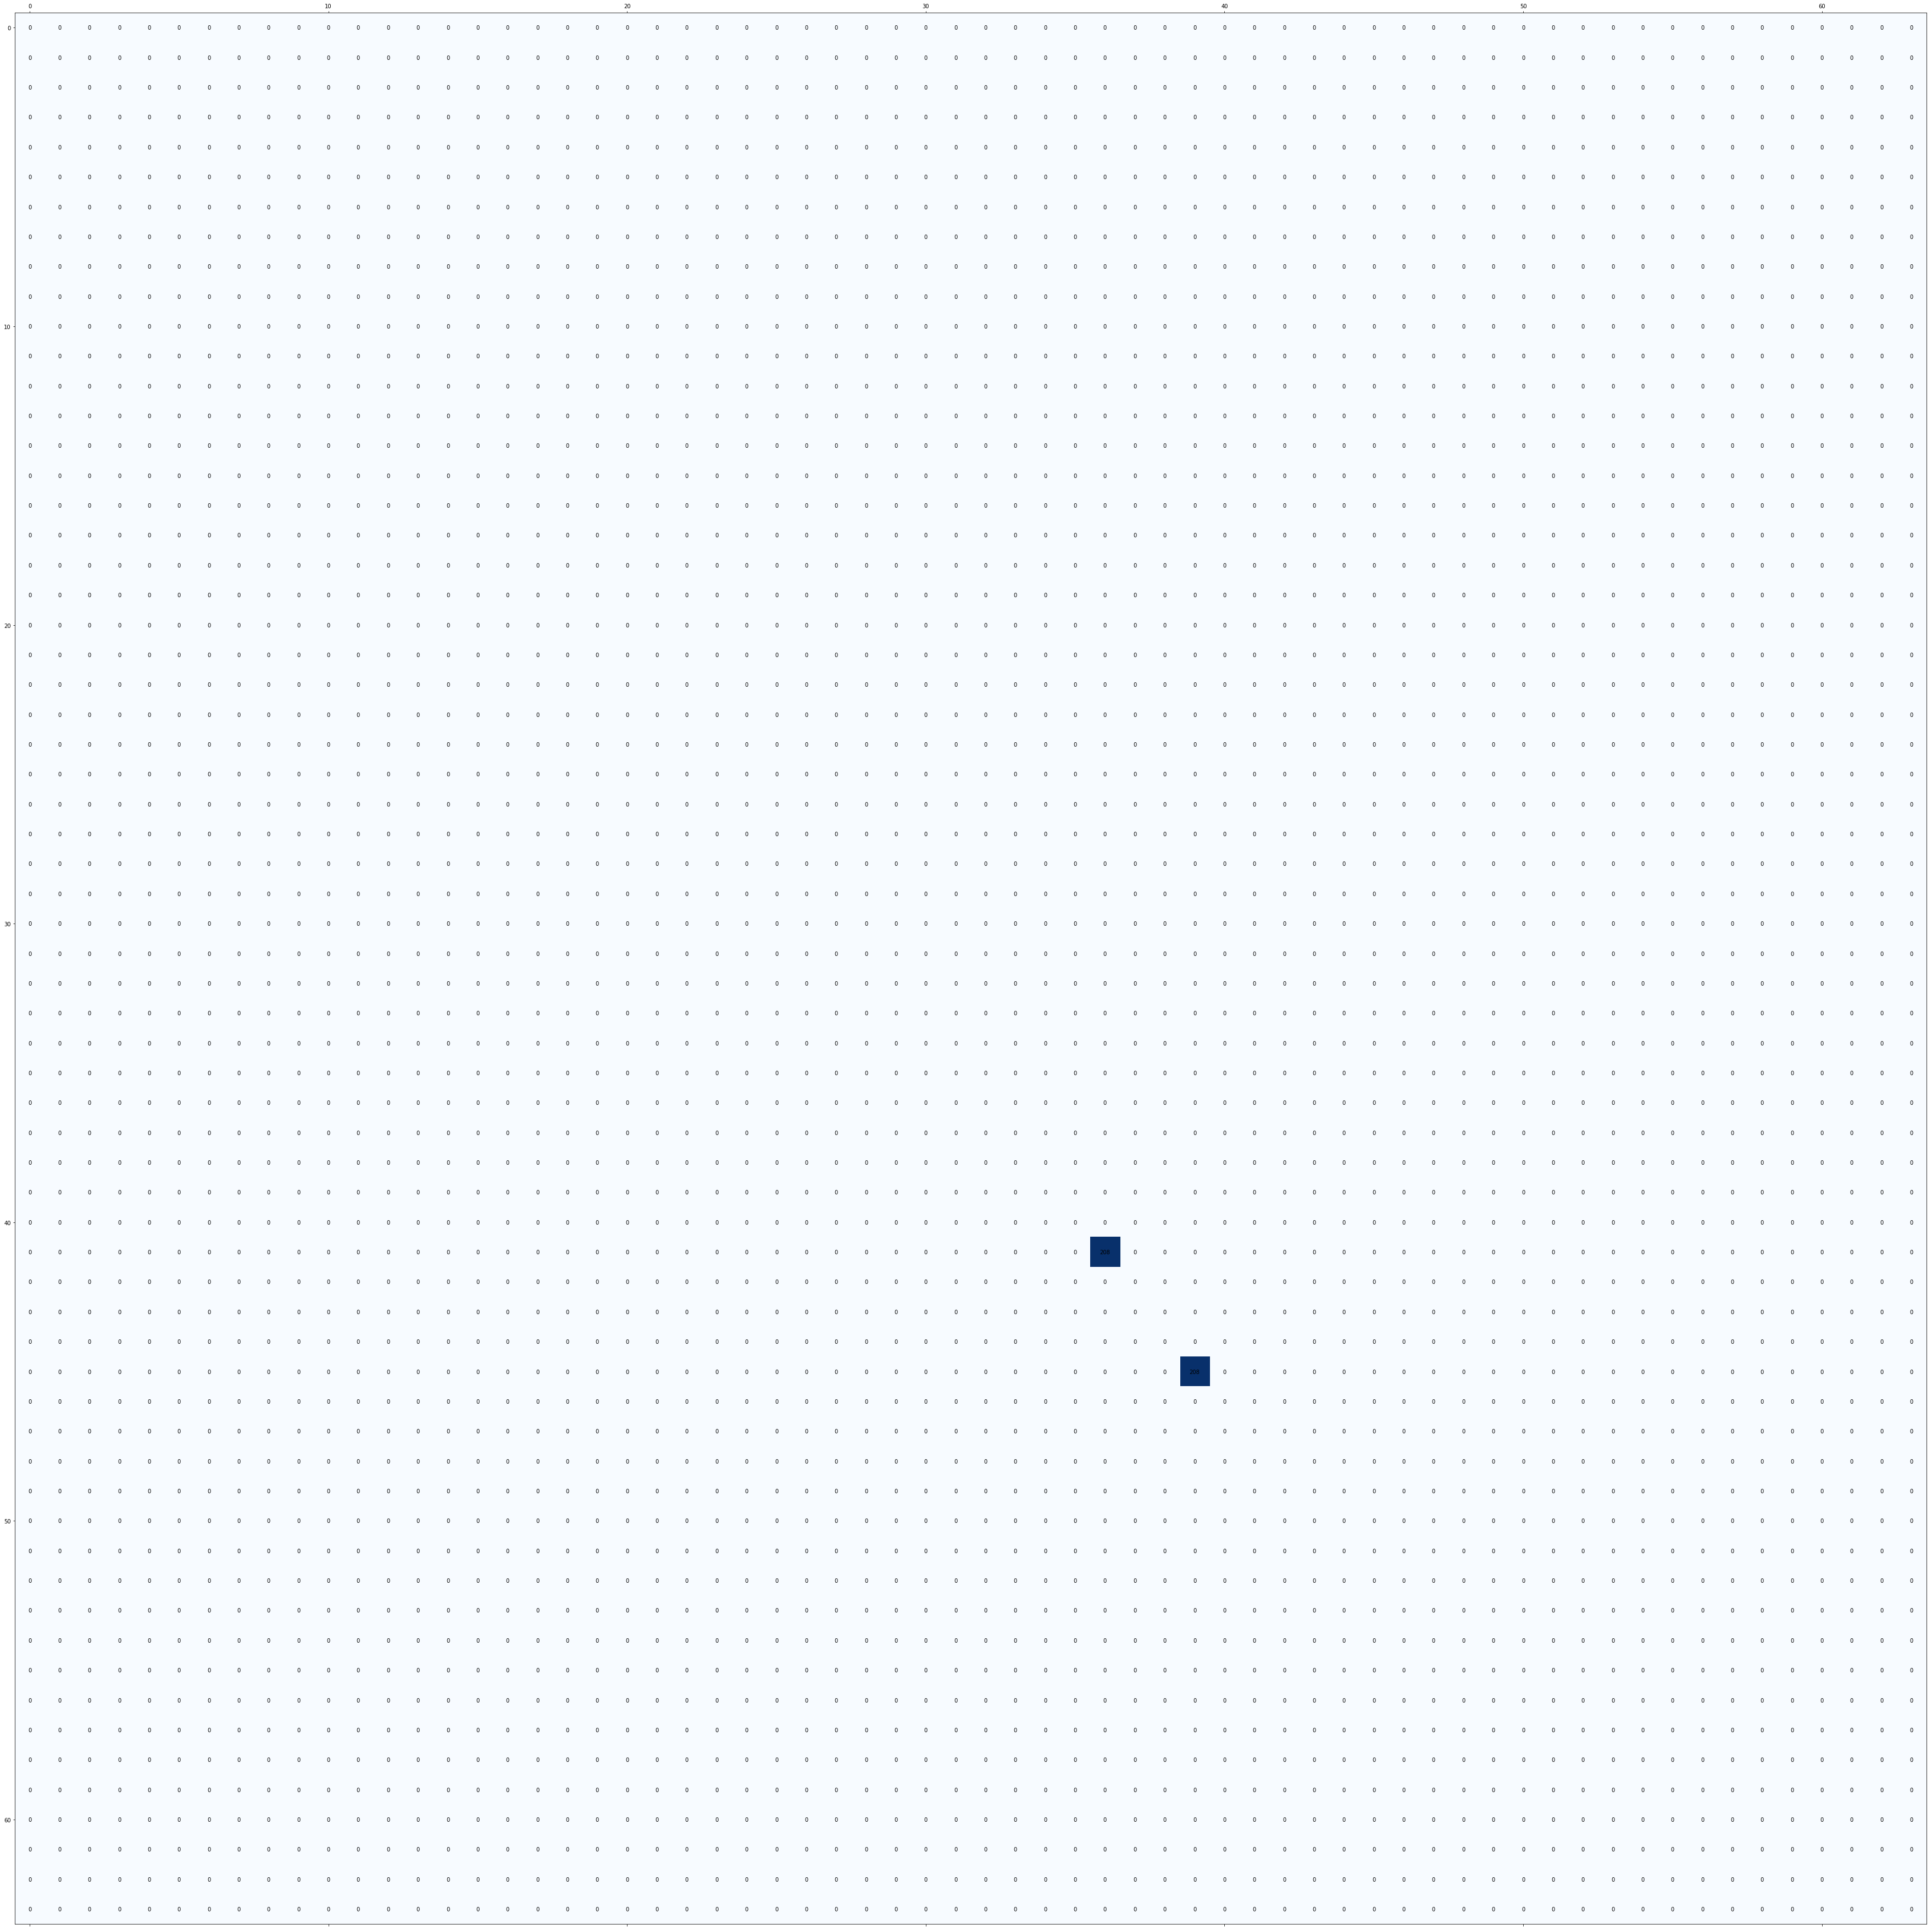

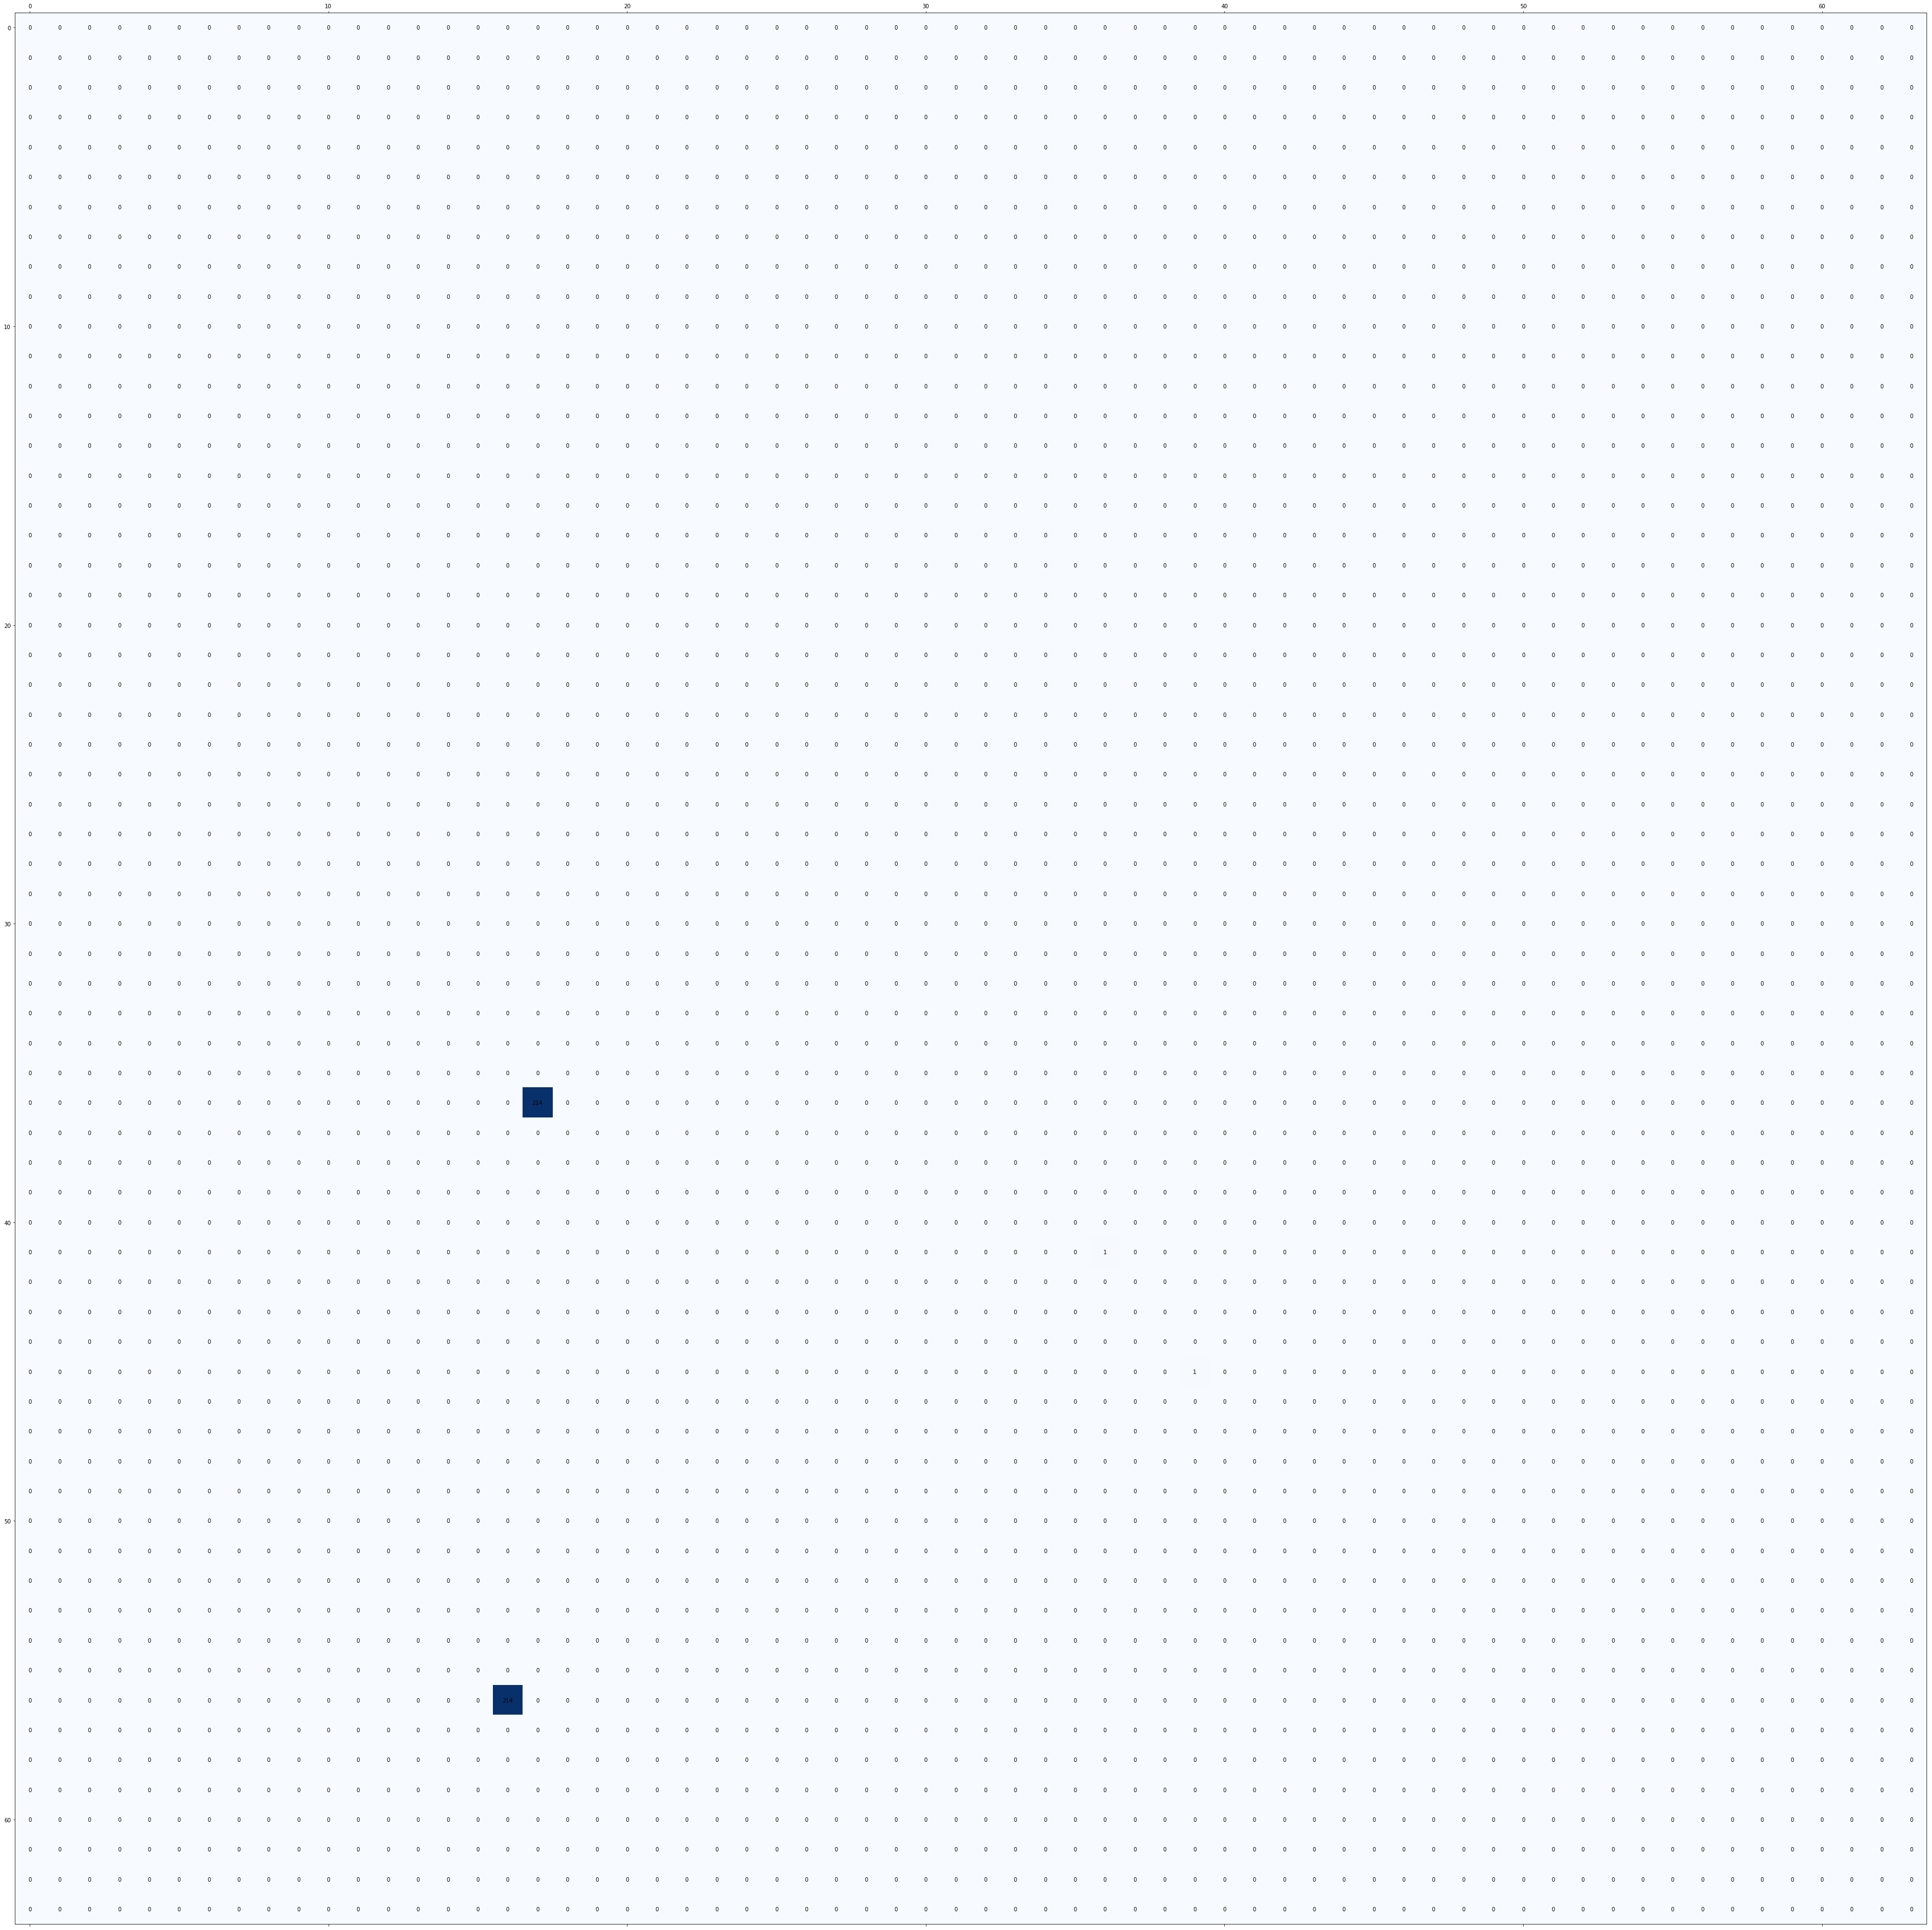

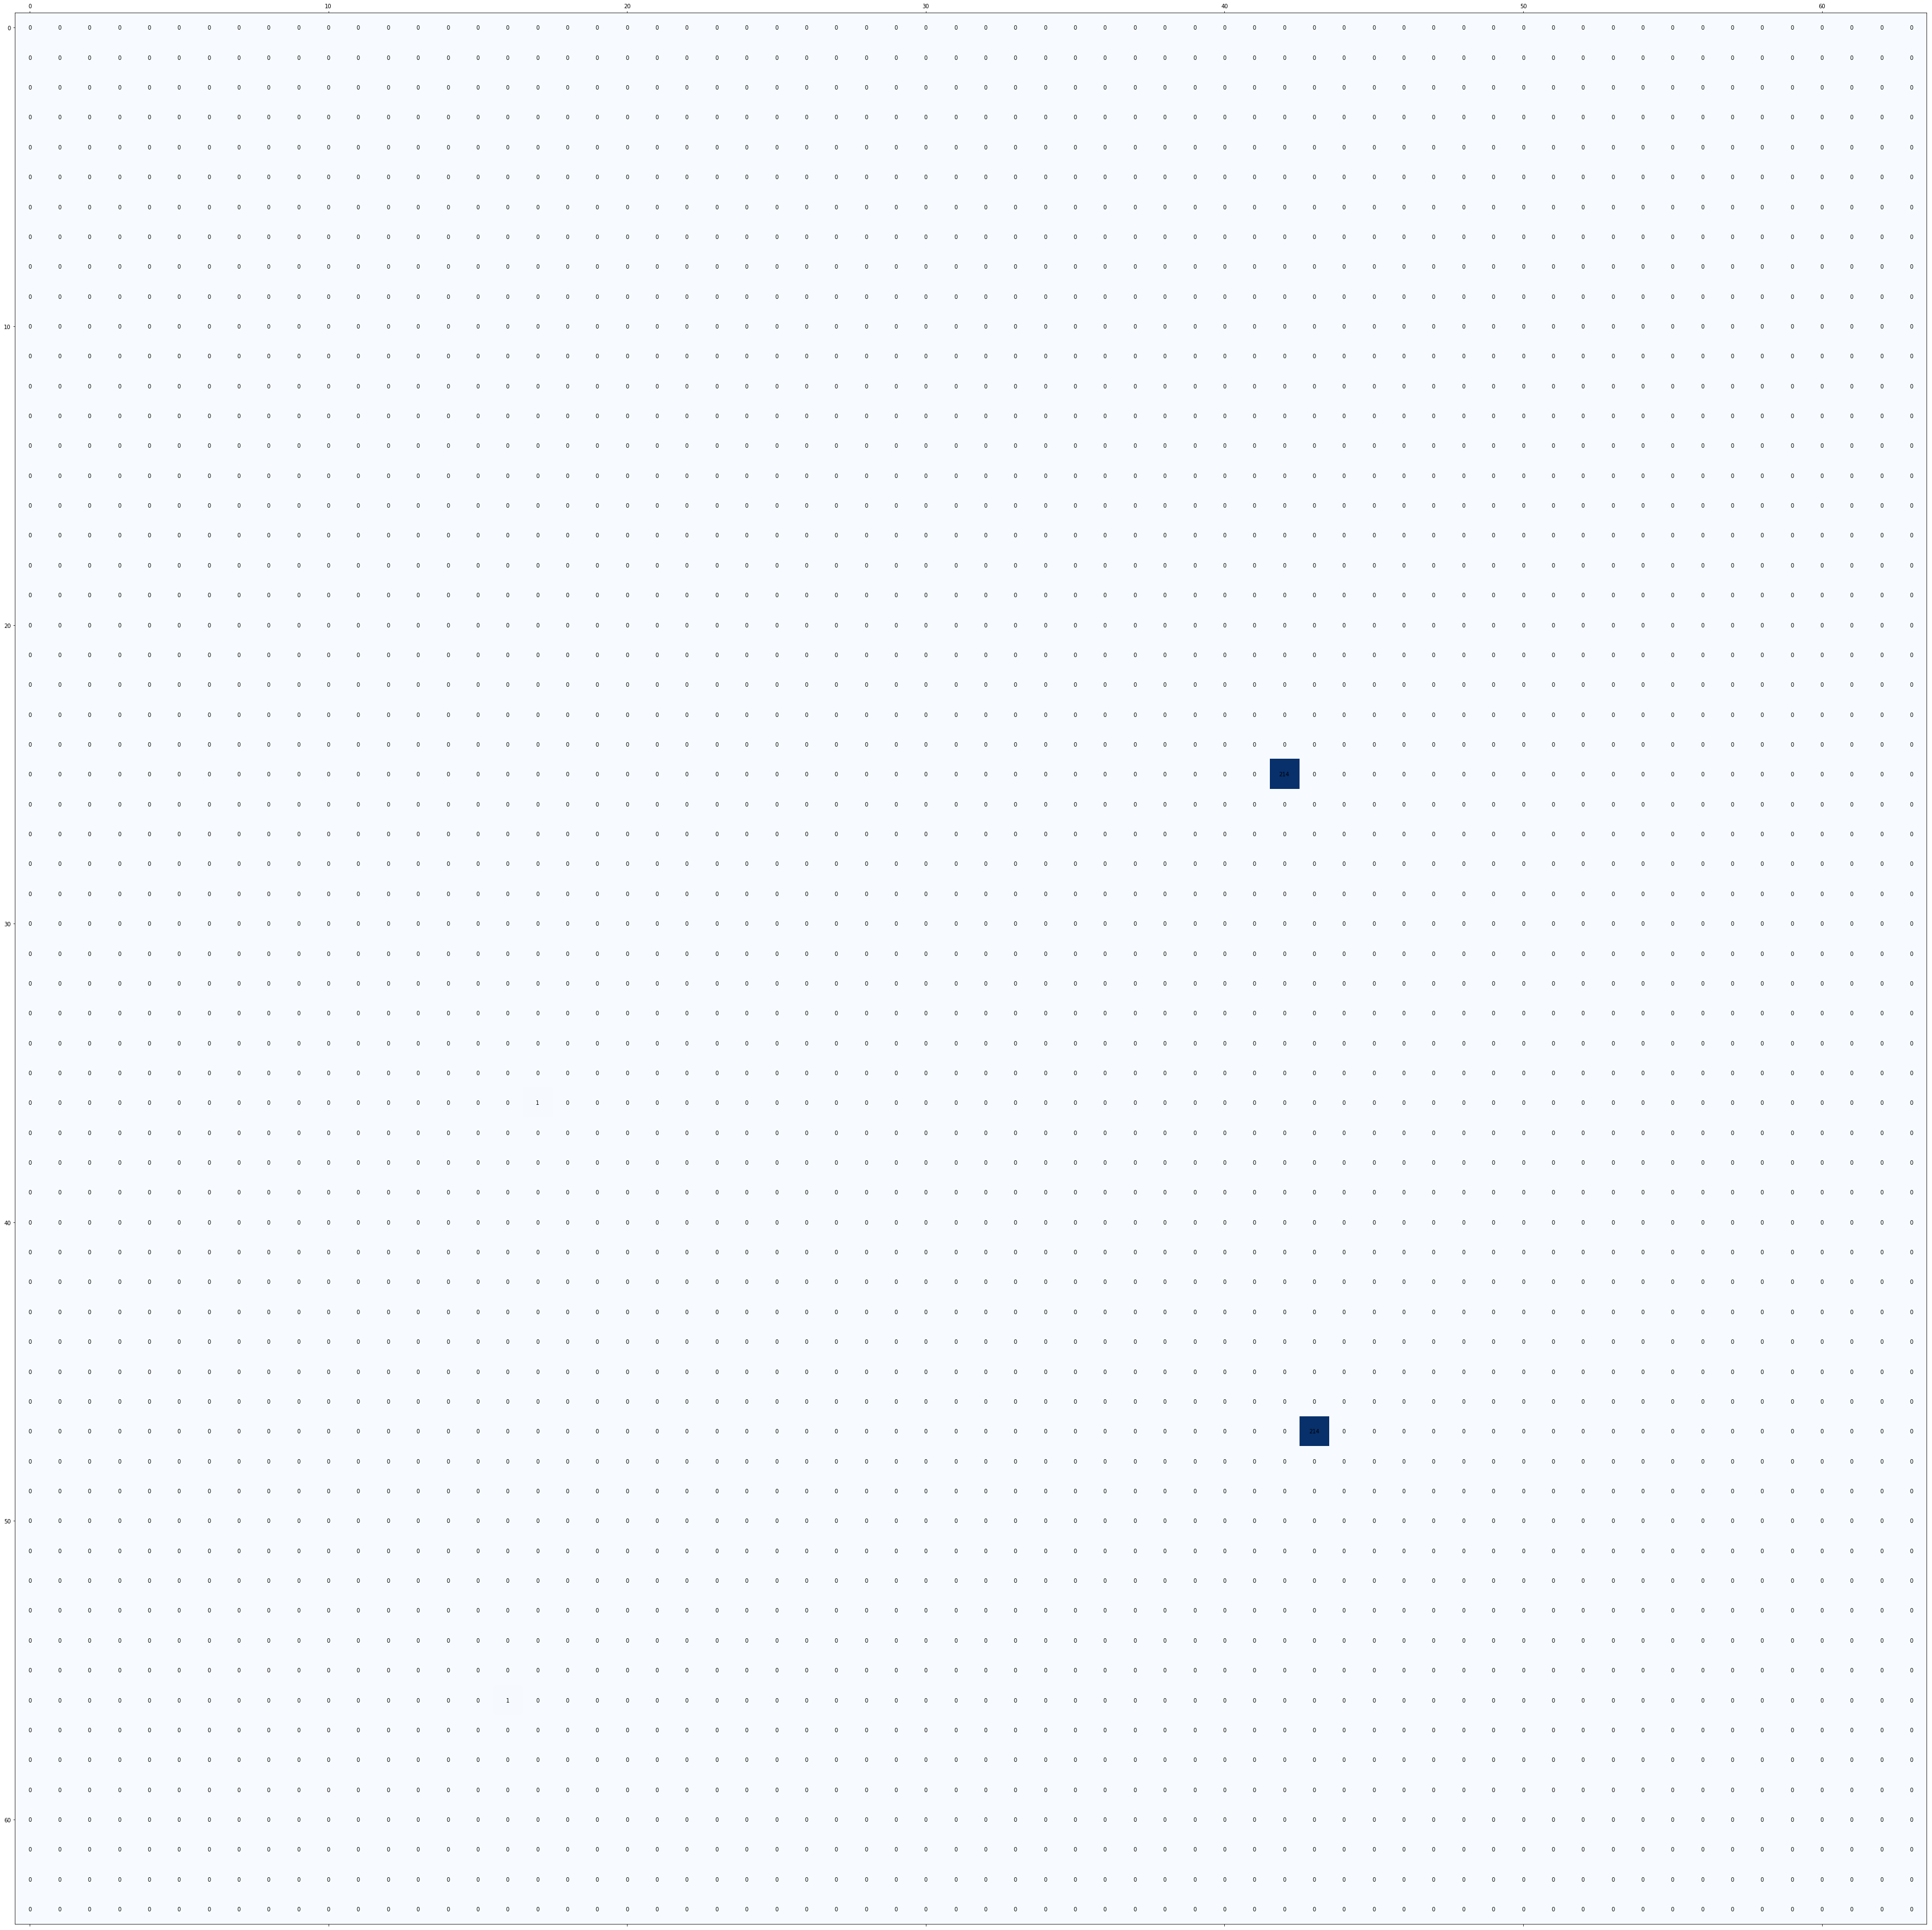

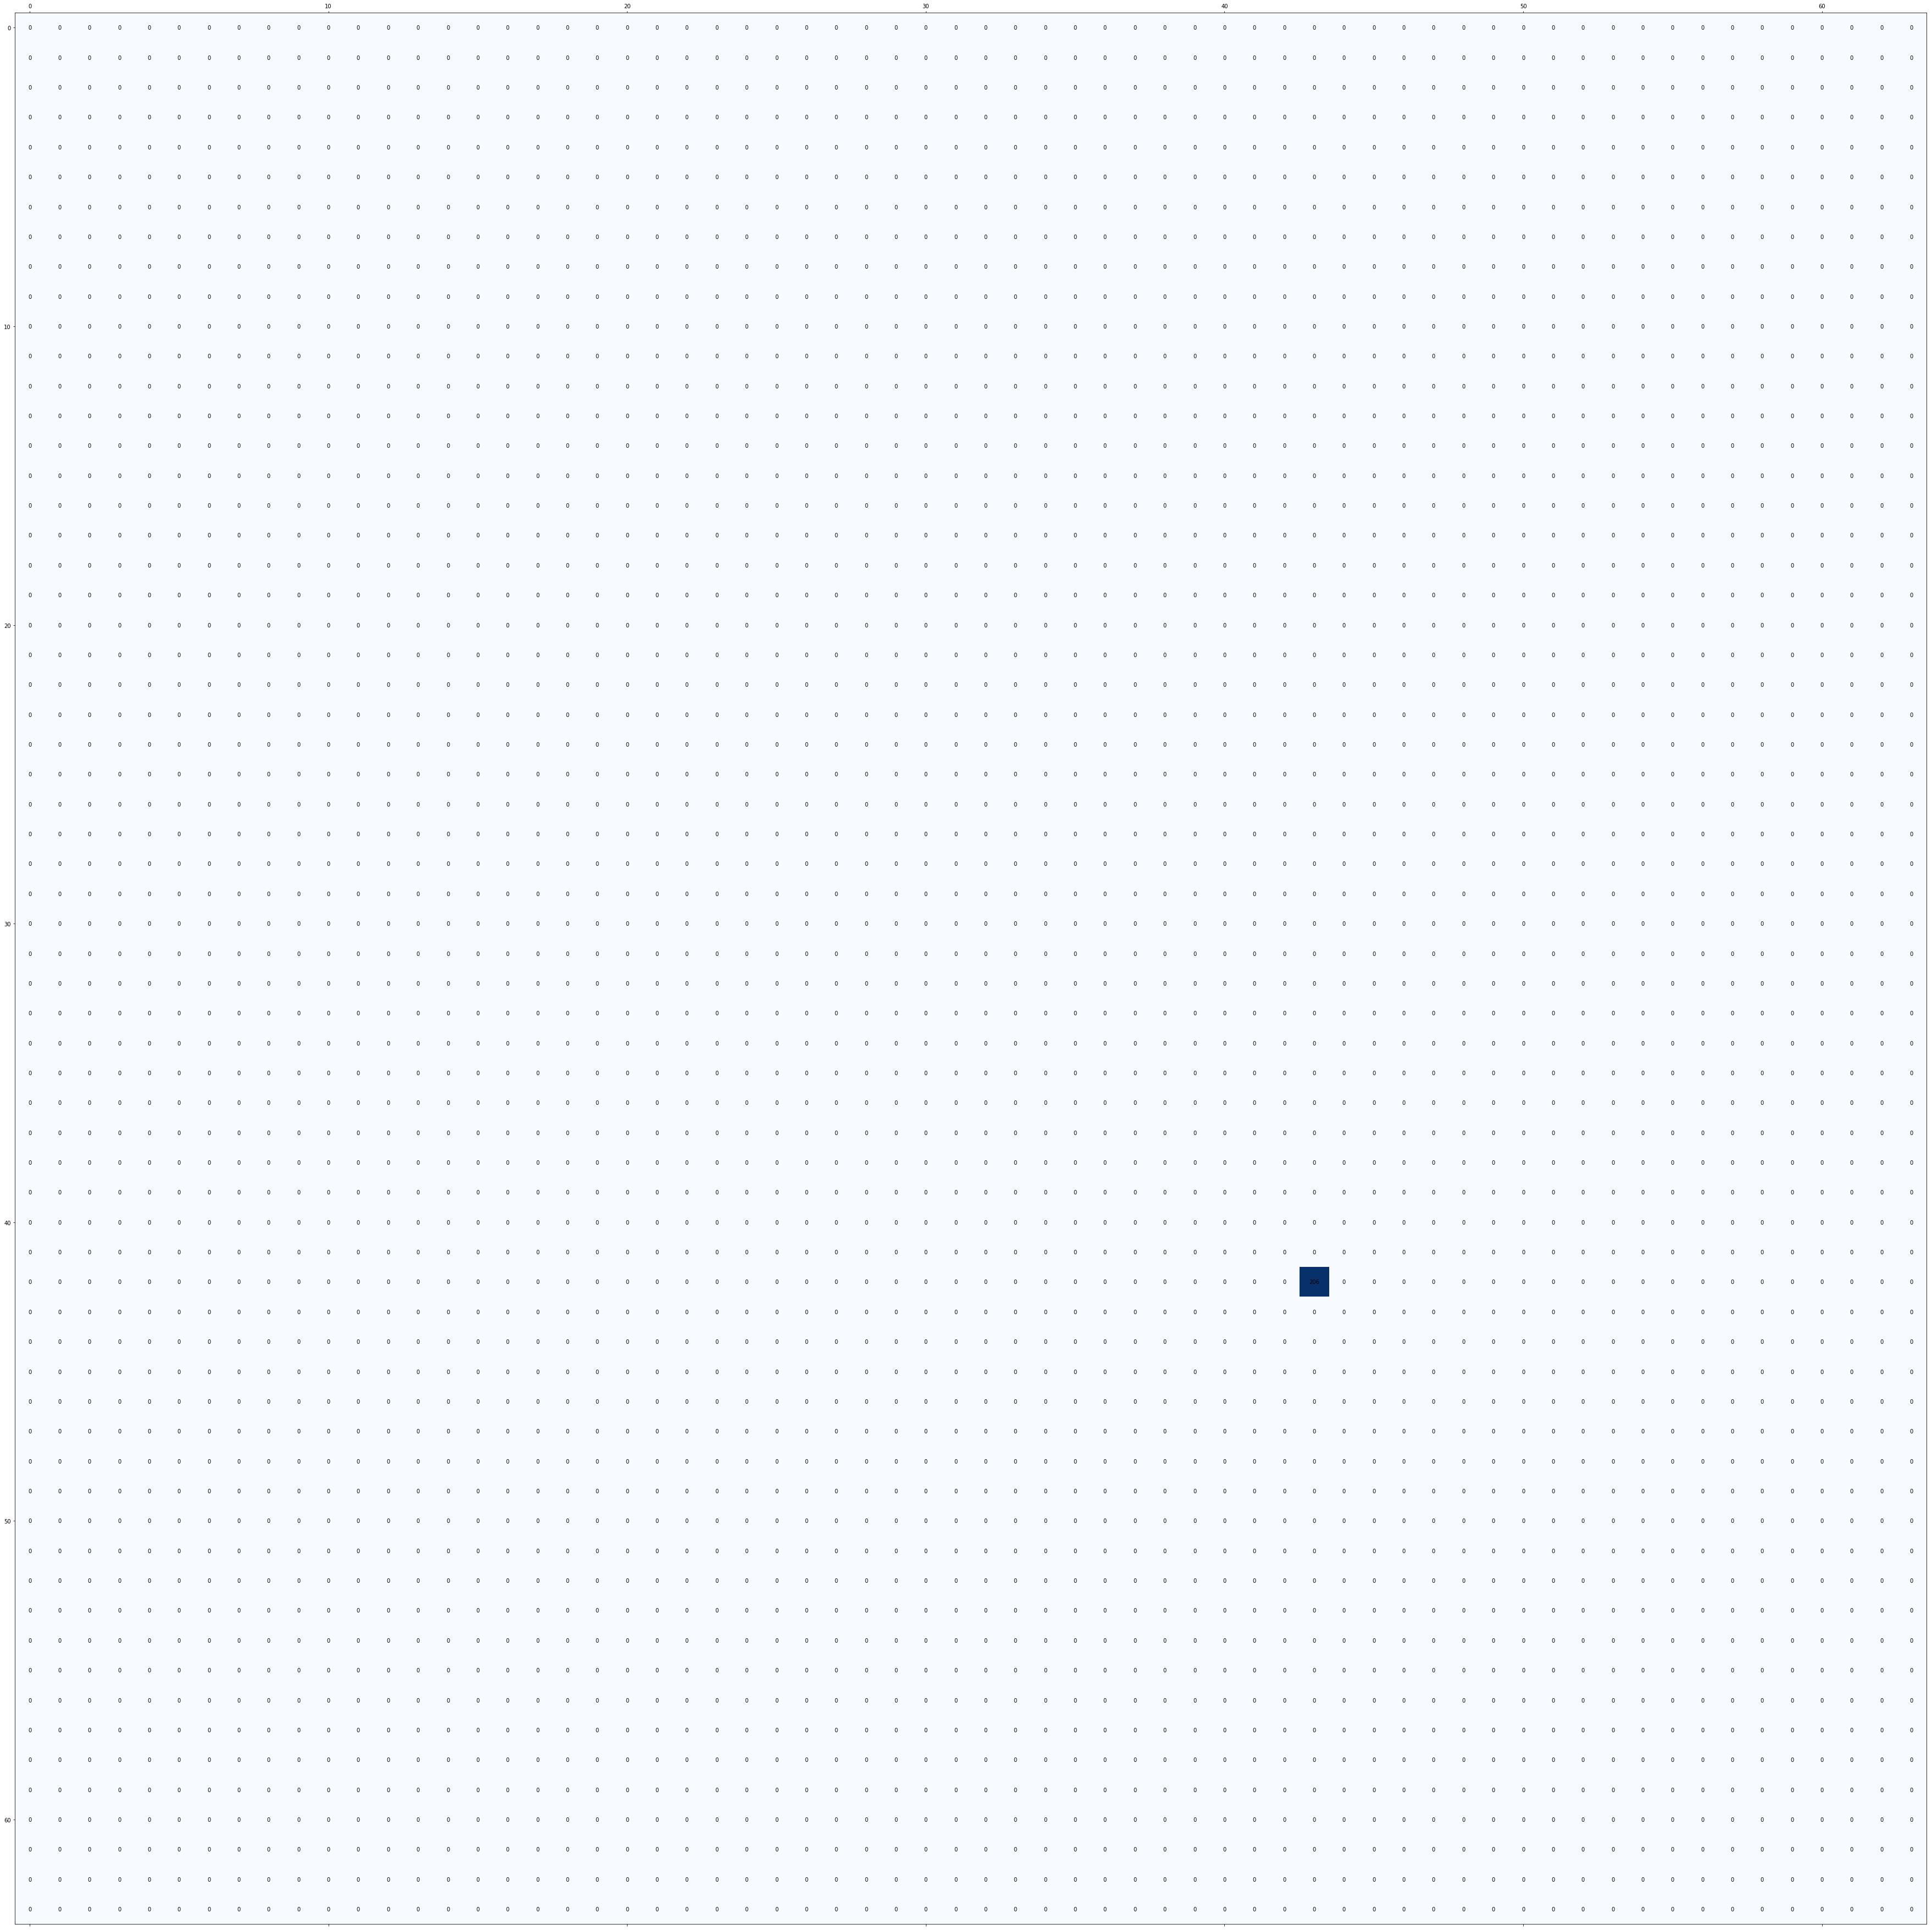

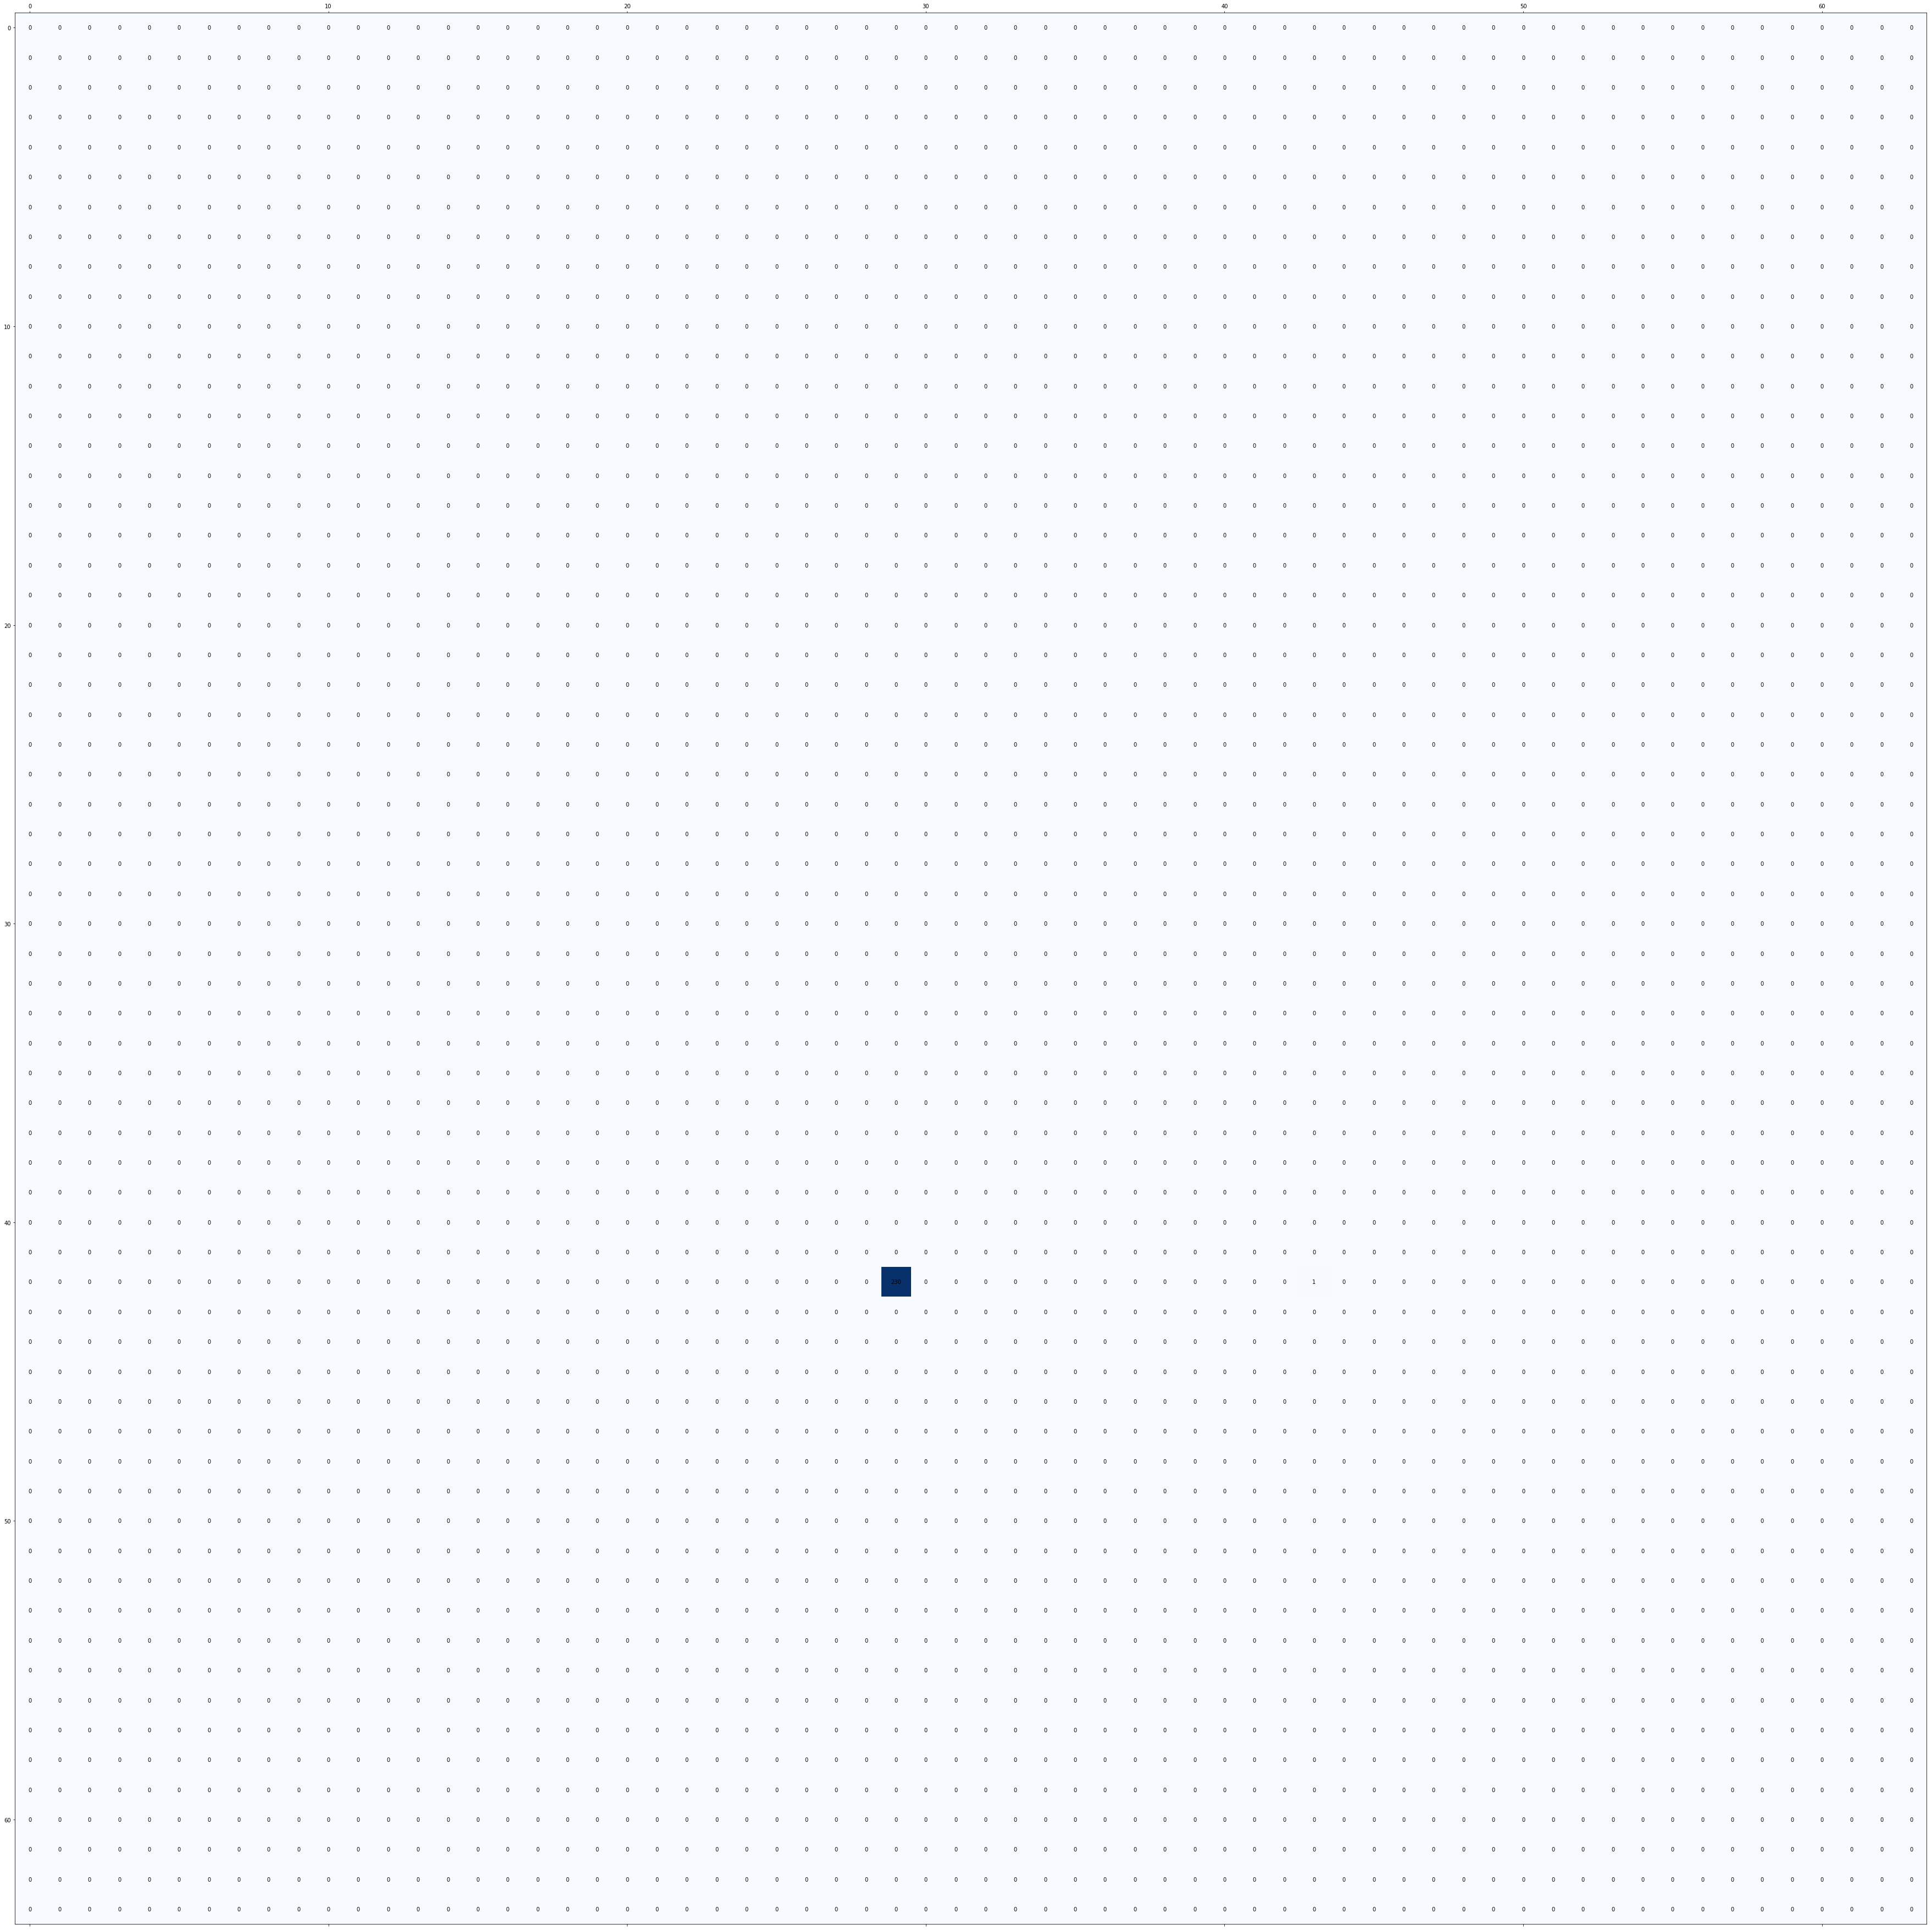

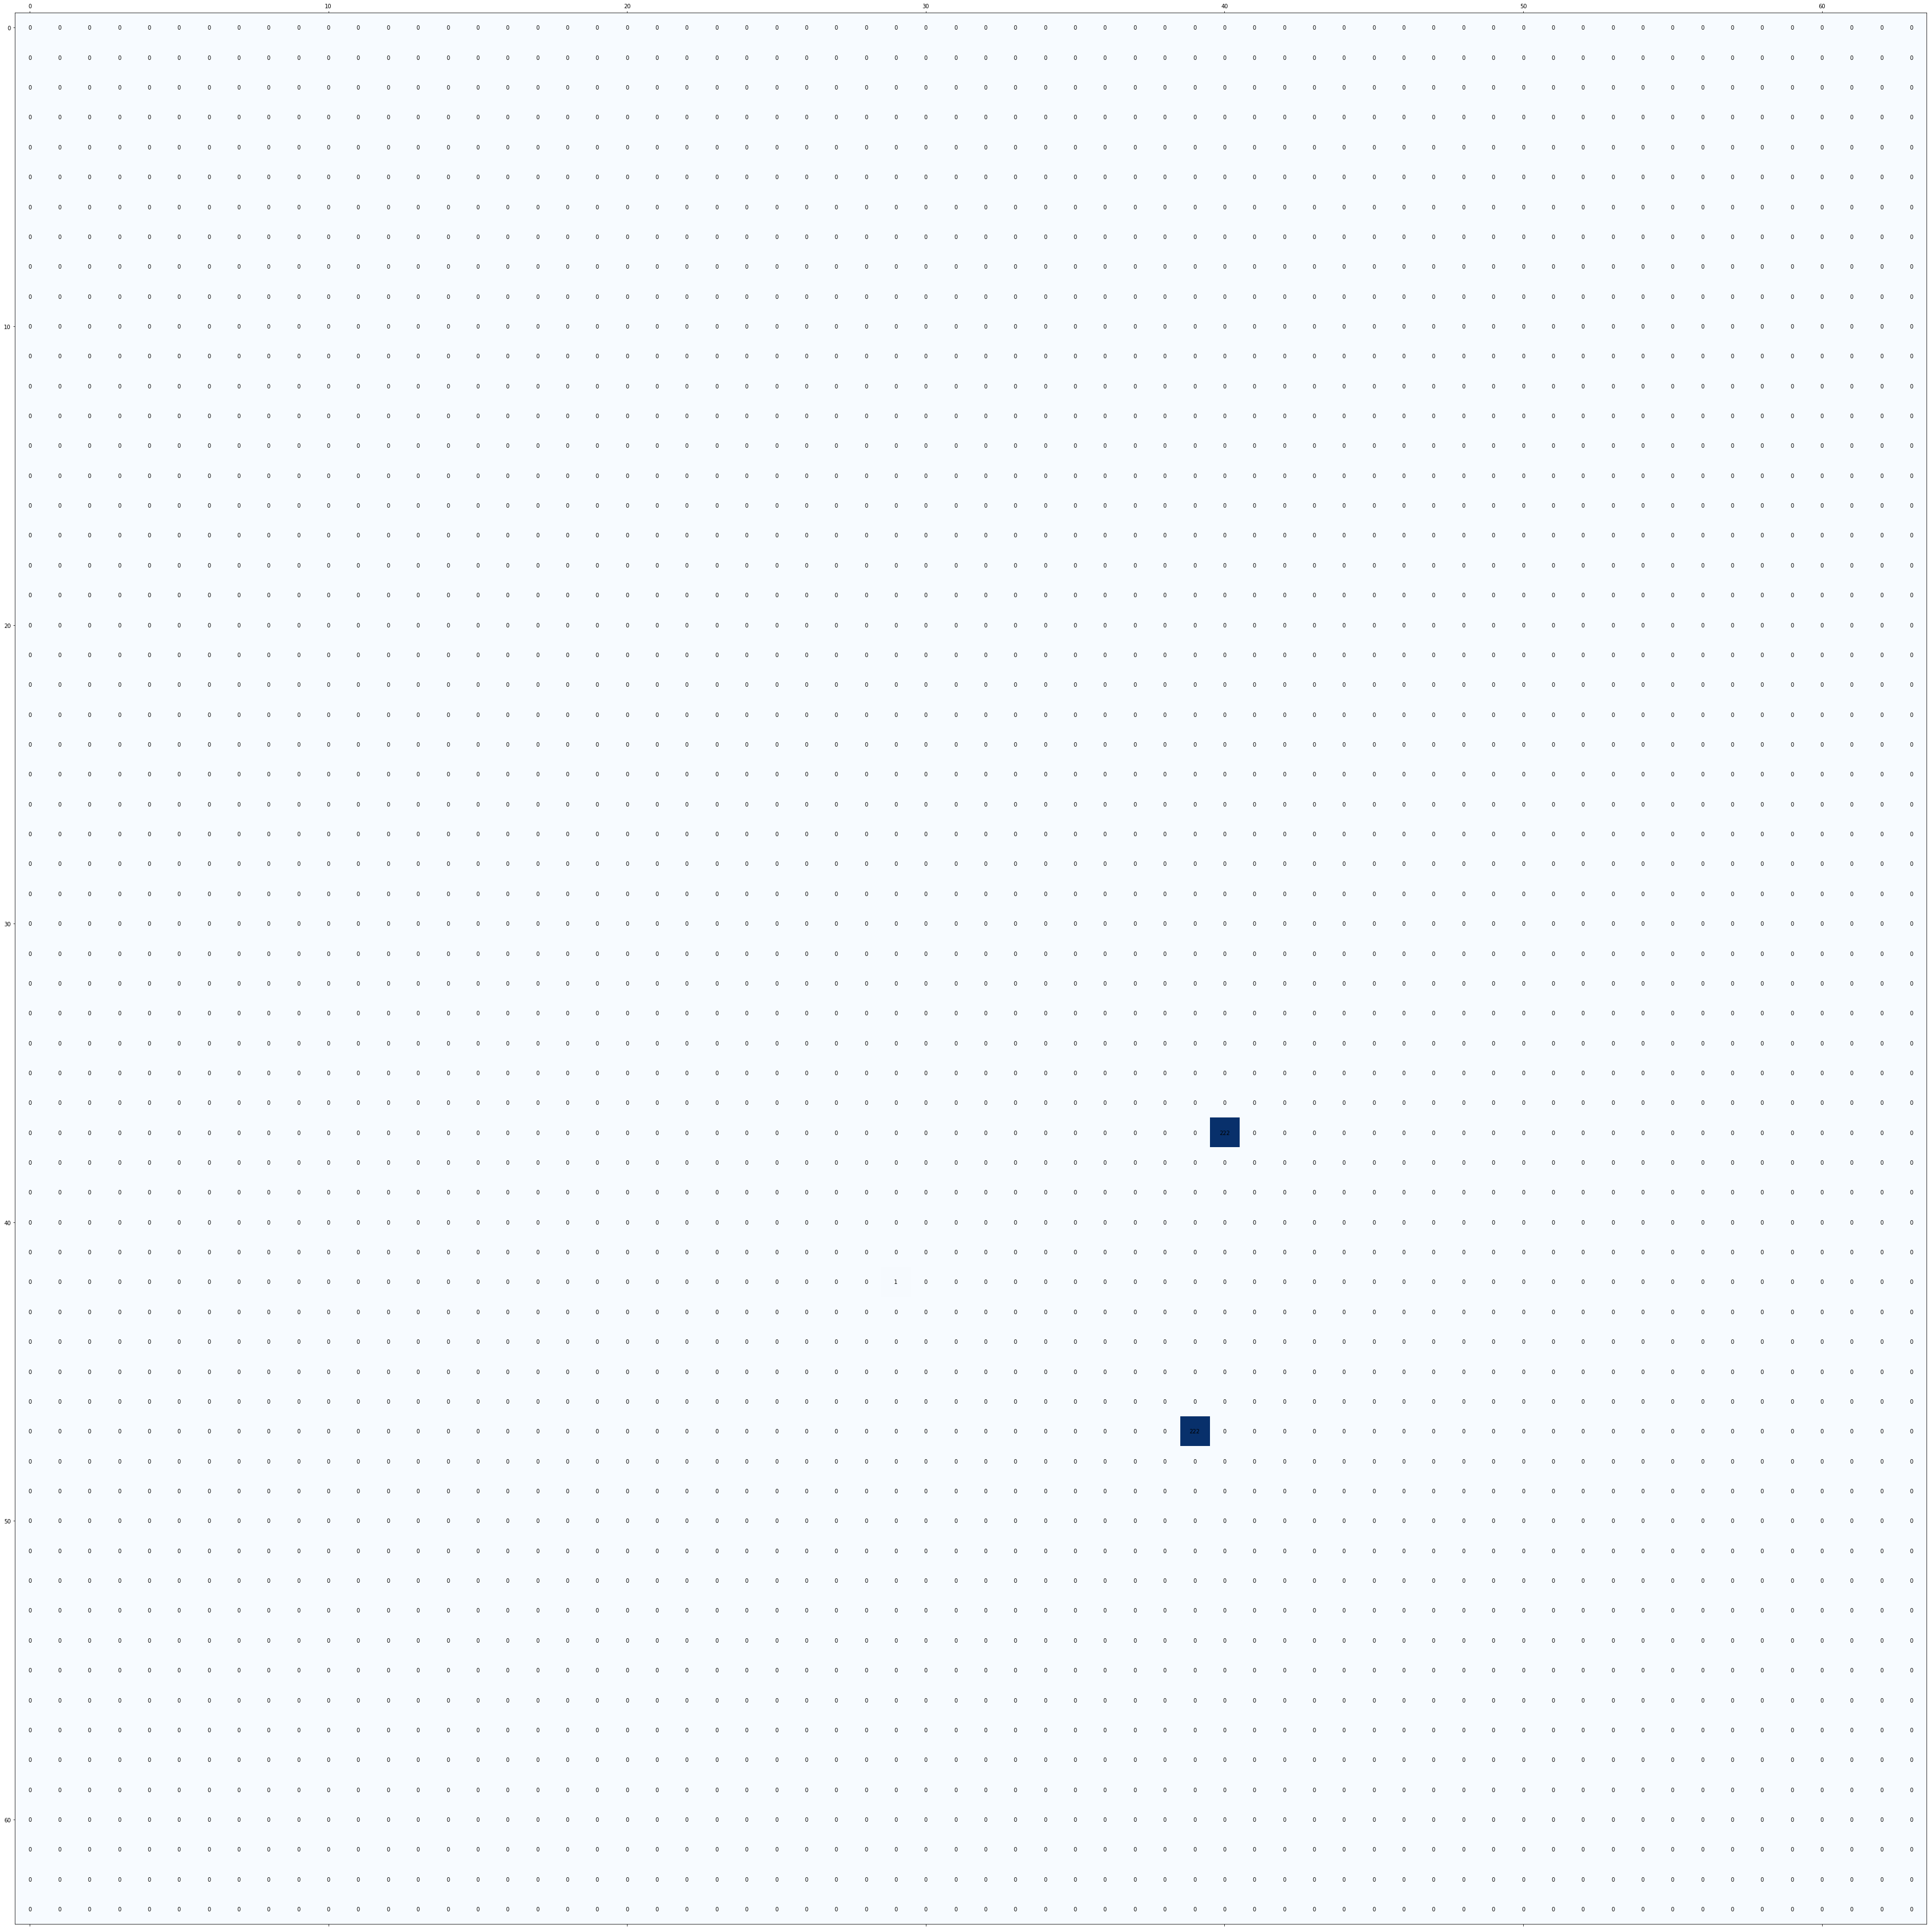

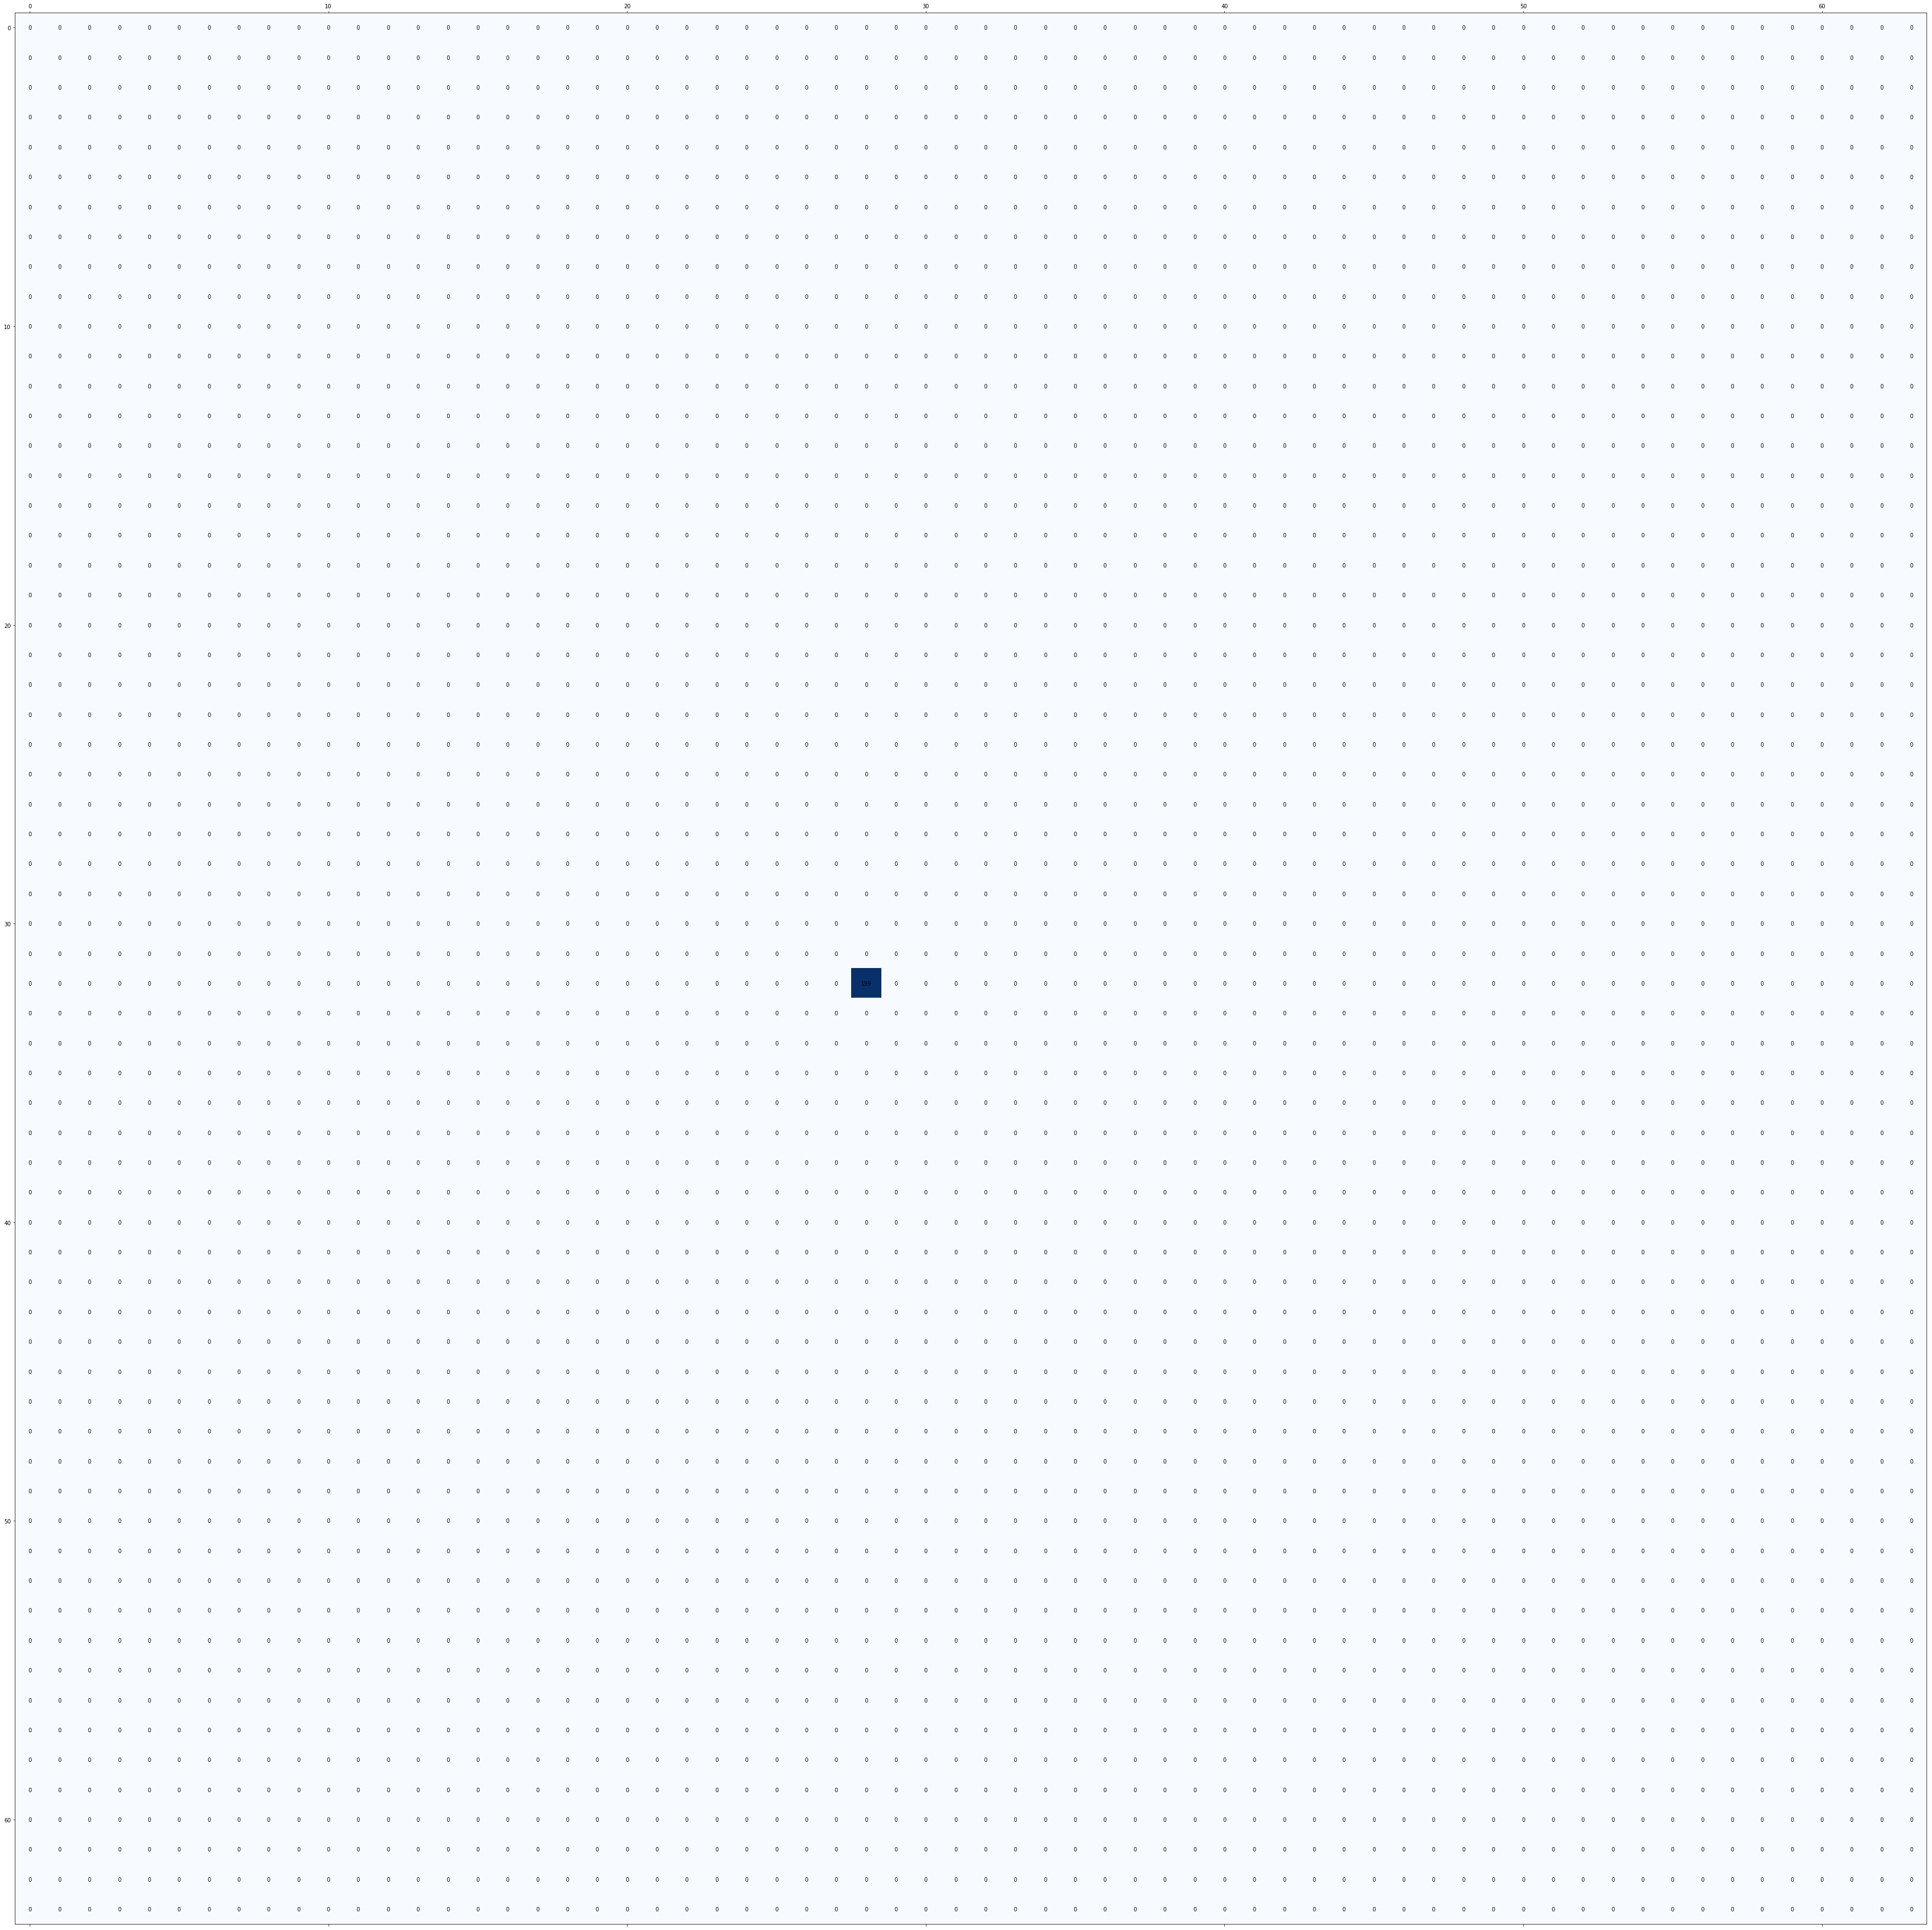

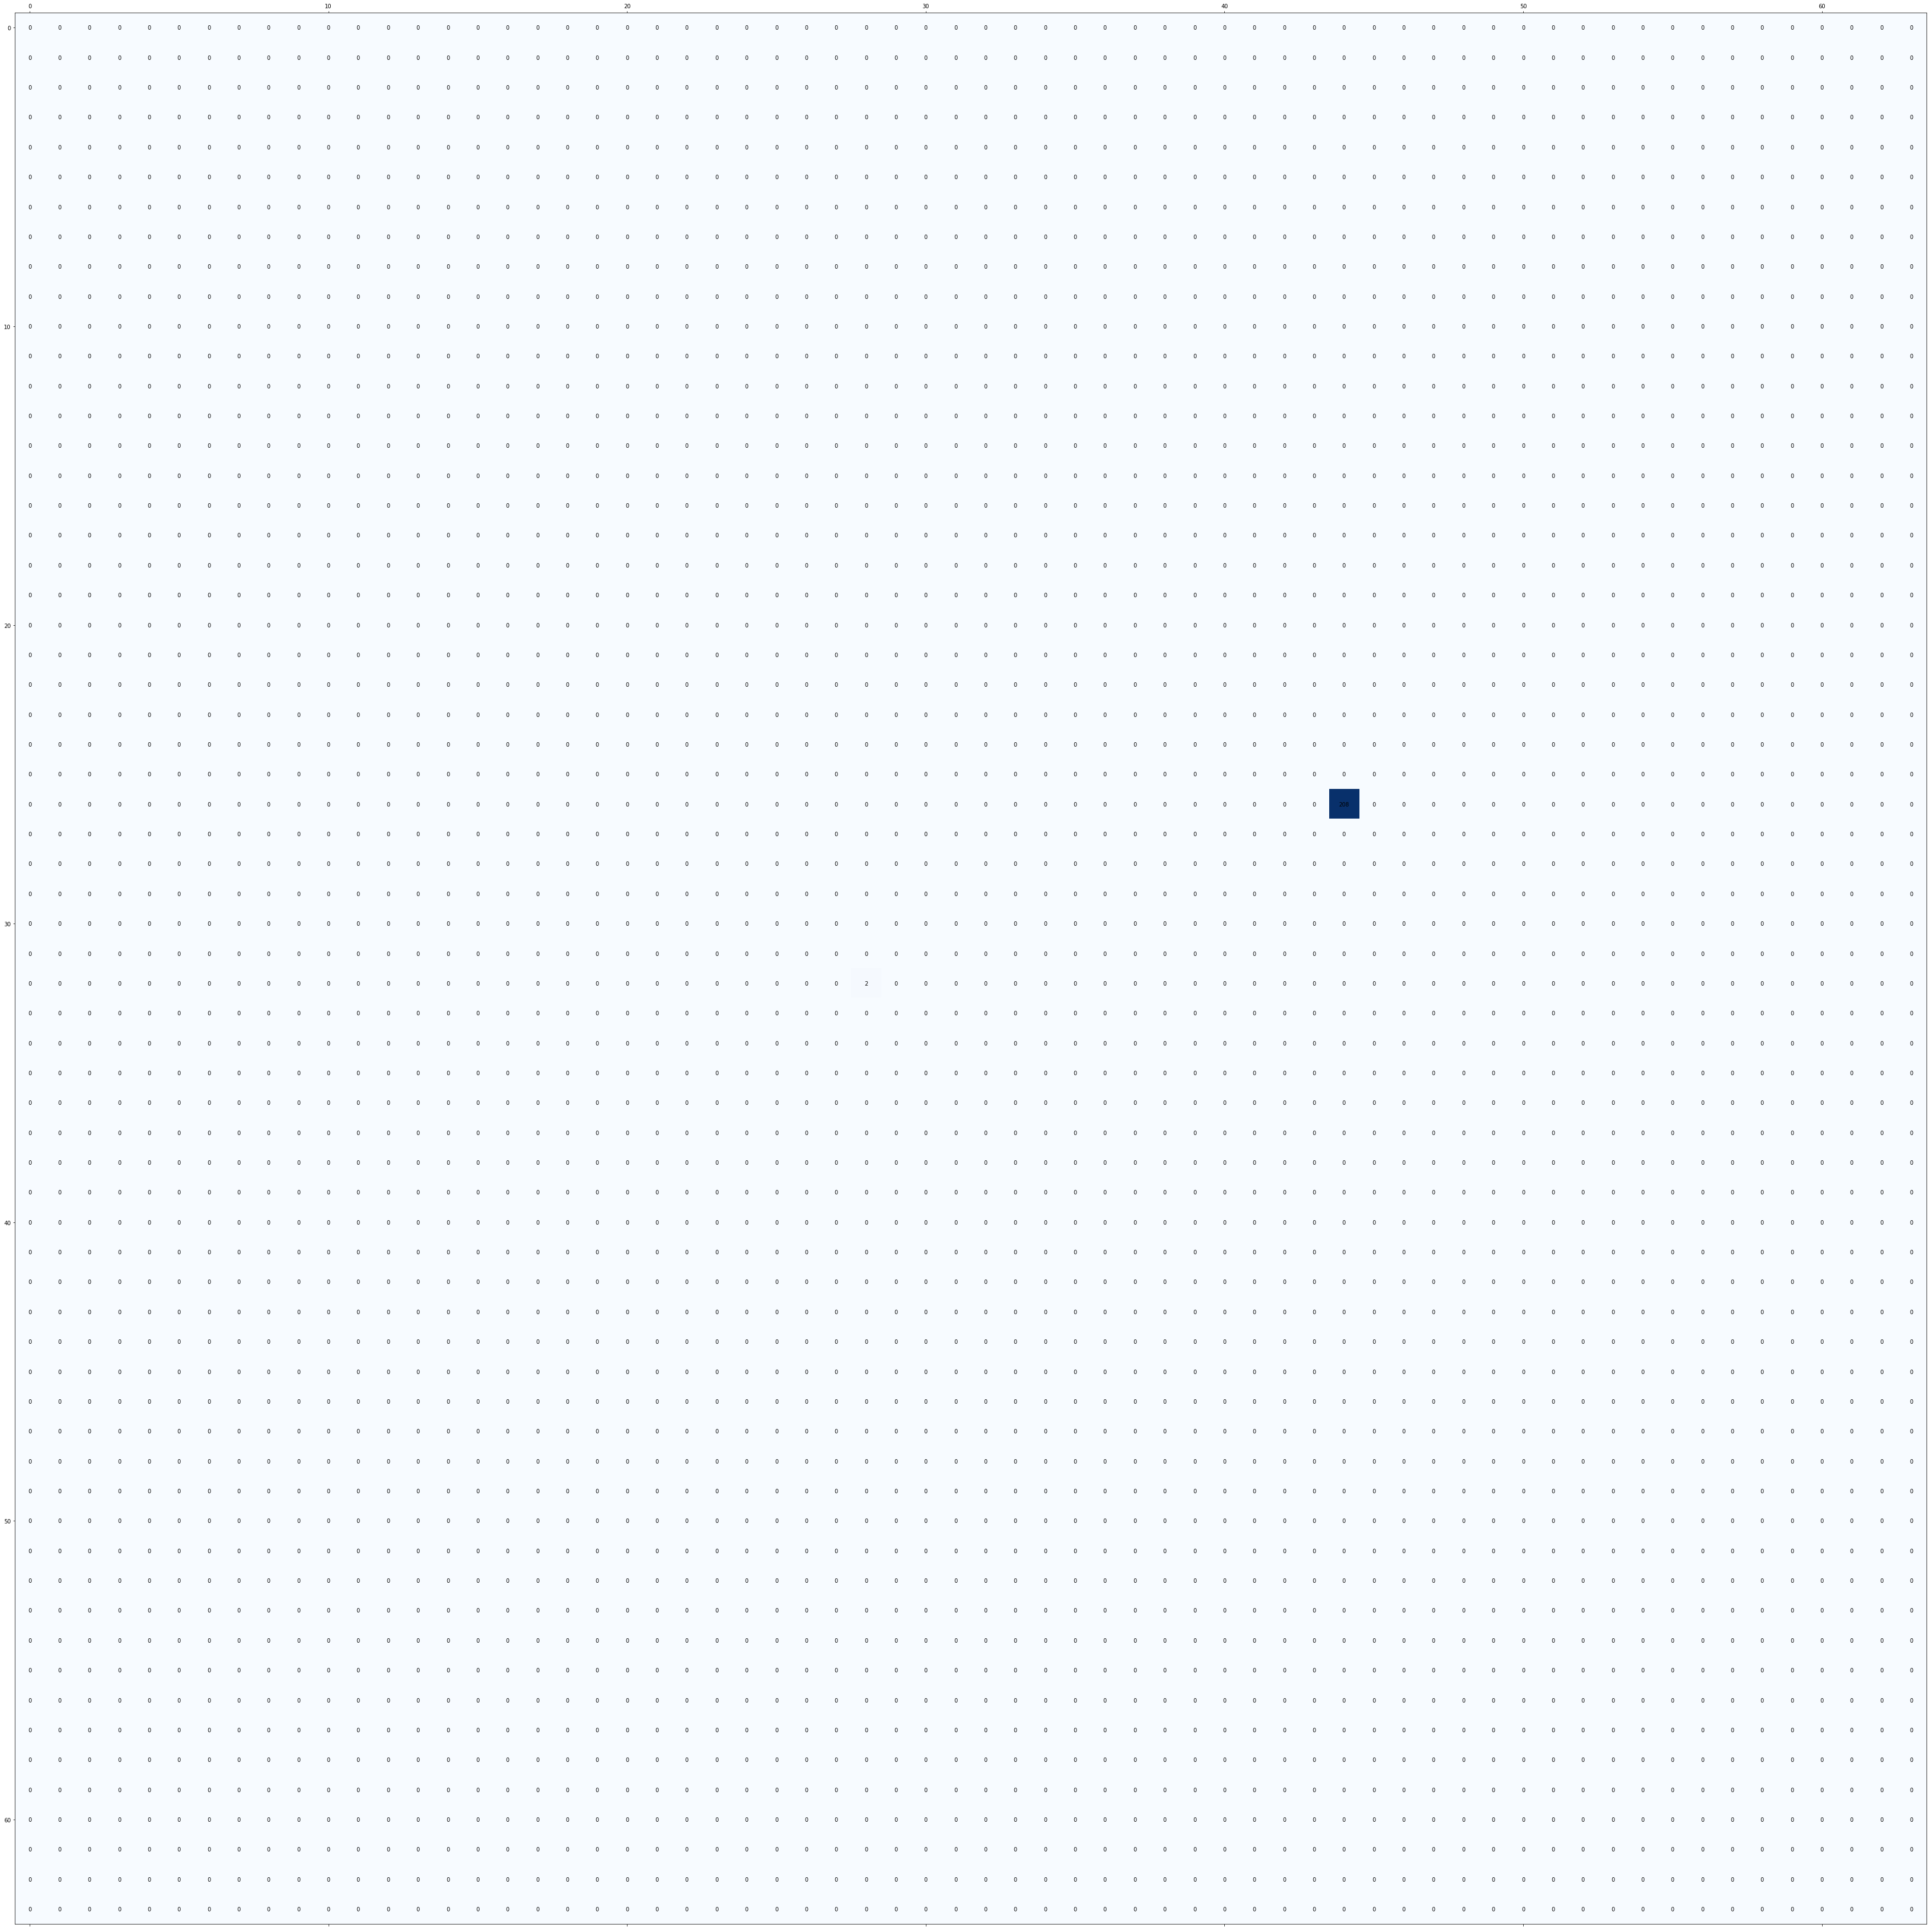

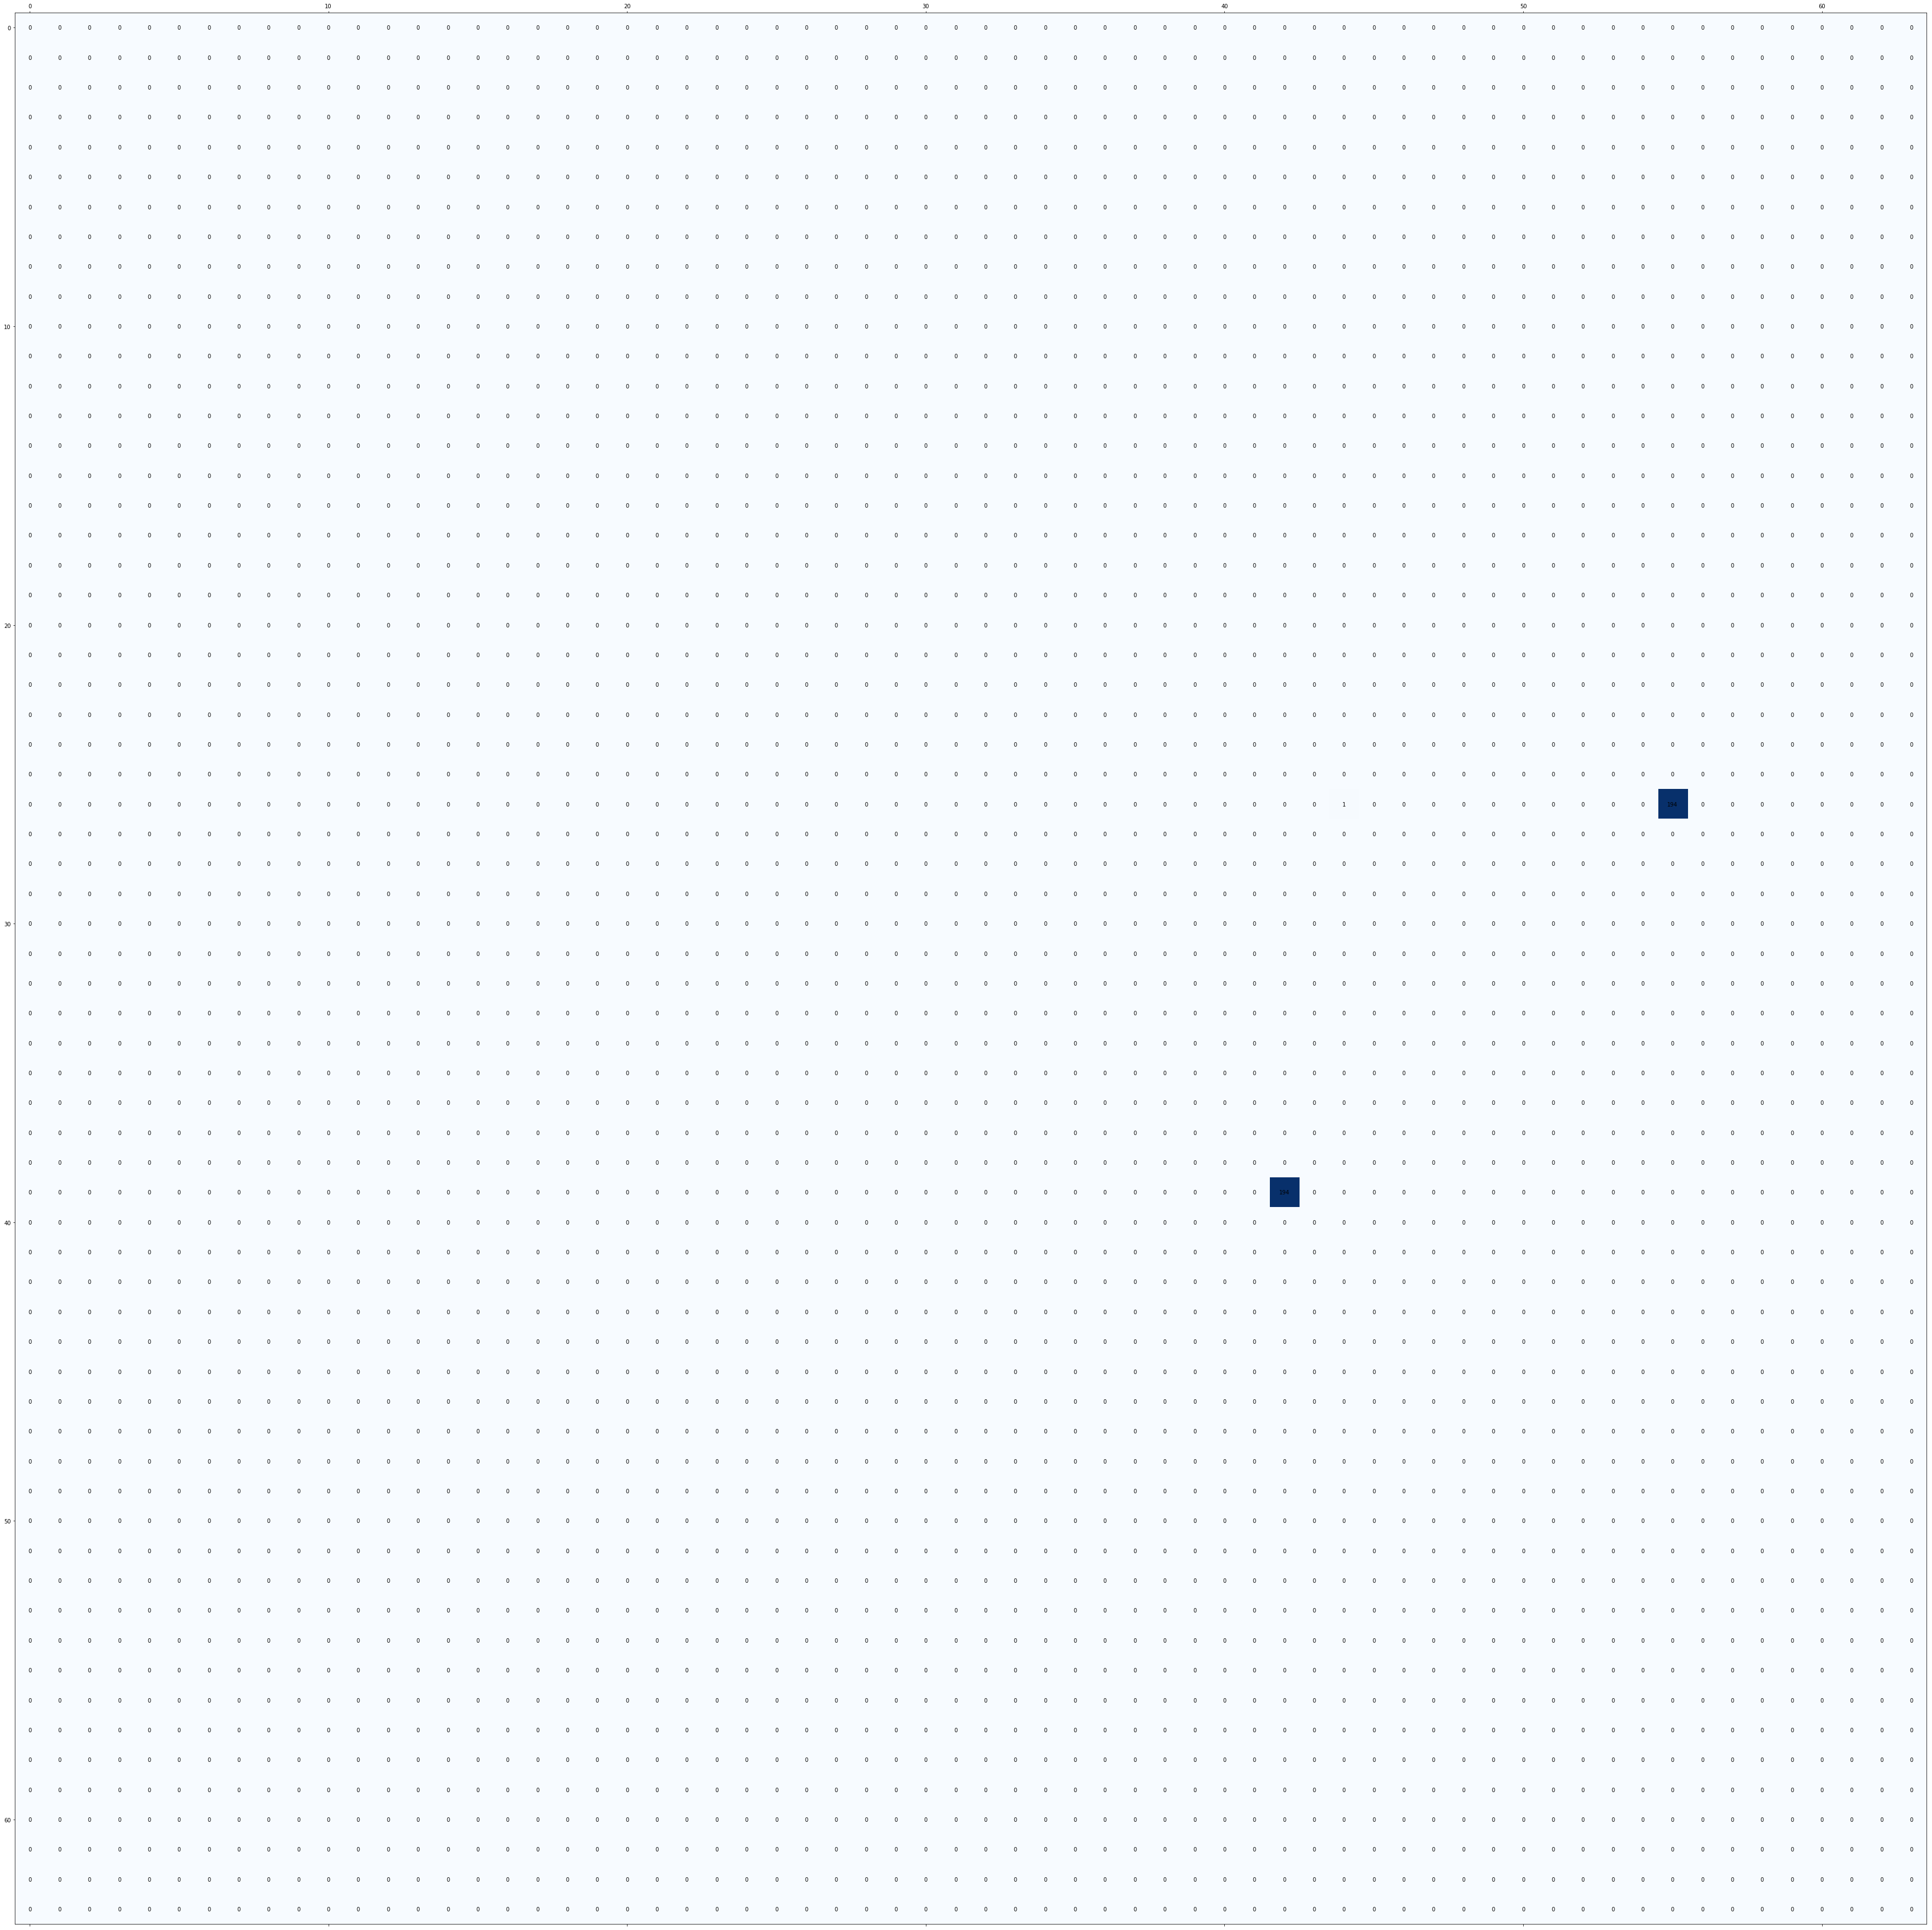

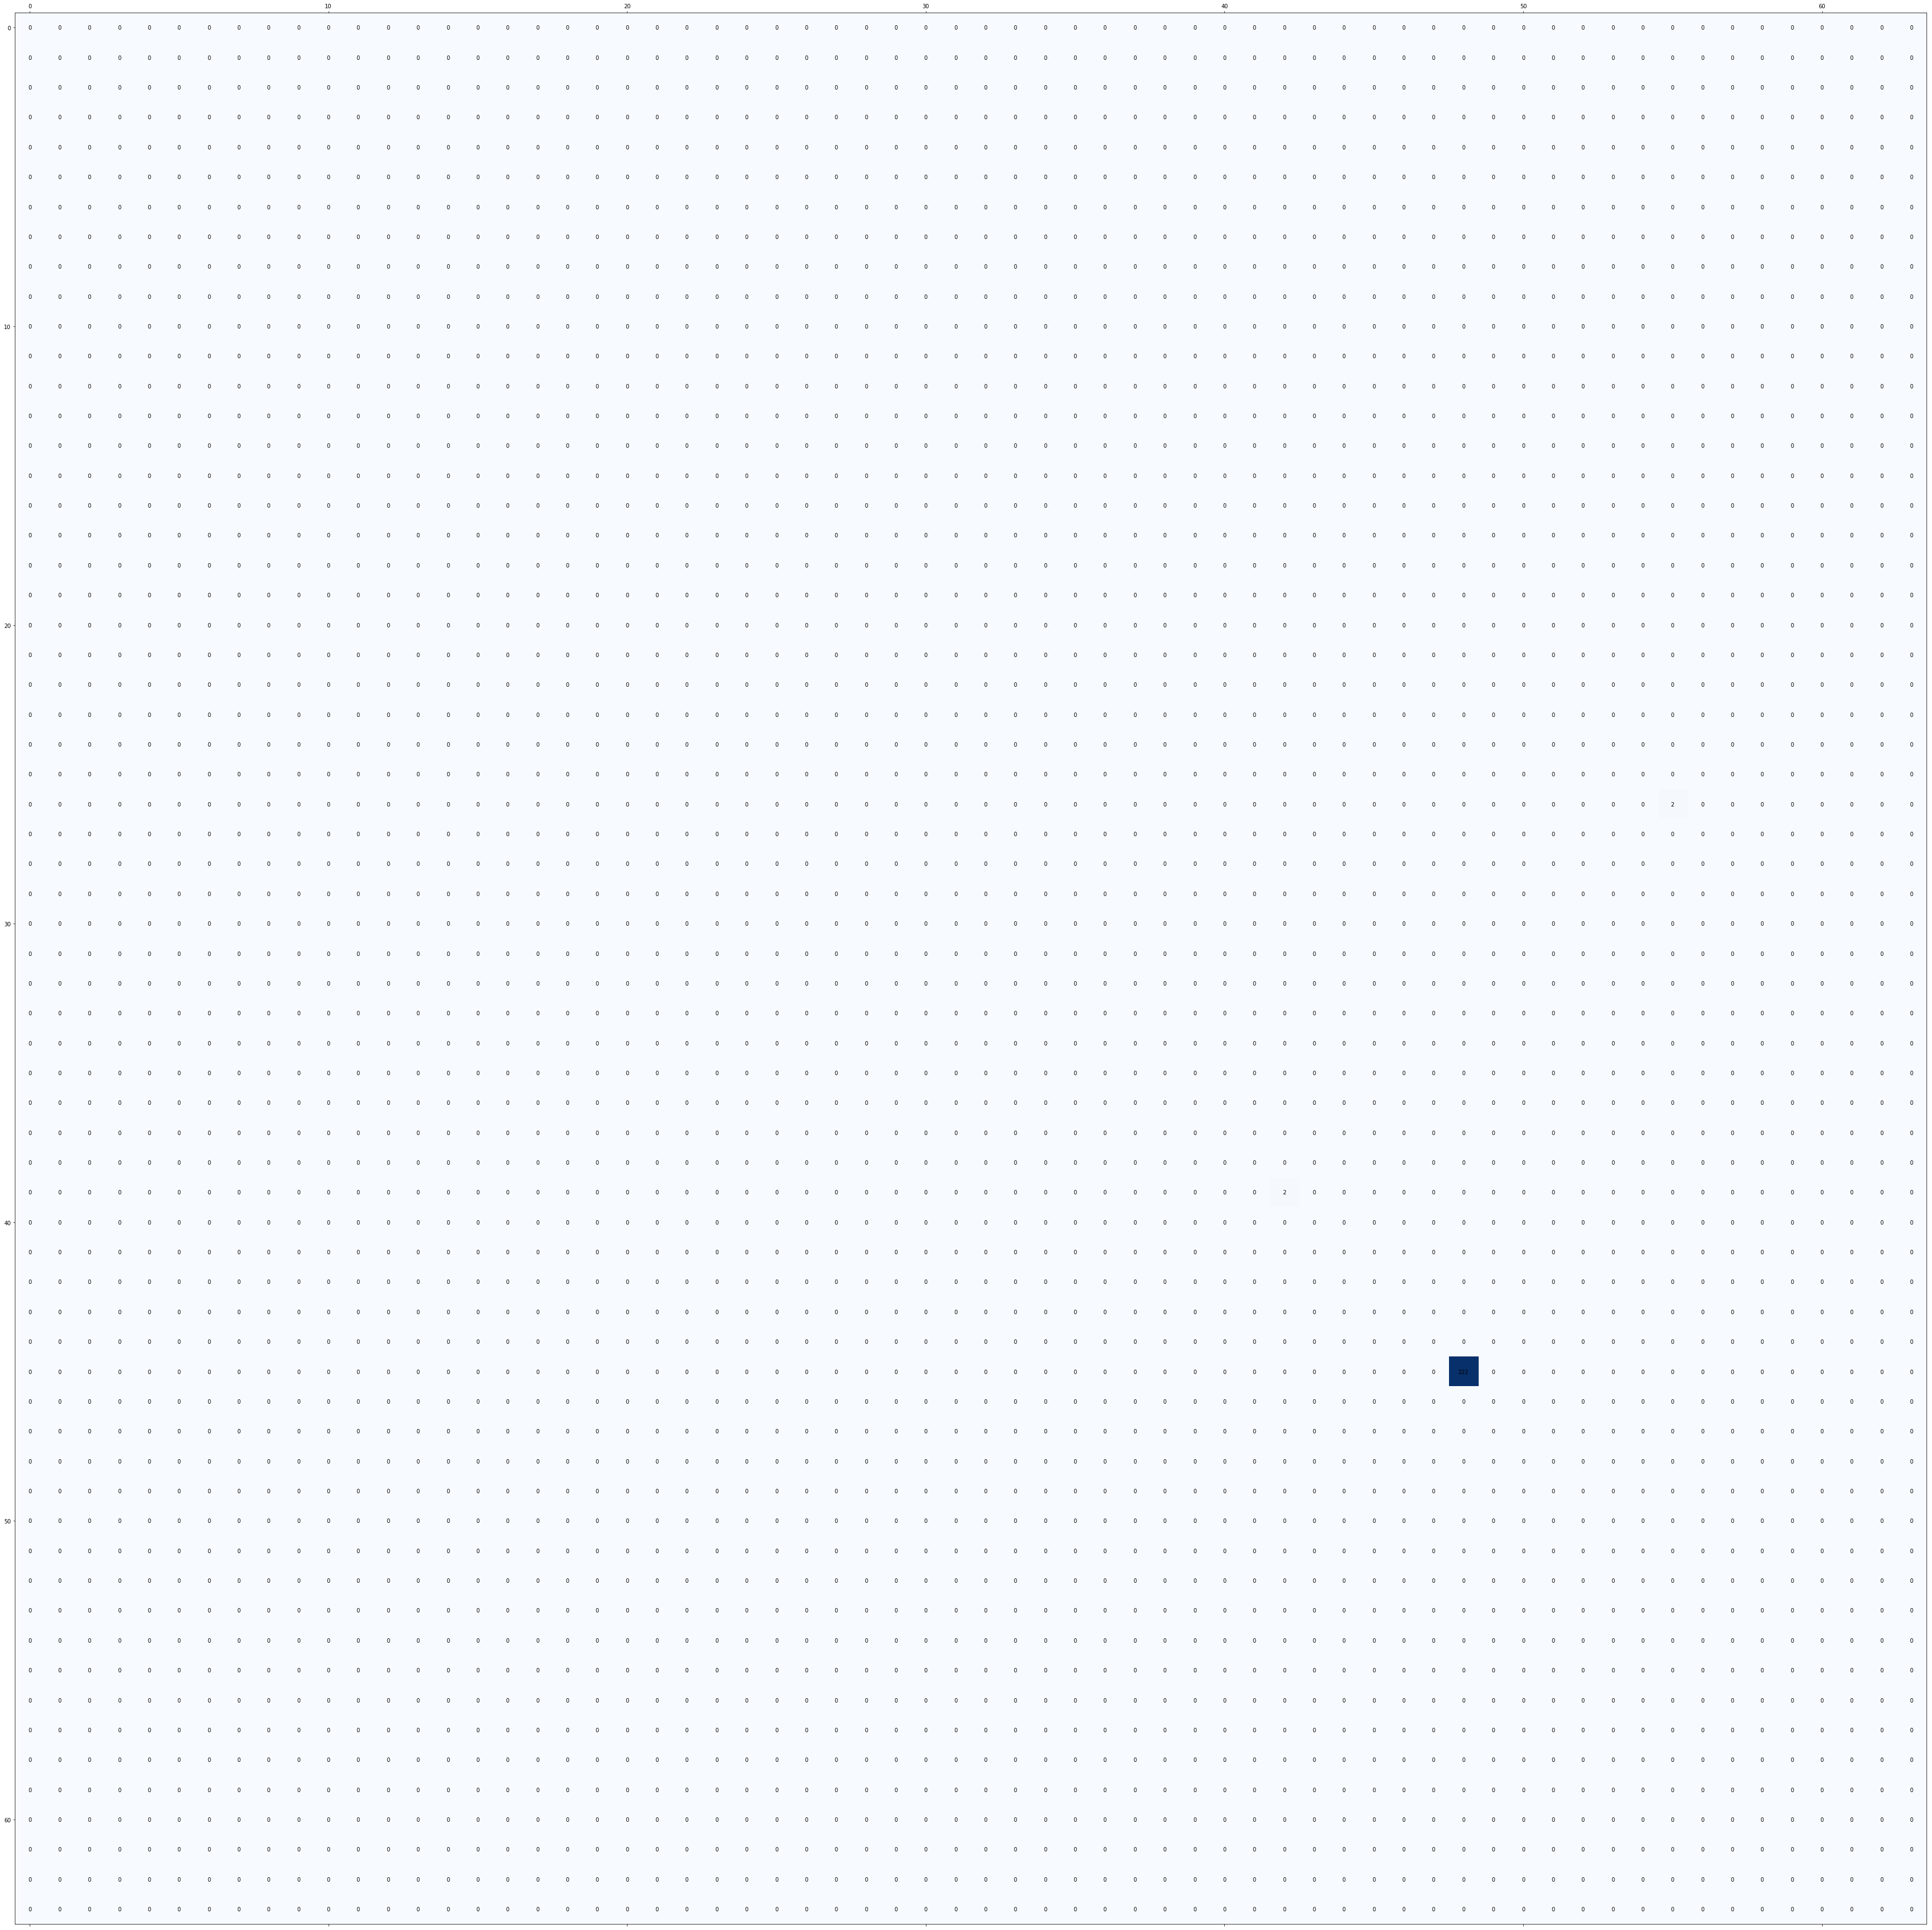

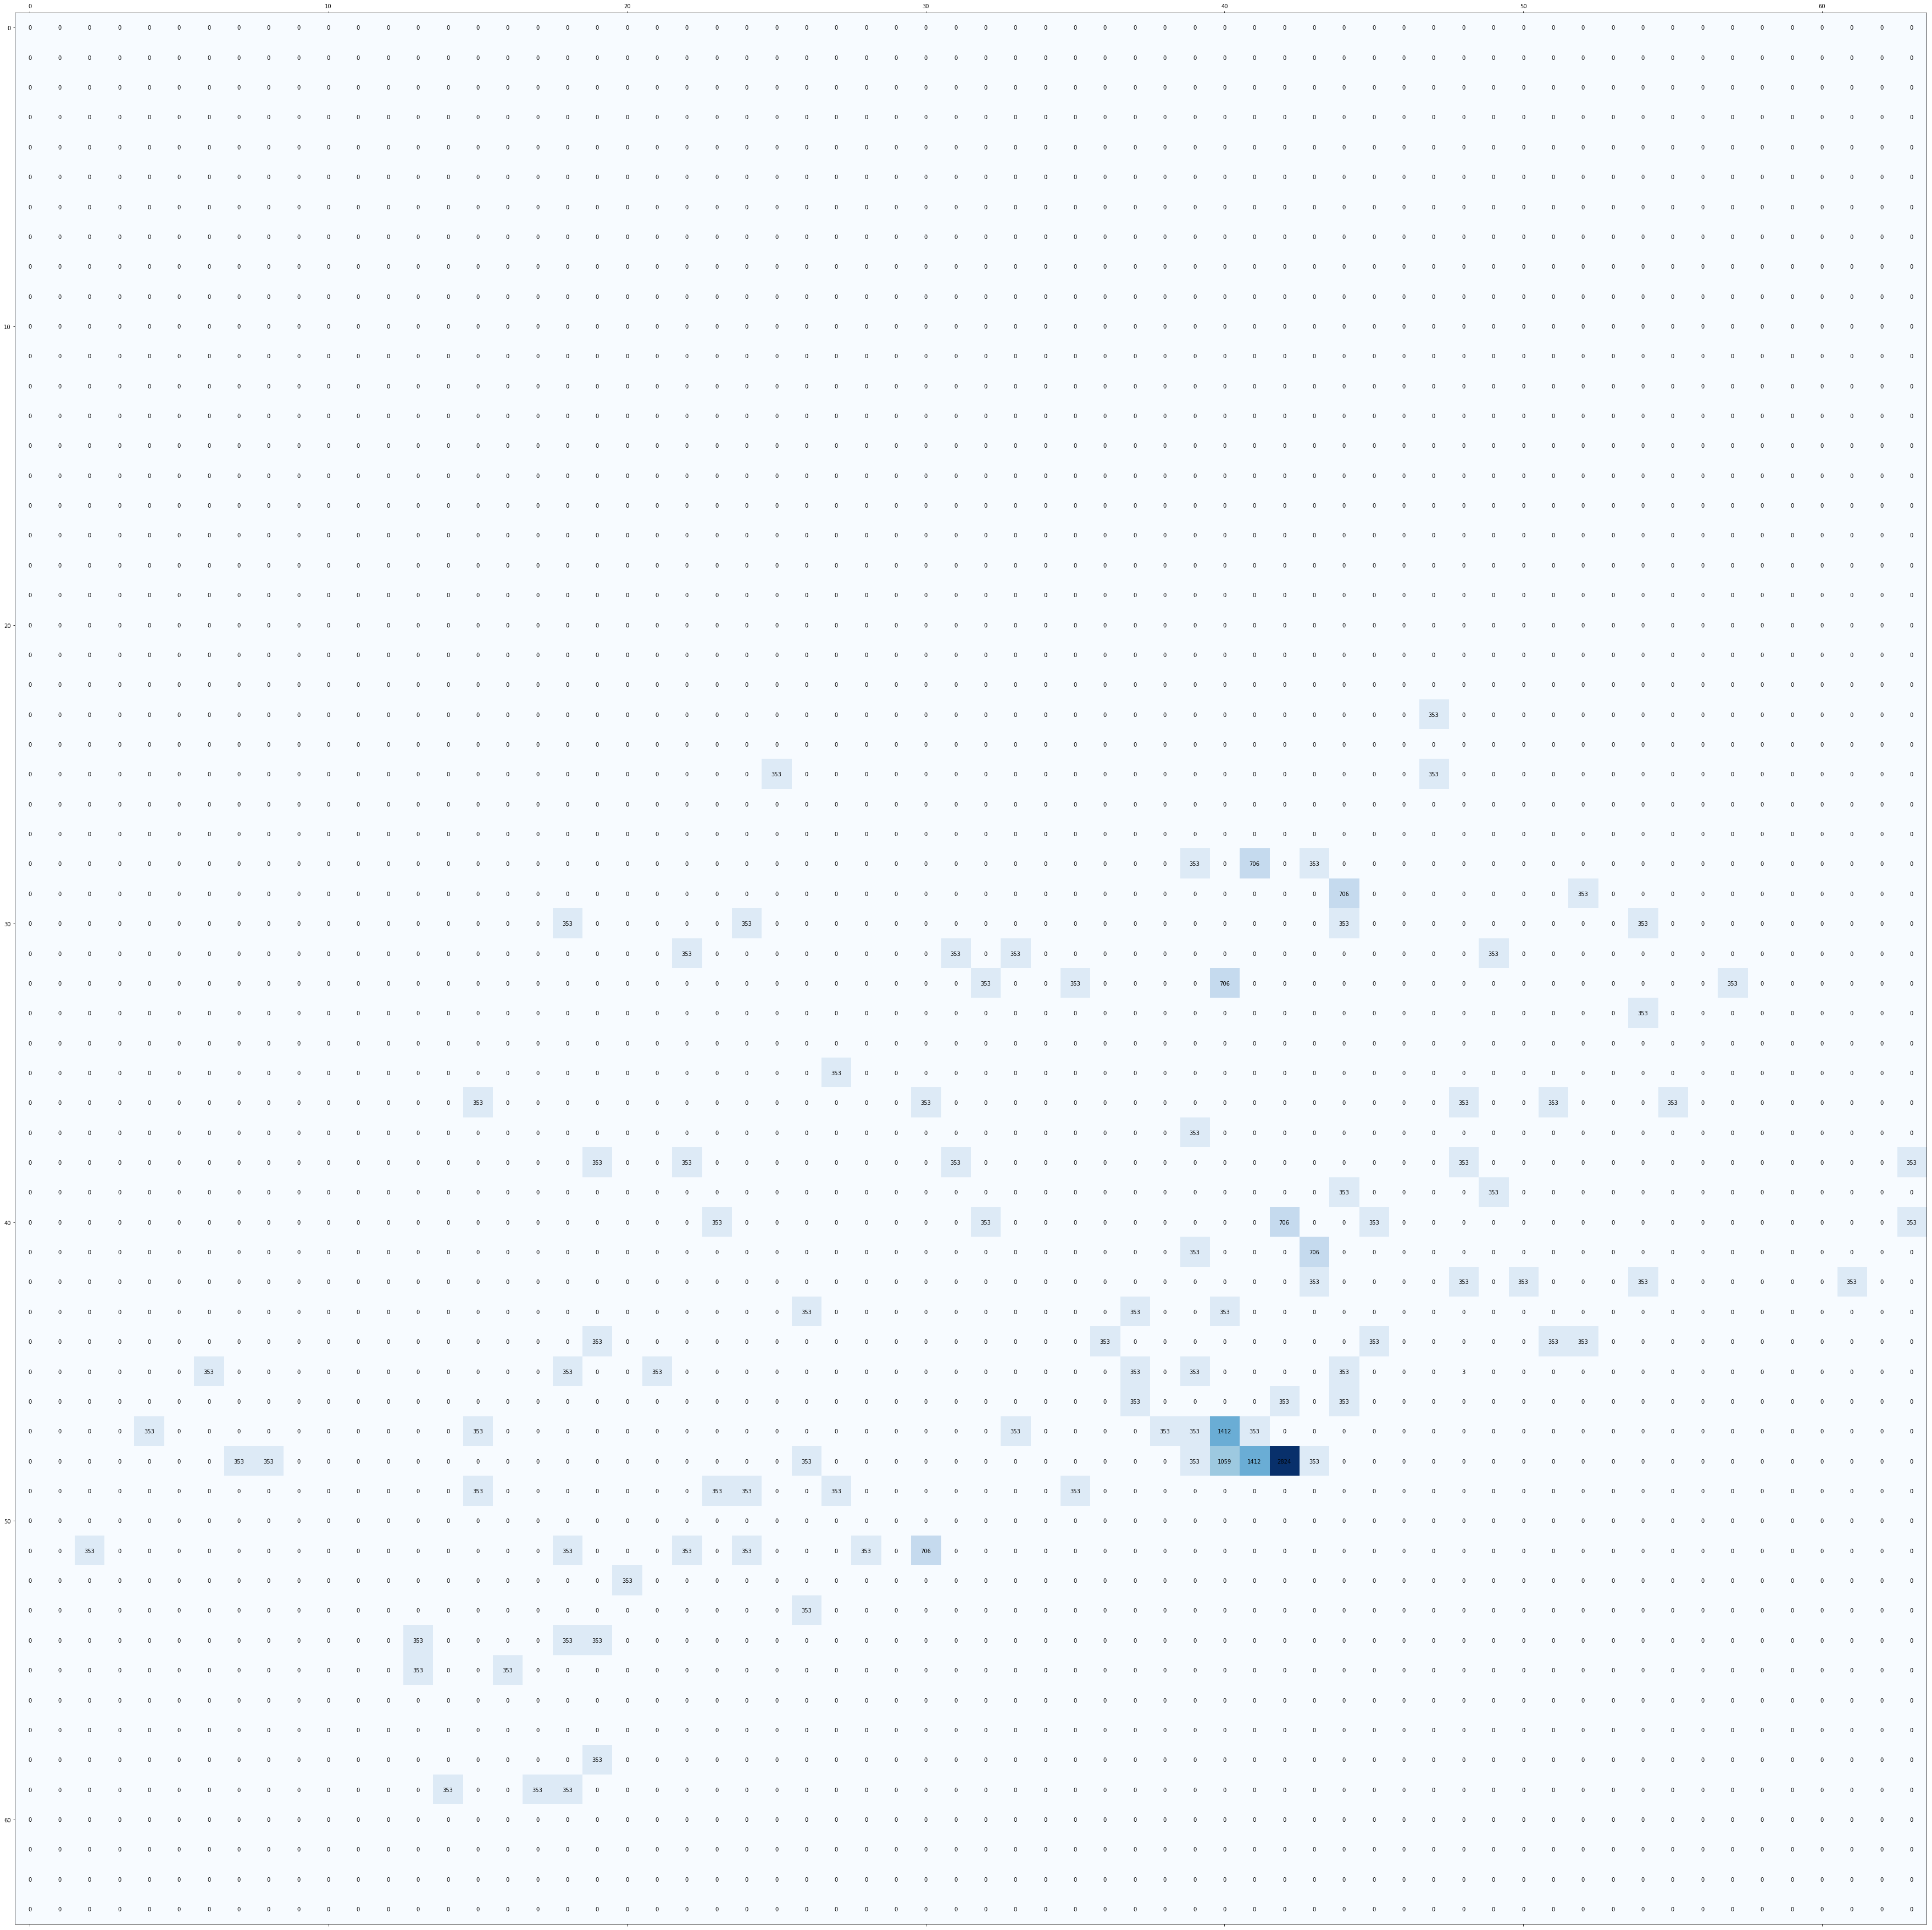

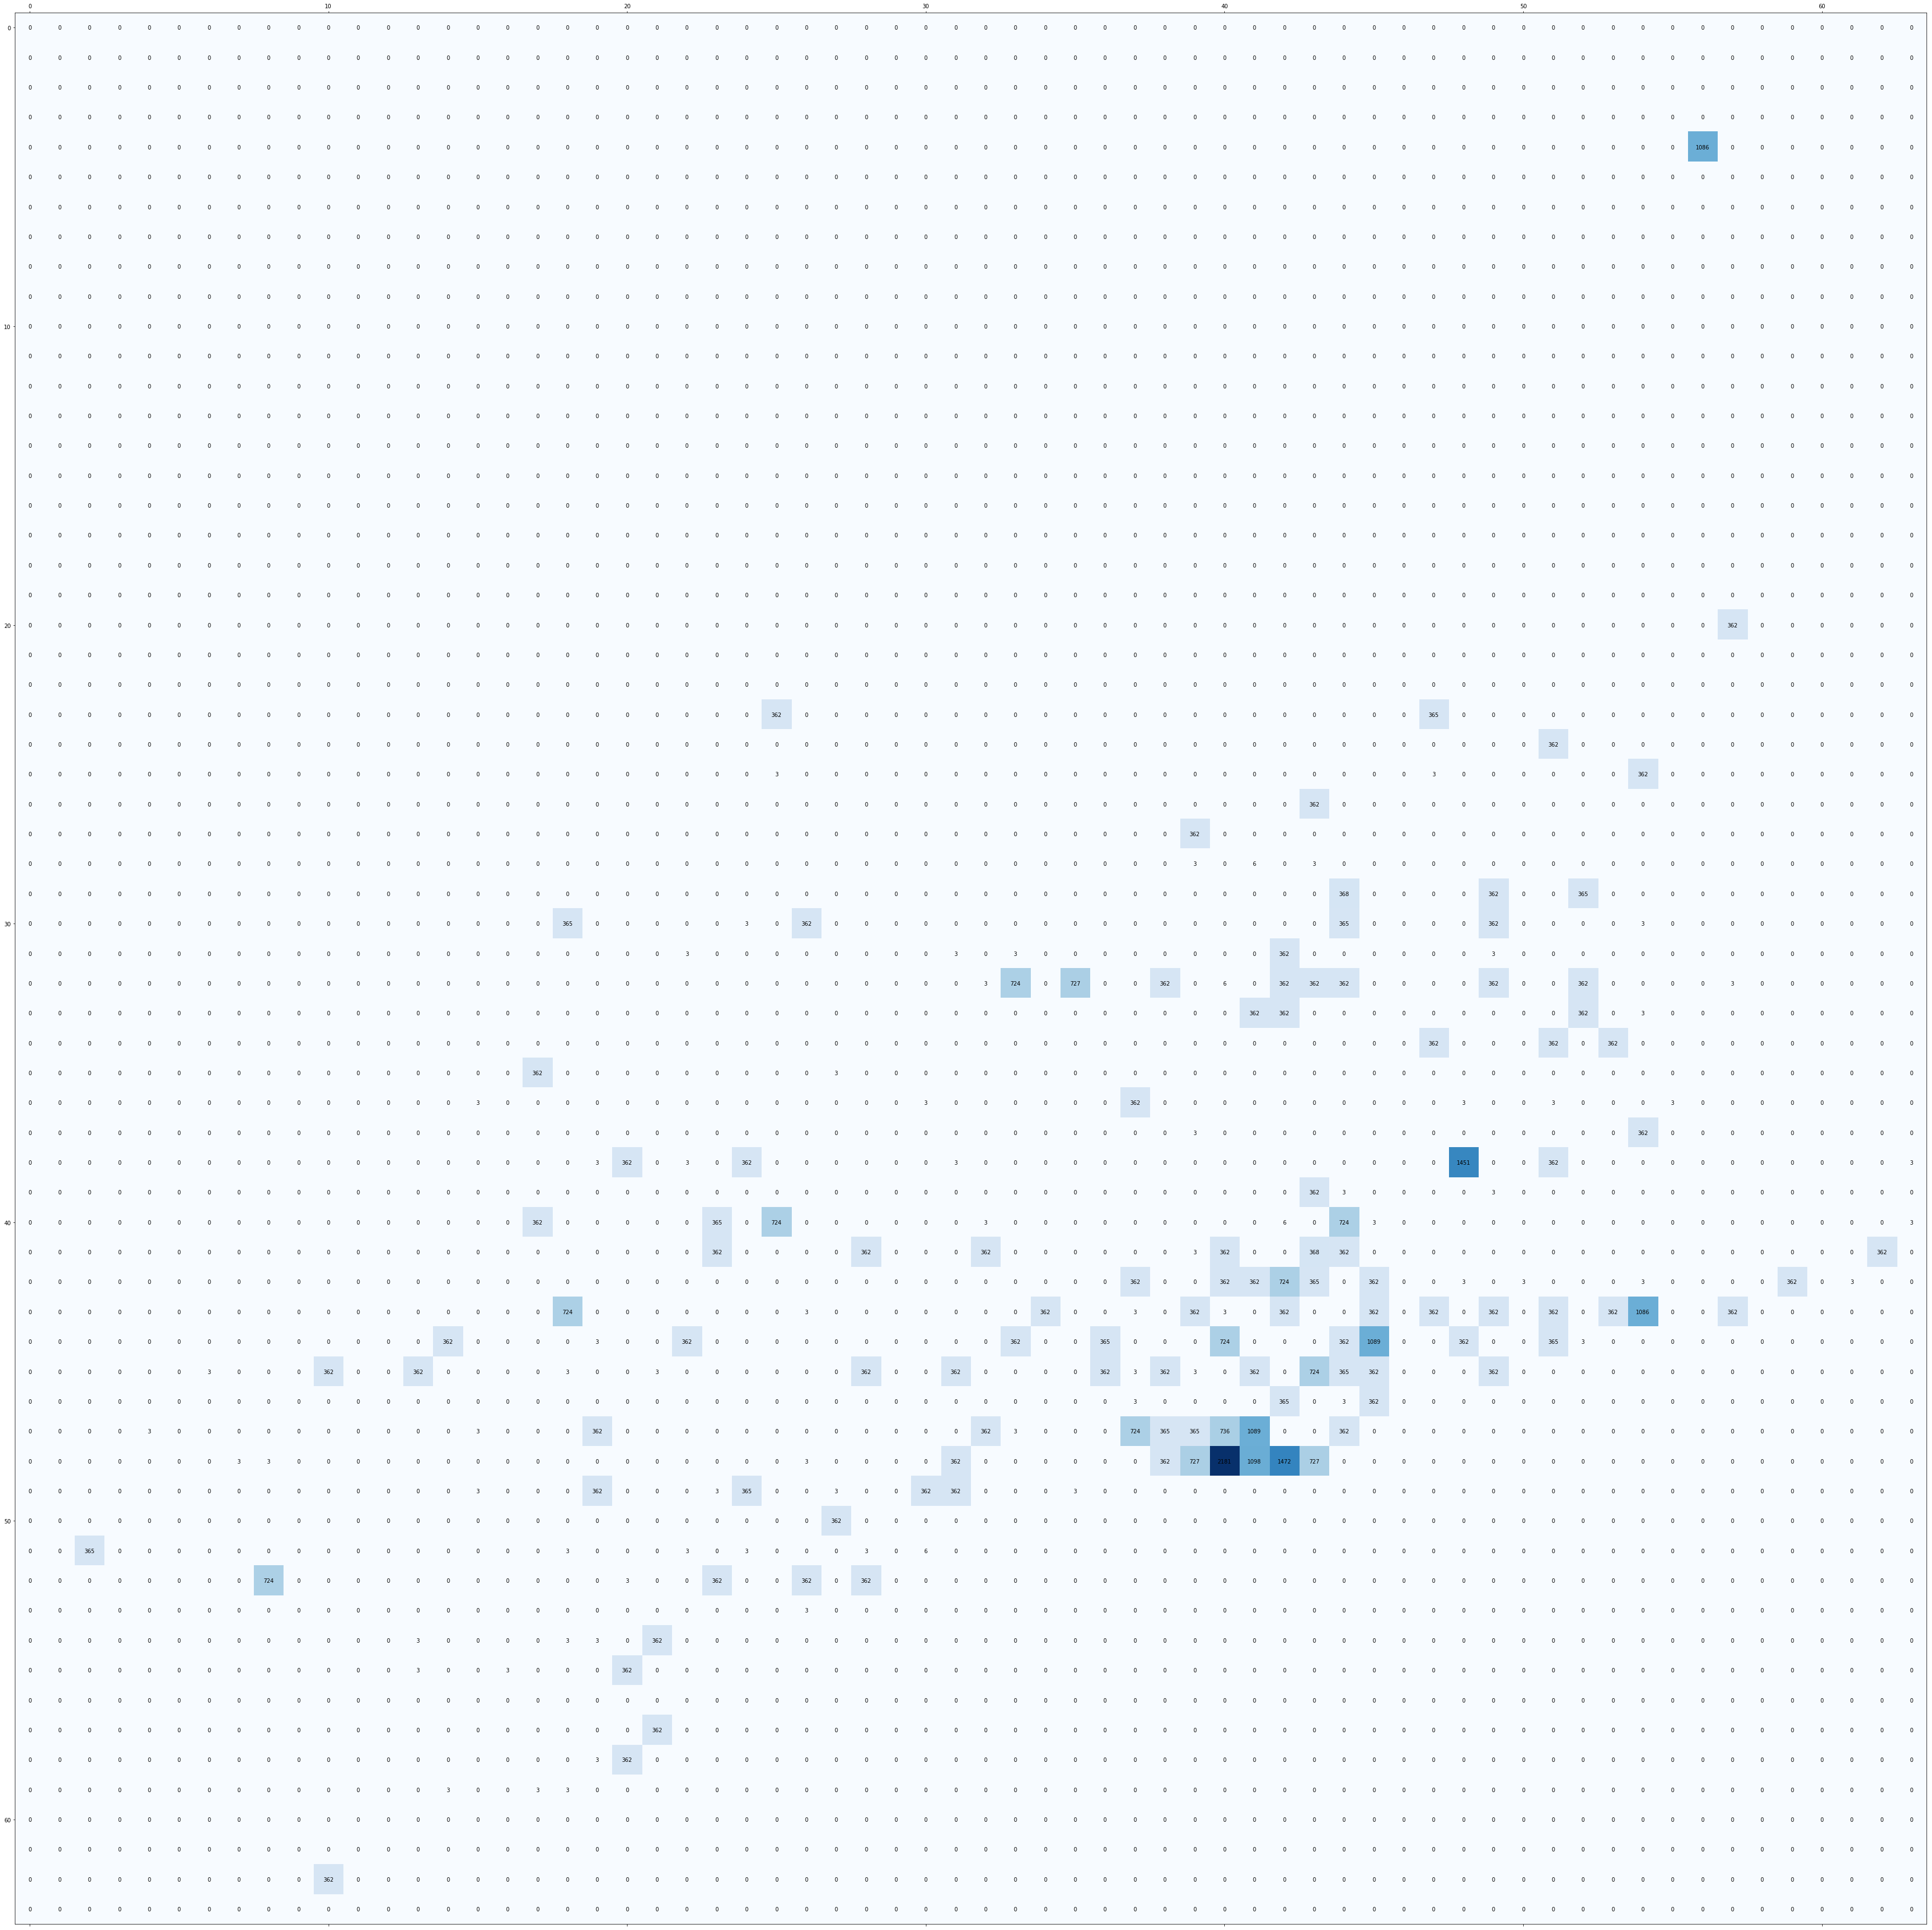

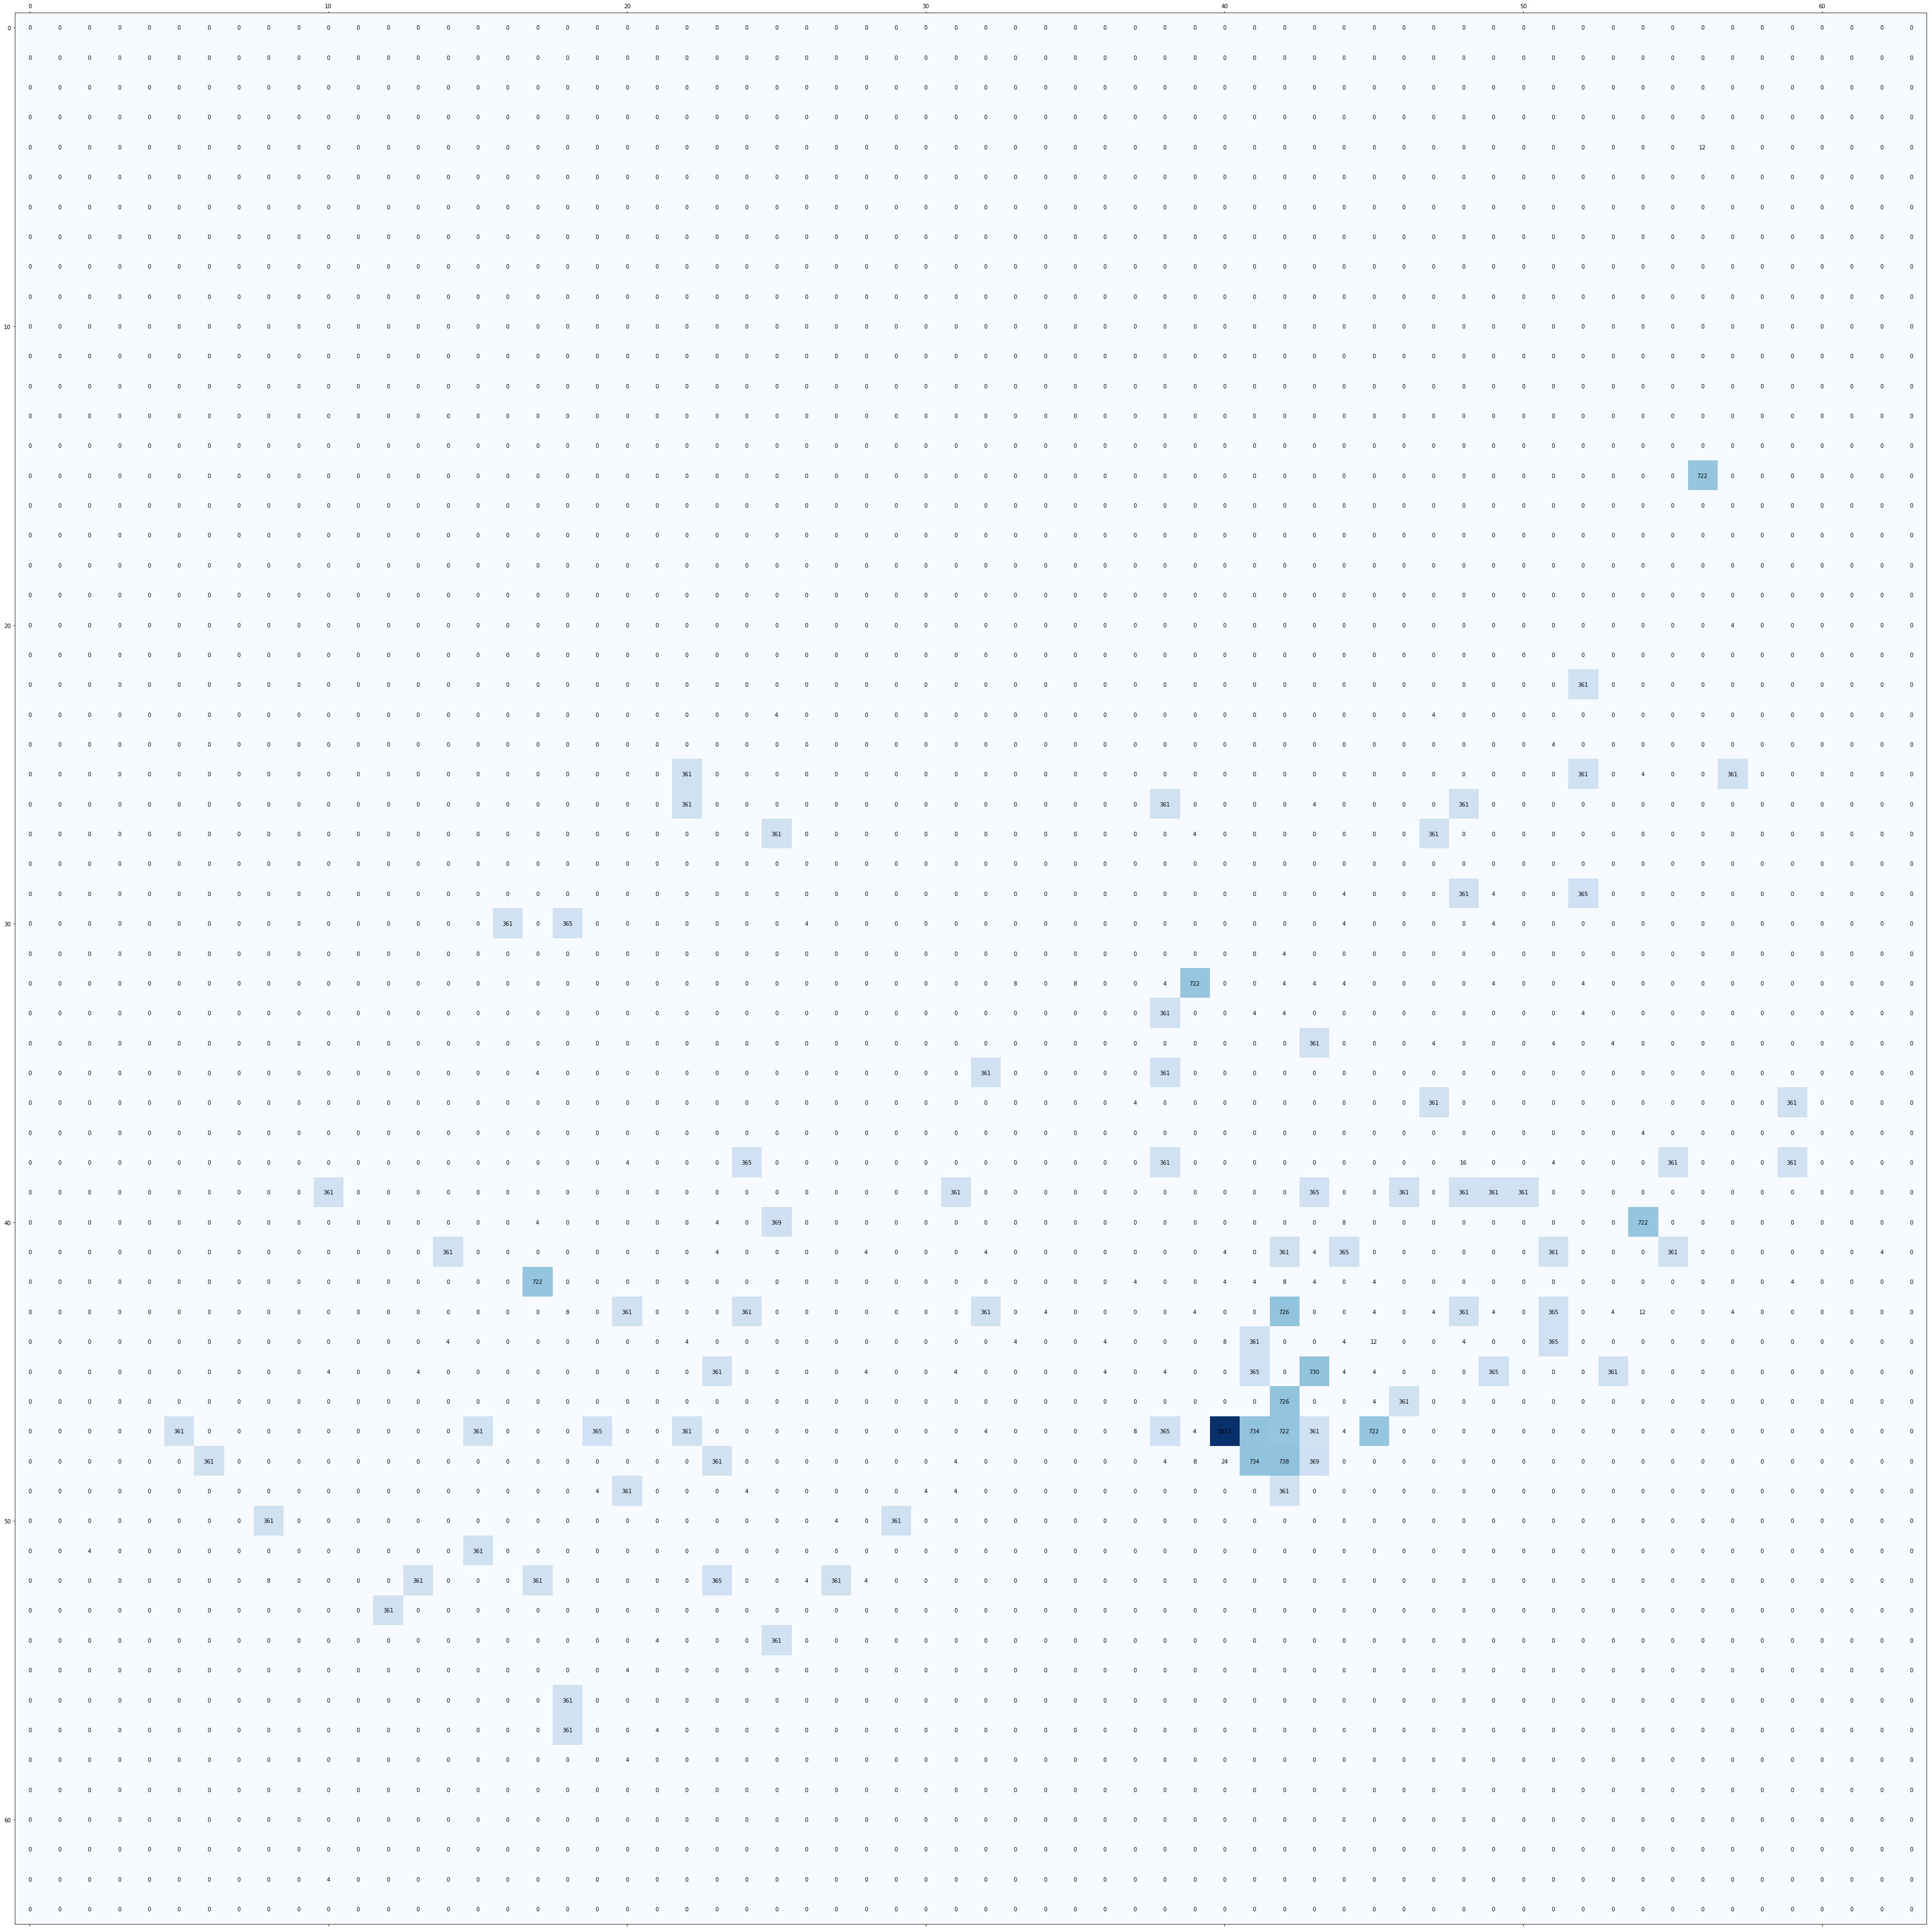

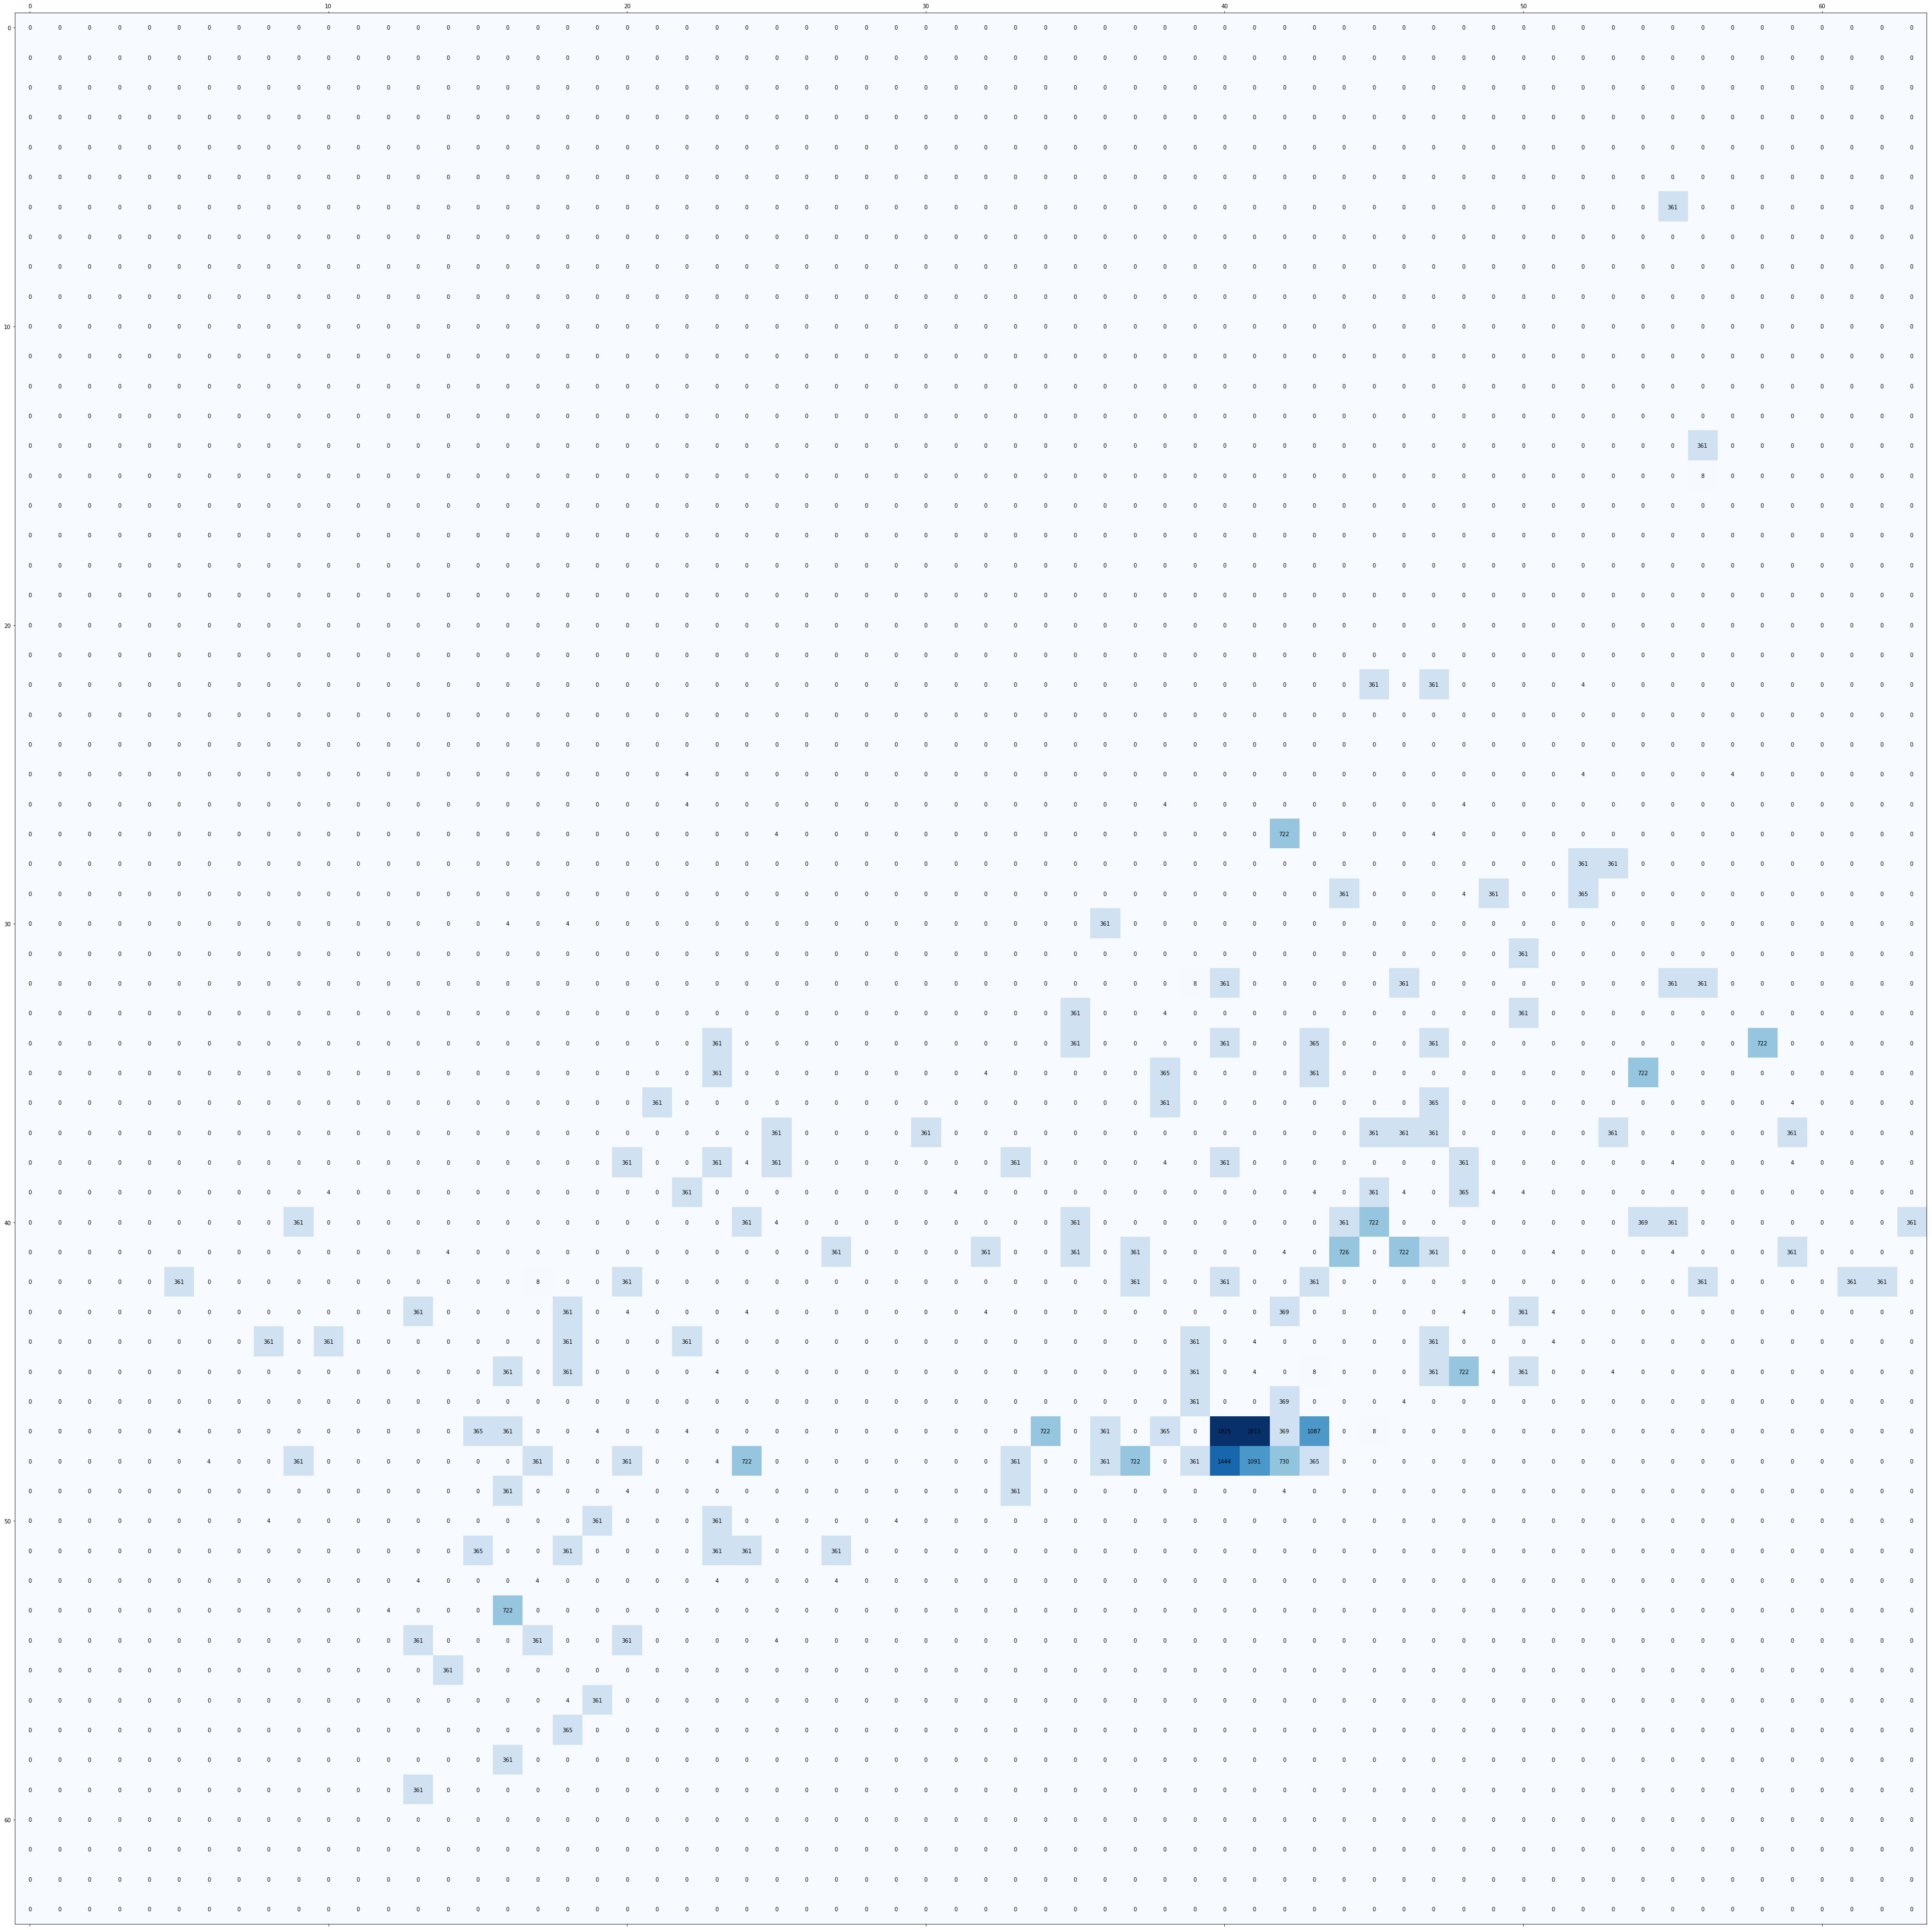

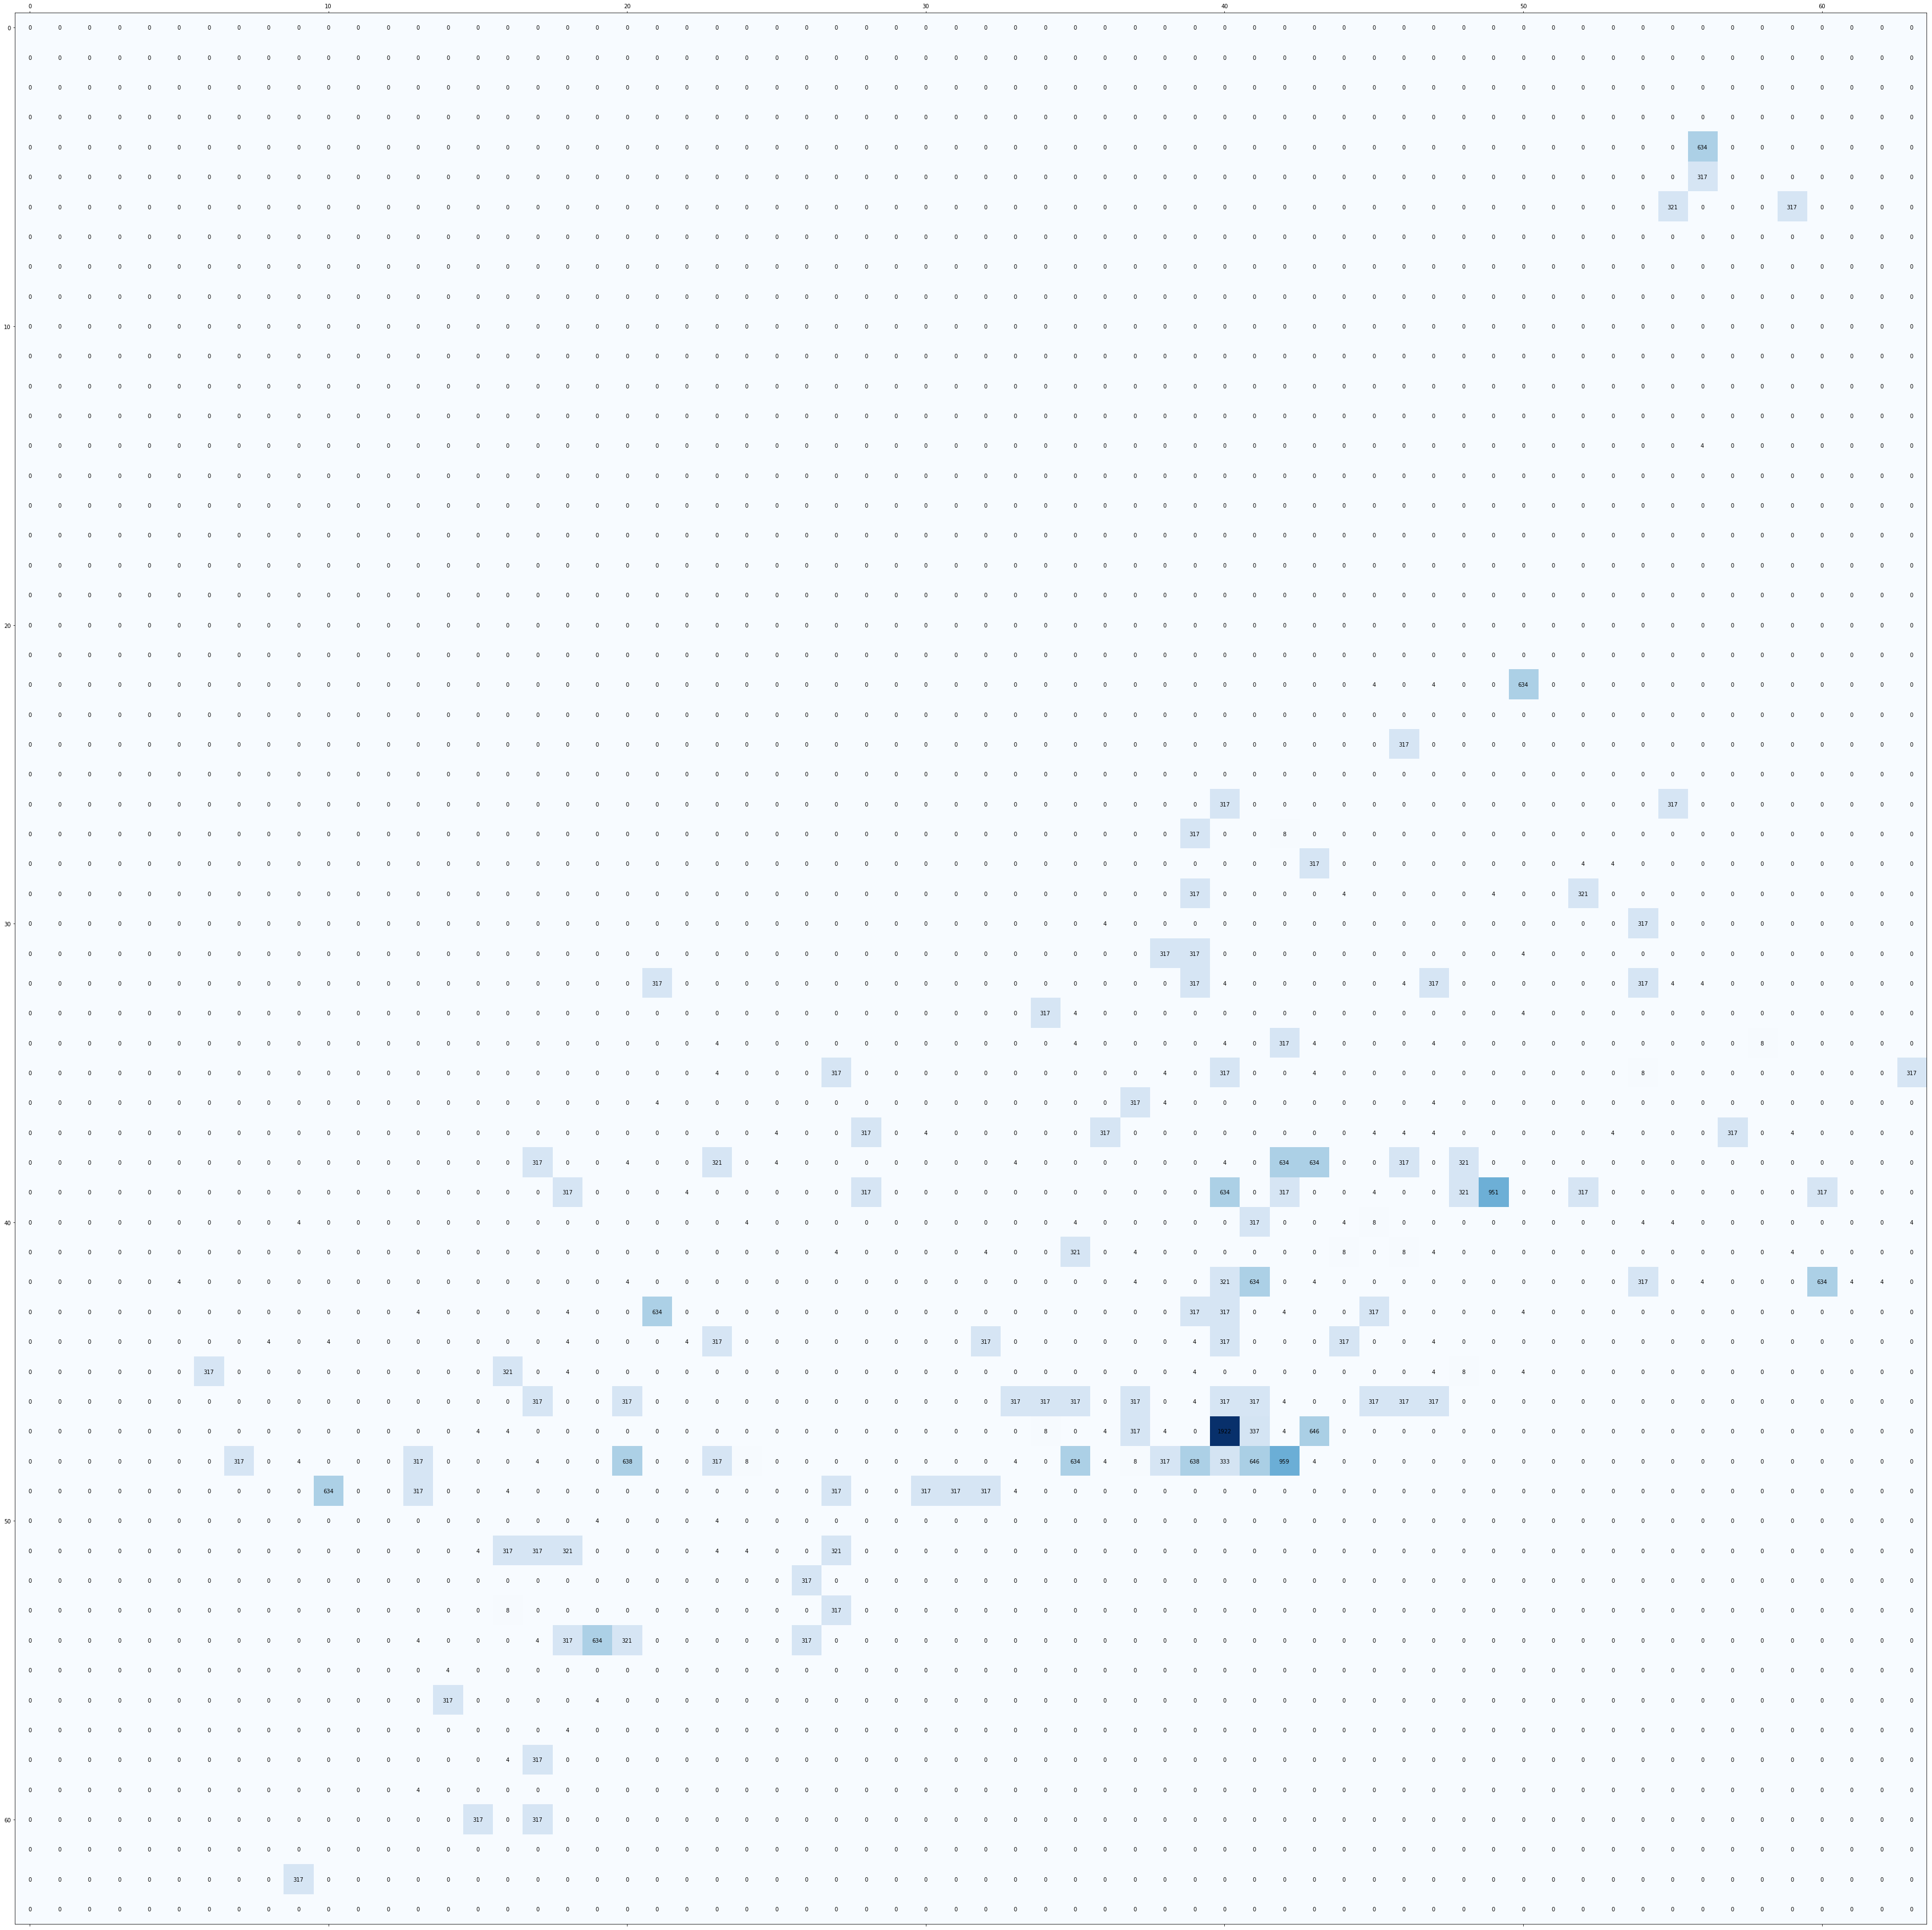

In [21]:
i1 = 0
i2 = 365
for year in years:
    print(year)
    mapofCrimes(str(year),64,Matrices3[i1:i2])
    i1 = i2
    i2 += 365

In [14]:
rank_matrix = createRankMatrix(64, Matrices3)

In [15]:
n_zeros = 0
n_nzeros = 0
rrc = 64

max_value = 0
for i in range(rrc):
    for j in range(rrc):
        if (rank_matrix[i][j] > max_value):
            max_value = rank_matrix[i][j]
print(max_value)

for i in range(rrc):
    for j in range(rrc):
        if (rank_matrix[i][j] == 0):
            n_zeros += 1
        else:
            n_nzeros += 1
            
print("n zeros =",n_zeros)
print("n no zeros =",n_nzeros)
print("%",(n_nzeros/(n_zeros+n_nzeros))*100)

7702
n zeros = 3693
n no zeros = 403
% 9.8388671875


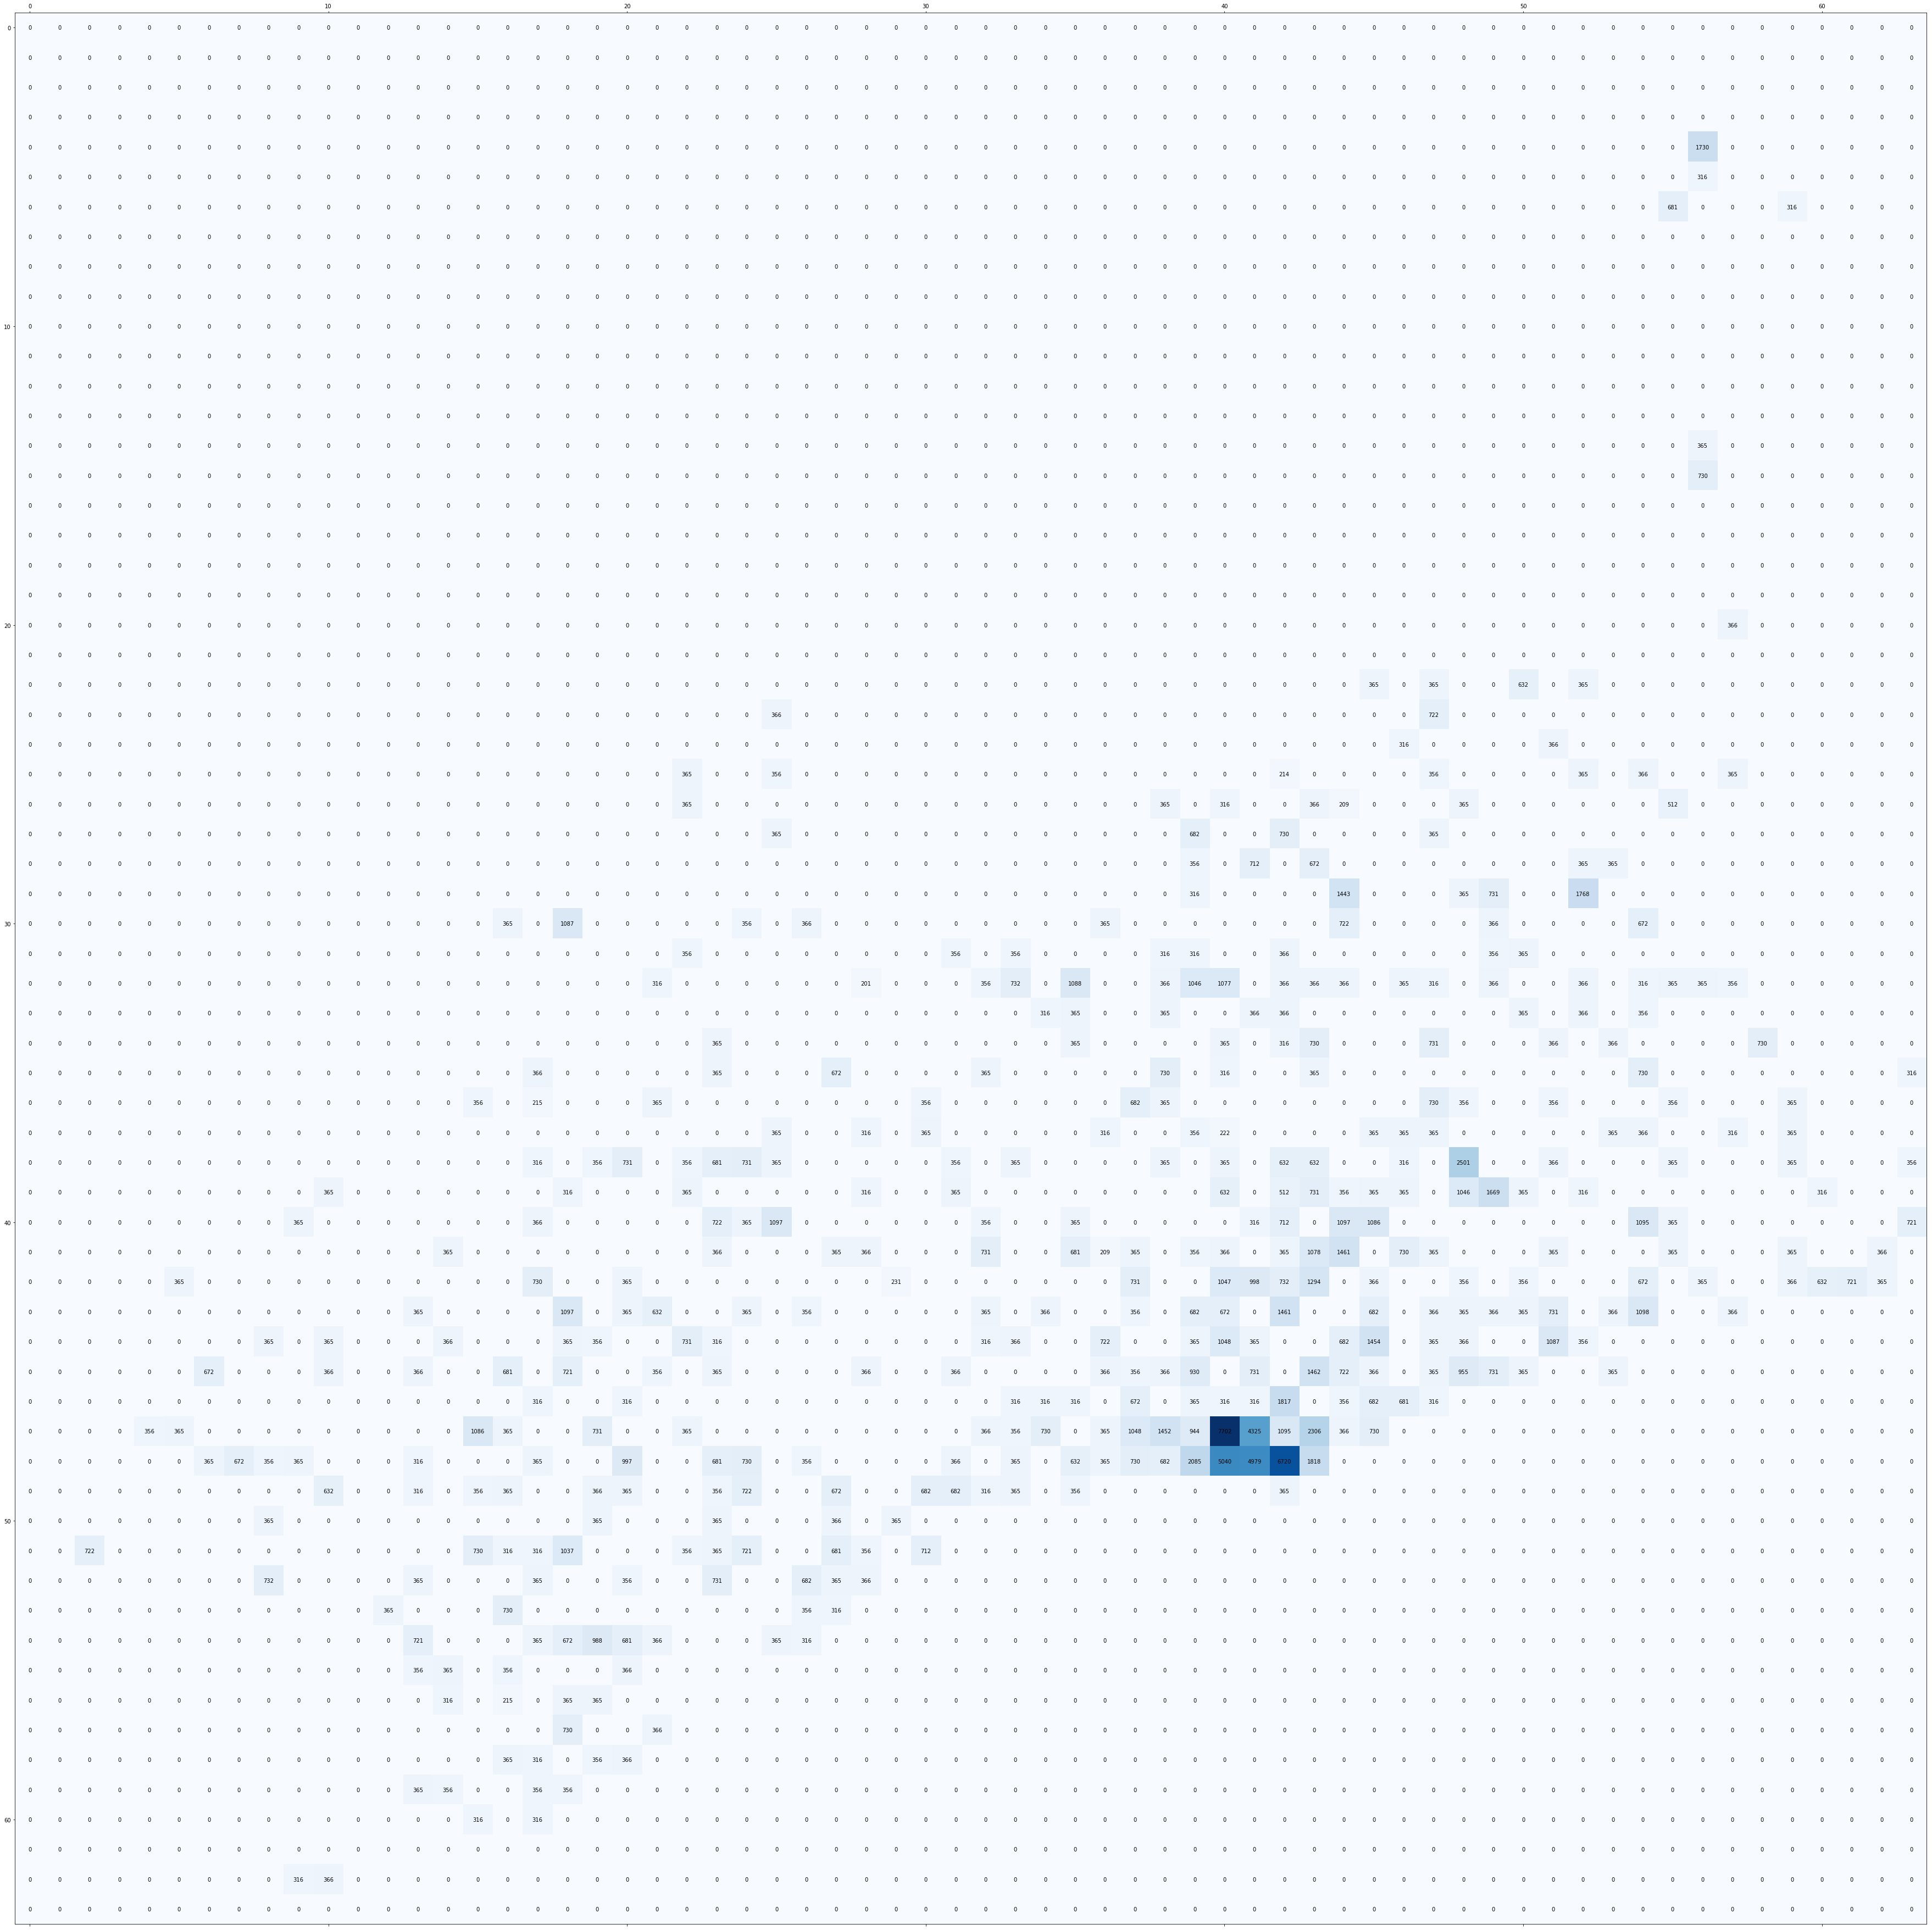

In [30]:
rrc = 64
fig, ax = plt.subplots()
fig.set_figheight(rrc)
fig.set_figwidth(rrc)
ax.matshow(rank_matrix, cmap=plt.cm.Blues)

for i in range(rrc):
    for j in range(rrc):
        c = rank_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

In [46]:
rank_matrixtest = rank_matrix[24:56,21:53]
rank_matrixtest.shape

(32, 32)

In [90]:
cut_matrix = []
n_matrices = len(Matrices3)
for i in range(n_matrices):
    cut_matrix.append(Matrices3[i][24:56,21:53])

In [91]:
import pickle
pickle_out = open("Matrices32x32cortadas.pickle","wb")
pickle.dump(cut_matrix,pickle_out)
pickle_out.close()

In [59]:
#Con 15 días anteriores y matrices cortadas
X3c_training, Y3c_training, X3c_test, Y3c_test = createTrainingTest(cut_matrix, 0.7, 15, 32, 32)

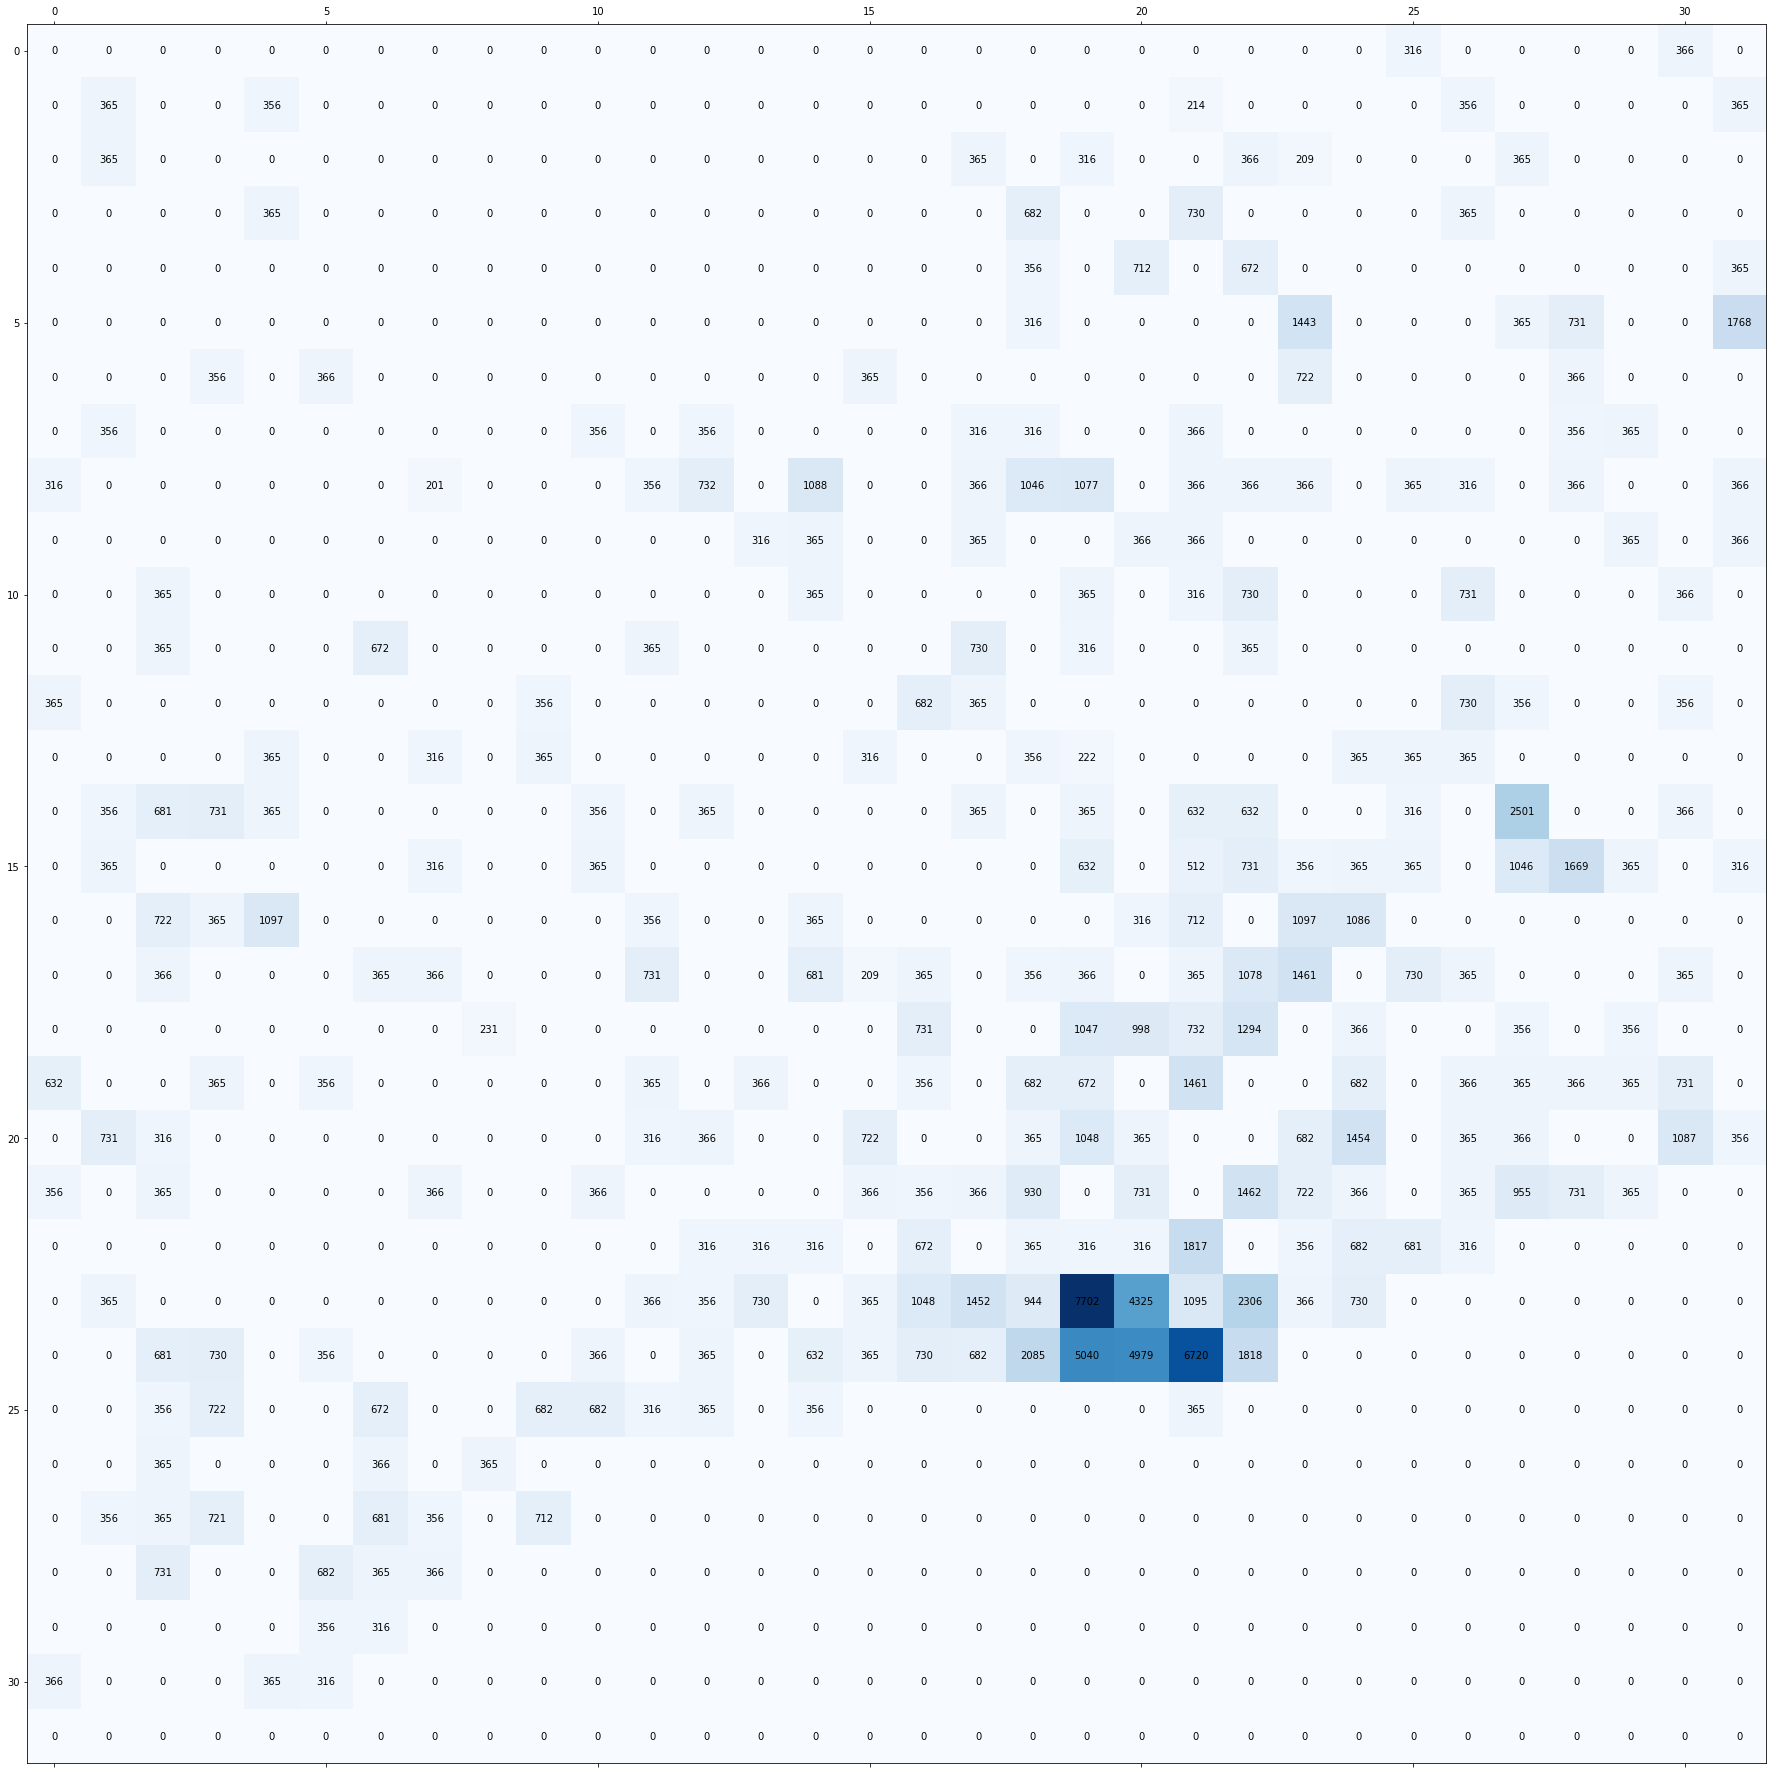

In [45]:
rrc = 32
fig, ax = plt.subplots()
fig.set_figheight(rrc)
fig.set_figwidth(rrc)
ax.matshow(rank_matrixtest, cmap=plt.cm.Blues)

for i in range(rrc):
    for j in range(rrc):
        c = rank_matrixtest[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

In [36]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D
from keras.layers.core import Layer, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers import TimeDistributed, LSTM
from keras.utils import plot_model

input_nn = Input(X3_training.shape[1:])
conv1_1 = TimeDistributed(Conv2D(32, (2,2), padding = 'same', activation='relu'))(input_nn)
conv1_2 = TimeDistributed(GlobalAveragePooling2D())(conv1_1)
dropout_1 = Dropout(0.5)(conv1_2)
lstm1_1 = LSTM(1024, activation='relu', return_sequences=False)(dropout_1)
output_nn = Dense(1024, activation='linear')(lstm1_1)

lstmtest = Model(inputs=input_nn, outputs=output_nn)
lstmtest.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15, 32, 32, 1)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 32, 32, 32)    160       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              4329472   
Total params: 4,329,632
Trainable params: 4,329,632
Non-trainable params: 0
_________________________________________________________________


In [61]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Flatten
from keras.layers.core import Layer, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import TimeDistributed, LSTM
from keras.utils import plot_model

input_nn = Input(X3c_training.shape[1:])
conv1_1 = TimeDistributed(Conv2D(64, (6, 6), activation='relu', padding='same'))(input_nn)
pool1 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(conv1_1)
conv1_2 = TimeDistributed(Conv2D(32, (6, 6), activation='relu', padding='same'))(pool1)
pool2 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(conv1_2)
conv1_3 = TimeDistributed(Conv2D(32, (6, 6), activation='relu', padding='same'))(pool2)
h = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(conv1_3)

# Decoder
conv2_1 = TimeDistributed(Conv2D(32, (6, 6), activation='relu', padding='same'))(h)
up1 = TimeDistributed(UpSampling2D((2, 2)))(conv2_1)
conv2_2 = TimeDistributed(Conv2D(32, (6, 6), activation='relu', padding='same'))(up1)
up2 = TimeDistributed(UpSampling2D((2, 2)))(conv2_2)
conv2_3 = TimeDistributed(Conv2D(64, (6, 6), activation='relu', padding='same'))(up2)
flatten_1 = Flatten()(conv2_3)
output_nn = Dense(1024, activation='linear')(flatten_1)

lstmtest = Model(inputs=input_nn, outputs=output_nn)
lstmtest.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 32, 32, 1)     0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 32, 32, 64)    2368      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 16, 16, 64)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 16, 16, 32)    73760     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 8, 8, 32)      0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 8, 8, 32)      36896     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 4, 4, 32)      0         
__________

In [110]:
plot_model(lstmtest, to_file='lstm_test.png', show_shapes=True, show_layer_names=True)

In [62]:
from keras import backend as K
def coeff_determination(y_true,y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

lstmtest.compile(loss=root_mean_squared_error,optimizer="adam",metrics=[coeff_determination,'mape','mae'])

In [63]:
#2Entrenamiento con 15 32x32 matrices cortadas
epochs = 200
batch_size = 30
history_15_32x32 = lstmtest.fit(X3c_training, Y3c_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X3c_test,Y3c_test))

Train on 3800 samples, validate on 1629 samples
Epoch 1/200
 - 35s - loss: 0.0514 - coeff_determination: 0.3091 - mean_absolute_percentage_error: 4090877.8113 - mean_absolute_error: 0.0064 - val_loss: 0.3290 - val_coeff_determination: 0.1830 - val_mean_absolute_percentage_error: 38528903.0129 - val_mean_absolute_error: 0.1081
Epoch 2/200
 - 24s - loss: 0.0385 - coeff_determination: 0.4885 - mean_absolute_percentage_error: 3094604.9419 - mean_absolute_error: 0.0047 - val_loss: 0.3629 - val_coeff_determination: 0.0660 - val_mean_absolute_percentage_error: 53705190.7477 - val_mean_absolute_error: 0.1268
Epoch 3/200
 - 24s - loss: 0.0339 - coeff_determination: 0.6162 - mean_absolute_percentage_error: 3871576.2128 - mean_absolute_error: 0.0052 - val_loss: 0.3297 - val_coeff_determination: 0.1924 - val_mean_absolute_percentage_error: 59108128.3020 - val_mean_absolute_error: 0.1300
Epoch 4/200
 - 24s - loss: 0.0306 - coeff_determination: 0.6296 - mean_absolute_percentage_error: 4174253.3250 -

 - 37s - loss: 0.0247 - coeff_determination: 0.6989 - mean_absolute_percentage_error: 2921391.4464 - mean_absolute_error: 0.0036 - val_loss: 0.3255 - val_coeff_determination: 0.2009 - val_mean_absolute_percentage_error: 34876665.6943 - val_mean_absolute_error: 0.1063
Epoch 31/200
 - 37s - loss: 0.0242 - coeff_determination: 0.5919 - mean_absolute_percentage_error: 2586865.5247 - mean_absolute_error: 0.0032 - val_loss: 0.3332 - val_coeff_determination: 0.1496 - val_mean_absolute_percentage_error: 50692980.2910 - val_mean_absolute_error: 0.1206
Epoch 32/200
 - 35s - loss: 0.0243 - coeff_determination: 0.4765 - mean_absolute_percentage_error: 2440773.3668 - mean_absolute_error: 0.0031 - val_loss: 0.3748 - val_coeff_determination: -7.3392e-02 - val_mean_absolute_percentage_error: 60393775.0718 - val_mean_absolute_error: 0.1305
Epoch 33/200
 - 37s - loss: 0.0248 - coeff_determination: 0.5928 - mean_absolute_percentage_error: 2903604.4194 - mean_absolute_error: 0.0036 - val_loss: 0.3273 - va

Epoch 59/200
 - 23s - loss: 0.0234 - coeff_determination: 0.7723 - mean_absolute_percentage_error: 2105253.5609 - mean_absolute_error: 0.0027 - val_loss: 0.3995 - val_coeff_determination: -2.4129e-01 - val_mean_absolute_percentage_error: 65944147.2330 - val_mean_absolute_error: 0.1368
Epoch 60/200
 - 23s - loss: 0.0238 - coeff_determination: 0.7203 - mean_absolute_percentage_error: 2384665.1372 - mean_absolute_error: 0.0030 - val_loss: 0.3738 - val_coeff_determination: -8.7409e-02 - val_mean_absolute_percentage_error: 58374385.1584 - val_mean_absolute_error: 0.1288
Epoch 61/200
 - 22s - loss: 0.0234 - coeff_determination: 0.7497 - mean_absolute_percentage_error: 1901528.5951 - mean_absolute_error: 0.0025 - val_loss: 0.3815 - val_coeff_determination: -1.4565e-01 - val_mean_absolute_percentage_error: 88721015.7716 - val_mean_absolute_error: 0.1611
Epoch 62/200
 - 22s - loss: 0.0234 - coeff_determination: 0.8039 - mean_absolute_percentage_error: 1768796.1135 - mean_absolute_error: 0.0024 

Epoch 88/200
 - 22s - loss: 0.0243 - coeff_determination: 0.6884 - mean_absolute_percentage_error: 2646947.7454 - mean_absolute_error: 0.0033 - val_loss: 0.3618 - val_coeff_determination: -3.6062e-02 - val_mean_absolute_percentage_error: 50453035.3039 - val_mean_absolute_error: 0.1207
Epoch 89/200
 - 22s - loss: 0.0230 - coeff_determination: 0.6161 - mean_absolute_percentage_error: 1950703.1211 - mean_absolute_error: 0.0025 - val_loss: 0.3596 - val_coeff_determination: -1.3676e-02 - val_mean_absolute_percentage_error: 48066699.7468 - val_mean_absolute_error: 0.1193
Epoch 90/200
 - 22s - loss: 0.0239 - coeff_determination: 0.6117 - mean_absolute_percentage_error: 2311378.8204 - mean_absolute_error: 0.0030 - val_loss: 0.3788 - val_coeff_determination: -1.4690e-01 - val_mean_absolute_percentage_error: 59555248.1215 - val_mean_absolute_error: 0.1293
Epoch 91/200
 - 22s - loss: 0.0234 - coeff_determination: 0.7439 - mean_absolute_percentage_error: 1855763.0204 - mean_absolute_error: 0.0025 

Epoch 117/200
 - 22s - loss: 0.0242 - coeff_determination: 0.7249 - mean_absolute_percentage_error: 1842033.5230 - mean_absolute_error: 0.0025 - val_loss: 0.3576 - val_coeff_determination: 0.0593 - val_mean_absolute_percentage_error: 16372040.2882 - val_mean_absolute_error: 0.0996
Epoch 118/200
 - 22s - loss: 0.0237 - coeff_determination: 0.7045 - mean_absolute_percentage_error: 1779429.2883 - mean_absolute_error: 0.0024 - val_loss: 0.3517 - val_coeff_determination: 0.0693 - val_mean_absolute_percentage_error: 12753439.7440 - val_mean_absolute_error: 0.0943
Epoch 119/200
 - 22s - loss: 0.0243 - coeff_determination: 0.6235 - mean_absolute_percentage_error: 2199793.8658 - mean_absolute_error: 0.0028 - val_loss: 0.3543 - val_coeff_determination: 0.0653 - val_mean_absolute_percentage_error: 11764371.4968 - val_mean_absolute_error: 0.0940
Epoch 120/200
 - 22s - loss: 0.0240 - coeff_determination: 0.6011 - mean_absolute_percentage_error: 2092487.9135 - mean_absolute_error: 0.0027 - val_loss:

Epoch 147/200
 - 22s - loss: 0.0237 - coeff_determination: 0.8014 - mean_absolute_percentage_error: 1604167.1056 - mean_absolute_error: 0.0022 - val_loss: 0.3536 - val_coeff_determination: 0.0683 - val_mean_absolute_percentage_error: 10651227.0092 - val_mean_absolute_error: 0.0928
Epoch 148/200
 - 22s - loss: 0.0231 - coeff_determination: 0.7735 - mean_absolute_percentage_error: 1544952.2010 - mean_absolute_error: 0.0021 - val_loss: 0.3522 - val_coeff_determination: 0.0653 - val_mean_absolute_percentage_error: 12761062.7477 - val_mean_absolute_error: 0.0944
Epoch 149/200
 - 22s - loss: 0.0236 - coeff_determination: 0.6576 - mean_absolute_percentage_error: 1562121.7893 - mean_absolute_error: 0.0022 - val_loss: 0.3512 - val_coeff_determination: 0.0736 - val_mean_absolute_percentage_error: 8794934.3711 - val_mean_absolute_error: 0.0905
Epoch 150/200
 - 23s - loss: 0.0238 - coeff_determination: 0.7256 - mean_absolute_percentage_error: 2046122.6546 - mean_absolute_error: 0.0026 - val_loss: 

Epoch 177/200
 - 23s - loss: 0.0231 - coeff_determination: 0.6682 - mean_absolute_percentage_error: 1770209.0107 - mean_absolute_error: 0.0023 - val_loss: 0.3512 - val_coeff_determination: 0.0728 - val_mean_absolute_percentage_error: 12498429.3407 - val_mean_absolute_error: 0.0940
Epoch 178/200
 - 23s - loss: 0.0233 - coeff_determination: 0.7249 - mean_absolute_percentage_error: 1728098.2266 - mean_absolute_error: 0.0023 - val_loss: 0.3519 - val_coeff_determination: 0.0694 - val_mean_absolute_percentage_error: 11977470.1363 - val_mean_absolute_error: 0.0936
Epoch 179/200
 - 23s - loss: 0.0237 - coeff_determination: 0.6281 - mean_absolute_percentage_error: 2295265.2359 - mean_absolute_error: 0.0029 - val_loss: 0.3529 - val_coeff_determination: 0.0650 - val_mean_absolute_percentage_error: 10873102.9383 - val_mean_absolute_error: 0.0928
Epoch 180/200
 - 23s - loss: 0.0228 - coeff_determination: 0.6199 - mean_absolute_percentage_error: 1505864.8827 - mean_absolute_error: 0.0021 - val_loss:

In [52]:
#2Entrenamiento con 15 32x32
epochs = 200
batch_size = 30
history_15_32x32 = lstmtest.fit(X3_training, Y3_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X3_test,Y3_test))

Train on 3800 samples, validate on 1629 samples
Epoch 1/200
 - 28s - loss: 0.0597 - coeff_determination: 0.2836 - mean_absolute_percentage_error: 5082879.0908 - mean_absolute_error: 0.0080 - val_loss: 0.4316 - val_coeff_determination: 0.3326 - val_mean_absolute_percentage_error: 65122274.5783 - val_mean_absolute_error: 0.1595
Epoch 2/200
 - 20s - loss: 0.0416 - coeff_determination: 0.4617 - mean_absolute_percentage_error: 3330436.2518 - mean_absolute_error: 0.0050 - val_loss: 0.4361 - val_coeff_determination: 0.3236 - val_mean_absolute_percentage_error: 68658277.5985 - val_mean_absolute_error: 0.1643
Epoch 3/200
 - 20s - loss: 0.0417 - coeff_determination: 0.5515 - mean_absolute_percentage_error: 3557259.5957 - mean_absolute_error: 0.0054 - val_loss: 0.4389 - val_coeff_determination: 0.3090 - val_mean_absolute_percentage_error: 68515237.2891 - val_mean_absolute_error: 0.1598
Epoch 4/200
 - 21s - loss: 0.0335 - coeff_determination: 0.5477 - mean_absolute_percentage_error: 3637734.4368 -

 - 21s - loss: 0.0303 - coeff_determination: 0.6393 - mean_absolute_percentage_error: 4017771.0184 - mean_absolute_error: 0.0049 - val_loss: 0.4294 - val_coeff_determination: 0.3062 - val_mean_absolute_percentage_error: 55982180.9982 - val_mean_absolute_error: 0.1509
Epoch 31/200
 - 21s - loss: 0.0287 - coeff_determination: 0.5120 - mean_absolute_percentage_error: 2998211.3770 - mean_absolute_error: 0.0038 - val_loss: 0.4330 - val_coeff_determination: 0.3080 - val_mean_absolute_percentage_error: 63506244.9355 - val_mean_absolute_error: 0.1611
Epoch 32/200
 - 21s - loss: 0.0286 - coeff_determination: 0.7453 - mean_absolute_percentage_error: 3103309.0138 - mean_absolute_error: 0.0040 - val_loss: 0.4257 - val_coeff_determination: 0.3212 - val_mean_absolute_percentage_error: 50001903.6796 - val_mean_absolute_error: 0.1460
Epoch 33/200
 - 20s - loss: 0.0282 - coeff_determination: 0.7373 - mean_absolute_percentage_error: 2425848.1812 - mean_absolute_error: 0.0032 - val_loss: 0.4353 - val_coe

Epoch 60/200
 - 22s - loss: 0.0275 - coeff_determination: 0.7298 - mean_absolute_percentage_error: 2473102.9668 - mean_absolute_error: 0.0033 - val_loss: 0.4588 - val_coeff_determination: 0.2040 - val_mean_absolute_percentage_error: 62892510.0847 - val_mean_absolute_error: 0.1601
Epoch 61/200
 - 21s - loss: 0.0292 - coeff_determination: 0.5922 - mean_absolute_percentage_error: 3854642.4941 - mean_absolute_error: 0.0047 - val_loss: 0.5012 - val_coeff_determination: 0.0715 - val_mean_absolute_percentage_error: 23107489.7072 - val_mean_absolute_error: 0.1385
Epoch 62/200
 - 21s - loss: 0.0320 - coeff_determination: 0.7502 - mean_absolute_percentage_error: 3806148.6957 - mean_absolute_error: 0.0049 - val_loss: 0.4625 - val_coeff_determination: 0.2060 - val_mean_absolute_percentage_error: 30876070.5608 - val_mean_absolute_error: 0.1321
Epoch 63/200
 - 21s - loss: 0.0276 - coeff_determination: 0.6927 - mean_absolute_percentage_error: 2515628.7049 - mean_absolute_error: 0.0033 - val_loss: 0.4

Epoch 90/200
 - 20s - loss: 0.0281 - coeff_determination: 0.6366 - mean_absolute_percentage_error: 3068605.1664 - mean_absolute_error: 0.0038 - val_loss: 0.4604 - val_coeff_determination: 0.2164 - val_mean_absolute_percentage_error: 36894726.8895 - val_mean_absolute_error: 0.1358
Epoch 91/200
 - 20s - loss: 0.0273 - coeff_determination: 0.6987 - mean_absolute_percentage_error: 1825682.0197 - mean_absolute_error: 0.0026 - val_loss: 0.4582 - val_coeff_determination: 0.2233 - val_mean_absolute_percentage_error: 24388213.2707 - val_mean_absolute_error: 0.1276
Epoch 92/200
 - 20s - loss: 0.0282 - coeff_determination: 0.7616 - mean_absolute_percentage_error: 1889594.2327 - mean_absolute_error: 0.0028 - val_loss: 0.4908 - val_coeff_determination: 0.1264 - val_mean_absolute_percentage_error: 9354908.4374 - val_mean_absolute_error: 0.1225
Epoch 93/200
 - 20s - loss: 0.0280 - coeff_determination: 0.7506 - mean_absolute_percentage_error: 1985083.3151 - mean_absolute_error: 0.0029 - val_loss: 0.46

Epoch 120/200
 - 21s - loss: 0.0270 - coeff_determination: 0.6238 - mean_absolute_percentage_error: 1915677.0885 - mean_absolute_error: 0.0027 - val_loss: 0.4609 - val_coeff_determination: 0.2044 - val_mean_absolute_percentage_error: 82554956.6998 - val_mean_absolute_error: 0.1712
Epoch 121/200
 - 21s - loss: 0.0275 - coeff_determination: 0.7341 - mean_absolute_percentage_error: 2293059.8391 - mean_absolute_error: 0.0030 - val_loss: 0.4623 - val_coeff_determination: 0.1769 - val_mean_absolute_percentage_error: 74053839.8048 - val_mean_absolute_error: 0.1634
Epoch 122/200
 - 21s - loss: 0.0274 - coeff_determination: 0.5523 - mean_absolute_percentage_error: 2020920.3951 - mean_absolute_error: 0.0028 - val_loss: 0.4721 - val_coeff_determination: 0.1346 - val_mean_absolute_percentage_error: 81266952.2873 - val_mean_absolute_error: 0.1695
Epoch 123/200
 - 20s - loss: 0.0277 - coeff_determination: 0.7846 - mean_absolute_percentage_error: 2655484.0365 - mean_absolute_error: 0.0034 - val_loss:

 - 21s - loss: 0.0270 - coeff_determination: 0.6935 - mean_absolute_percentage_error: 1834428.8285 - mean_absolute_error: 0.0026 - val_loss: 0.5046 - val_coeff_determination: 0.0164 - val_mean_absolute_percentage_error: 92214464.6777 - val_mean_absolute_error: 0.1871
Epoch 150/200
 - 22s - loss: 0.0266 - coeff_determination: 0.7124 - mean_absolute_percentage_error: 1978509.8161 - mean_absolute_error: 0.0027 - val_loss: 0.5023 - val_coeff_determination: 0.0220 - val_mean_absolute_percentage_error: 103595845.1308 - val_mean_absolute_error: 0.1994
Epoch 151/200
 - 22s - loss: 0.0269 - coeff_determination: 0.6721 - mean_absolute_percentage_error: 1669263.1418 - mean_absolute_error: 0.0024 - val_loss: 0.5151 - val_coeff_determination: -3.1127e-02 - val_mean_absolute_percentage_error: 112916847.1639 - val_mean_absolute_error: 0.2109
Epoch 152/200
 - 21s - loss: 0.0280 - coeff_determination: 0.7116 - mean_absolute_percentage_error: 2464287.6497 - mean_absolute_error: 0.0033 - val_loss: 0.4975

Epoch 179/200
 - 21s - loss: 0.0273 - coeff_determination: 0.5976 - mean_absolute_percentage_error: 2498830.0533 - mean_absolute_error: 0.0033 - val_loss: 0.4754 - val_coeff_determination: 0.1485 - val_mean_absolute_percentage_error: 64668421.6059 - val_mean_absolute_error: 0.1618
Epoch 180/200
 - 21s - loss: 0.0271 - coeff_determination: 0.6755 - mean_absolute_percentage_error: 2536743.8507 - mean_absolute_error: 0.0033 - val_loss: 0.4731 - val_coeff_determination: 0.1623 - val_mean_absolute_percentage_error: 58212044.0921 - val_mean_absolute_error: 0.1562
Epoch 181/200
 - 21s - loss: 0.0272 - coeff_determination: 0.4908 - mean_absolute_percentage_error: 1956689.6118 - mean_absolute_error: 0.0027 - val_loss: 0.4677 - val_coeff_determination: 0.1488 - val_mean_absolute_percentage_error: 96499917.5396 - val_mean_absolute_error: 0.1839
Epoch 182/200
 - 21s - loss: 0.0281 - coeff_determination: 0.6802 - mean_absolute_percentage_error: 3022870.4523 - mean_absolute_error: 0.0038 - val_loss:

In [29]:
#Entrenamiento con 15 32x32
epochs = 200
batch_size = 50
history_15_32x32 = lstmtest.fit(X3_training, Y3_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X3_test,Y3_test))

Instructions for updating:
Use tf.cast instead.
Train on 3800 samples, validate on 1629 samples
Epoch 1/200
 - 9s - loss: 0.1488 - coeff_determination: -9.1016e+00 - mean_absolute_percentage_error: 7721027.2889 - mean_absolute_error: 0.0154 - val_loss: 0.5331 - val_coeff_determination: 0.0477 - val_mean_absolute_percentage_error: 37266916.8398 - val_mean_absolute_error: 0.1590
Epoch 2/200
 - 3s - loss: 0.0732 - coeff_determination: 0.3884 - mean_absolute_percentage_error: 6678080.0691 - mean_absolute_error: 0.0103 - val_loss: 0.4527 - val_coeff_determination: 0.2909 - val_mean_absolute_percentage_error: 65837153.5666 - val_mean_absolute_error: 0.1581
Epoch 3/200
 - 3s - loss: 0.0472 - coeff_determination: 0.5865 - mean_absolute_percentage_error: 3114954.7368 - mean_absolute_error: 0.0052 - val_loss: 0.5123 - val_coeff_determination: 0.0263 - val_mean_absolute_percentage_error: 95621737.4831 - val_mean_absolute_error: 0.1871
Epoch 4/200
 - 3s - loss: 0.0410 - coeff_determination: 0.7342

Epoch 30/200
 - 3s - loss: 0.0360 - coeff_determination: 0.7466 - mean_absolute_percentage_error: 2749011.0461 - mean_absolute_error: 0.0038 - val_loss: 0.4580 - val_coeff_determination: 0.1880 - val_mean_absolute_percentage_error: 58410394.7133 - val_mean_absolute_error: 0.1432
Epoch 31/200
 - 3s - loss: 0.0359 - coeff_determination: 0.6441 - mean_absolute_percentage_error: 2843257.8668 - mean_absolute_error: 0.0039 - val_loss: 0.4729 - val_coeff_determination: 0.1277 - val_mean_absolute_percentage_error: 61992598.3990 - val_mean_absolute_error: 0.1477
Epoch 32/200
 - 3s - loss: 0.0358 - coeff_determination: 0.6495 - mean_absolute_percentage_error: 2390975.5905 - mean_absolute_error: 0.0035 - val_loss: 0.4617 - val_coeff_determination: 0.1672 - val_mean_absolute_percentage_error: 58600927.3616 - val_mean_absolute_error: 0.1429
Epoch 33/200
 - 3s - loss: 0.0361 - coeff_determination: 0.6511 - mean_absolute_percentage_error: 3752393.7878 - mean_absolute_error: 0.0048 - val_loss: 0.4634 

Epoch 60/200
 - 3s - loss: 0.0352 - coeff_determination: 0.5093 - mean_absolute_percentage_error: 2542981.4359 - mean_absolute_error: 0.0036 - val_loss: 0.4621 - val_coeff_determination: 0.1657 - val_mean_absolute_percentage_error: 60438600.2726 - val_mean_absolute_error: 0.1449
Epoch 61/200
 - 3s - loss: 0.0354 - coeff_determination: 0.6905 - mean_absolute_percentage_error: 2656539.5493 - mean_absolute_error: 0.0038 - val_loss: 0.4656 - val_coeff_determination: 0.1495 - val_mean_absolute_percentage_error: 59386993.3014 - val_mean_absolute_error: 0.1439
Epoch 62/200
 - 3s - loss: 0.0350 - coeff_determination: 0.5133 - mean_absolute_percentage_error: 2730368.7730 - mean_absolute_error: 0.0038 - val_loss: 0.4571 - val_coeff_determination: 0.1922 - val_mean_absolute_percentage_error: 57724373.4414 - val_mean_absolute_error: 0.1438
Epoch 63/200
 - 3s - loss: 0.0349 - coeff_determination: 0.6659 - mean_absolute_percentage_error: 2192944.2993 - mean_absolute_error: 0.0032 - val_loss: 0.4566 

Epoch 90/200
 - 3s - loss: 0.0345 - coeff_determination: 0.7729 - mean_absolute_percentage_error: 2180677.3372 - mean_absolute_error: 0.0032 - val_loss: 0.4635 - val_coeff_determination: 0.1568 - val_mean_absolute_percentage_error: 57342414.9865 - val_mean_absolute_error: 0.1417
Epoch 91/200
 - 3s - loss: 0.0347 - coeff_determination: 0.6080 - mean_absolute_percentage_error: 2162590.9951 - mean_absolute_error: 0.0032 - val_loss: 0.4623 - val_coeff_determination: 0.1657 - val_mean_absolute_percentage_error: 58798939.2548 - val_mean_absolute_error: 0.1432
Epoch 92/200
 - 3s - loss: 0.0333 - coeff_determination: 0.5716 - mean_absolute_percentage_error: 2012200.2204 - mean_absolute_error: 0.0030 - val_loss: 0.4687 - val_coeff_determination: 0.1404 - val_mean_absolute_percentage_error: 61197748.3241 - val_mean_absolute_error: 0.1462
Epoch 93/200
 - 3s - loss: 0.0338 - coeff_determination: 0.6366 - mean_absolute_percentage_error: 2120977.4720 - mean_absolute_error: 0.0031 - val_loss: 0.4602 

Epoch 120/200
 - 3s - loss: 0.0325 - coeff_determination: 0.7284 - mean_absolute_percentage_error: 2176981.4424 - mean_absolute_error: 0.0031 - val_loss: 0.4630 - val_coeff_determination: 0.1636 - val_mean_absolute_percentage_error: 56842245.7655 - val_mean_absolute_error: 0.1416
Epoch 121/200
 - 3s - loss: 0.0327 - coeff_determination: 0.8224 - mean_absolute_percentage_error: 1861262.4688 - mean_absolute_error: 0.0028 - val_loss: 0.4726 - val_coeff_determination: 0.1304 - val_mean_absolute_percentage_error: 60865715.3947 - val_mean_absolute_error: 0.1465
Epoch 122/200
 - 3s - loss: 0.0331 - coeff_determination: 0.7572 - mean_absolute_percentage_error: 2191374.7812 - mean_absolute_error: 0.0031 - val_loss: 0.4538 - val_coeff_determination: 0.2138 - val_mean_absolute_percentage_error: 55040470.1031 - val_mean_absolute_error: 0.1416
Epoch 123/200
 - 3s - loss: 0.0331 - coeff_determination: 0.7561 - mean_absolute_percentage_error: 2275875.5987 - mean_absolute_error: 0.0033 - val_loss: 0.4

Epoch 150/200
 - 3s - loss: 0.0320 - coeff_determination: 0.8437 - mean_absolute_percentage_error: 2011246.0066 - mean_absolute_error: 0.0029 - val_loss: 0.4620 - val_coeff_determination: 0.1697 - val_mean_absolute_percentage_error: 57828373.4708 - val_mean_absolute_error: 0.1427
Epoch 151/200
 - 3s - loss: 0.0322 - coeff_determination: 0.6288 - mean_absolute_percentage_error: 2125175.8717 - mean_absolute_error: 0.0030 - val_loss: 0.4688 - val_coeff_determination: 0.1432 - val_mean_absolute_percentage_error: 61602630.1940 - val_mean_absolute_error: 0.1468
Epoch 152/200
 - 3s - loss: 0.0325 - coeff_determination: 0.8135 - mean_absolute_percentage_error: 2143215.7451 - mean_absolute_error: 0.0031 - val_loss: 0.4619 - val_coeff_determination: 0.1681 - val_mean_absolute_percentage_error: 59338371.7201 - val_mean_absolute_error: 0.1439
Epoch 153/200
 - 3s - loss: 0.0318 - coeff_determination: 0.6567 - mean_absolute_percentage_error: 1754220.0066 - mean_absolute_error: 0.0027 - val_loss: 0.4

Epoch 180/200
 - 3s - loss: 0.0318 - coeff_determination: 0.7264 - mean_absolute_percentage_error: 2051721.8174 - mean_absolute_error: 0.0030 - val_loss: 0.4724 - val_coeff_determination: 0.1318 - val_mean_absolute_percentage_error: 62087841.3235 - val_mean_absolute_error: 0.1477
Epoch 181/200
 - 3s - loss: 0.0310 - coeff_determination: 0.7412 - mean_absolute_percentage_error: 1797293.9030 - mean_absolute_error: 0.0027 - val_loss: 0.4649 - val_coeff_determination: 0.1567 - val_mean_absolute_percentage_error: 58480959.6808 - val_mean_absolute_error: 0.1434
Epoch 182/200
 - 3s - loss: 0.0309 - coeff_determination: 0.7496 - mean_absolute_percentage_error: 1627846.2418 - mean_absolute_error: 0.0025 - val_loss: 0.4580 - val_coeff_determination: 0.1921 - val_mean_absolute_percentage_error: 55847665.3174 - val_mean_absolute_error: 0.1409
Epoch 183/200
 - 3s - loss: 0.0315 - coeff_determination: 0.6948 - mean_absolute_percentage_error: 1756302.2944 - mean_absolute_error: 0.0027 - val_loss: 0.4

In [12]:
#Entrenamiento con 15
epochs = 200
batch_size = 50
history_1 = lstmtest.fit(X3_training, Y3_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X3_test,Y3_test))

Instructions for updating:
Use tf.cast instead.
Train on 4857 samples, validate on 2082 samples
Epoch 1/200
 - 46s - loss: 0.0136 - coeff_determination: 0.0358 - mean_absolute_percentage_error: 453252.5820 - mean_absolute_error: 6.3865e-04 - val_loss: 0.1975 - val_coeff_determination: -1.2821e+05 - val_mean_absolute_percentage_error: 320501.9770 - val_mean_absolute_error: 0.0276
Epoch 2/200
 - 25s - loss: 0.0136 - coeff_determination: 0.0397 - mean_absolute_percentage_error: 319541.9357 - mean_absolute_error: 5.0448e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6502e+05 - val_mean_absolute_percentage_error: 374920.9656 - val_mean_absolute_error: 0.0276
Epoch 3/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0395 - mean_absolute_percentage_error: 281494.9537 - mean_absolute_error: 4.6640e-04 - val_loss: 0.1974 - val_coeff_determination: -1.3322e+05 - val_mean_absolute_percentage_error: 317098.9358 - val_mean_absolute_error: 0.0276
Epoch 4/200
 - 25s - loss: 0.0136 - coeff_dete

Epoch 29/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0408 - mean_absolute_percentage_error: 184859.9034 - mean_absolute_error: 3.6946e-04 - val_loss: 0.1974 - val_coeff_determination: -1.4999e+05 - val_mean_absolute_percentage_error: 296654.3581 - val_mean_absolute_error: 0.0276
Epoch 30/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0405 - mean_absolute_percentage_error: 181658.5944 - mean_absolute_error: 3.6645e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6337e+05 - val_mean_absolute_percentage_error: 301324.2894 - val_mean_absolute_error: 0.0276
Epoch 31/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0406 - mean_absolute_percentage_error: 183050.7932 - mean_absolute_error: 3.6776e-04 - val_loss: 0.1974 - val_coeff_determination: -1.5607e+05 - val_mean_absolute_percentage_error: 298334.8575 - val_mean_absolute_error: 0.0276
Epoch 32/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0406 - mean_absolute_percentage_error: 181406.1189 - mean_absolute_error: 3.662

Epoch 58/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0407 - mean_absolute_percentage_error: 185037.0453 - mean_absolute_error: 3.6983e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6653e+05 - val_mean_absolute_percentage_error: 304533.1948 - val_mean_absolute_error: 0.0276
Epoch 59/200
 - 24s - loss: 0.0135 - coeff_determination: 0.0404 - mean_absolute_percentage_error: 186088.8719 - mean_absolute_error: 3.7079e-04 - val_loss: 0.1974 - val_coeff_determination: -1.5767e+05 - val_mean_absolute_percentage_error: 300456.8930 - val_mean_absolute_error: 0.0276
Epoch 60/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0405 - mean_absolute_percentage_error: 185383.3669 - mean_absolute_error: 3.7011e-04 - val_loss: 0.1974 - val_coeff_determination: -1.5740e+05 - val_mean_absolute_percentage_error: 300267.6724 - val_mean_absolute_error: 0.0276
Epoch 61/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0407 - mean_absolute_percentage_error: 184735.1989 - mean_absolute_error: 3.694

Epoch 87/200
 - 26s - loss: 0.0136 - coeff_determination: 0.0408 - mean_absolute_percentage_error: 185871.9639 - mean_absolute_error: 3.7053e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6337e+05 - val_mean_absolute_percentage_error: 303028.5523 - val_mean_absolute_error: 0.0276
Epoch 88/200
 - 27s - loss: 0.0136 - coeff_determination: 0.0408 - mean_absolute_percentage_error: 184819.6853 - mean_absolute_error: 3.6956e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6269e+05 - val_mean_absolute_percentage_error: 301884.6114 - val_mean_absolute_error: 0.0276
Epoch 89/200
 - 26s - loss: 0.0136 - coeff_determination: 0.0406 - mean_absolute_percentage_error: 183147.1041 - mean_absolute_error: 3.6797e-04 - val_loss: 0.1974 - val_coeff_determination: -1.7173e+05 - val_mean_absolute_percentage_error: 305745.9557 - val_mean_absolute_error: 0.0276
Epoch 90/200
 - 25s - loss: 0.0136 - coeff_determination: 0.0404 - mean_absolute_percentage_error: 187306.7525 - mean_absolute_error: 3.719

Epoch 116/200
 - 25s - loss: 0.0136 - coeff_determination: 0.0406 - mean_absolute_percentage_error: 184566.4925 - mean_absolute_error: 3.6928e-04 - val_loss: 0.1974 - val_coeff_determination: -1.5919e+05 - val_mean_absolute_percentage_error: 302647.4079 - val_mean_absolute_error: 0.0276
Epoch 117/200
 - 25s - loss: 0.0136 - coeff_determination: 0.0406 - mean_absolute_percentage_error: 184496.4173 - mean_absolute_error: 3.6927e-04 - val_loss: 0.1974 - val_coeff_determination: -1.5986e+05 - val_mean_absolute_percentage_error: 301201.2076 - val_mean_absolute_error: 0.0276
Epoch 118/200
 - 27s - loss: 0.0136 - coeff_determination: 0.0411 - mean_absolute_percentage_error: 183720.2903 - mean_absolute_error: 3.6850e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6674e+05 - val_mean_absolute_percentage_error: 304484.0781 - val_mean_absolute_error: 0.0276
Epoch 119/200
 - 27s - loss: 0.0136 - coeff_determination: 0.0408 - mean_absolute_percentage_error: 186799.3856 - mean_absolute_error: 3

Epoch 145/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0407 - mean_absolute_percentage_error: 183688.1435 - mean_absolute_error: 3.6846e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6230e+05 - val_mean_absolute_percentage_error: 301006.6891 - val_mean_absolute_error: 0.0276
Epoch 146/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0405 - mean_absolute_percentage_error: 184156.9646 - mean_absolute_error: 3.6893e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6758e+05 - val_mean_absolute_percentage_error: 303680.1724 - val_mean_absolute_error: 0.0276
Epoch 147/200
 - 25s - loss: 0.0136 - coeff_determination: 0.0407 - mean_absolute_percentage_error: 184260.6433 - mean_absolute_error: 3.6899e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6529e+05 - val_mean_absolute_percentage_error: 303225.1434 - val_mean_absolute_error: 0.0276
Epoch 148/200
 - 27s - loss: 0.0136 - coeff_determination: 0.0406 - mean_absolute_percentage_error: 184987.7559 - mean_absolute_error: 3

Epoch 174/200
 - 28s - loss: 0.0136 - coeff_determination: 0.0407 - mean_absolute_percentage_error: 183414.8174 - mean_absolute_error: 3.6824e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6058e+05 - val_mean_absolute_percentage_error: 300193.8858 - val_mean_absolute_error: 0.0276
Epoch 175/200
 - 28s - loss: 0.0136 - coeff_determination: 0.0407 - mean_absolute_percentage_error: 185663.1887 - mean_absolute_error: 3.7033e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6490e+05 - val_mean_absolute_percentage_error: 303175.6526 - val_mean_absolute_error: 0.0276
Epoch 176/200
 - 28s - loss: 0.0135 - coeff_determination: 0.0403 - mean_absolute_percentage_error: 185195.3625 - mean_absolute_error: 3.6990e-04 - val_loss: 0.1974 - val_coeff_determination: -1.6233e+05 - val_mean_absolute_percentage_error: 303035.5098 - val_mean_absolute_error: 0.0276
Epoch 177/200
 - 24s - loss: 0.0136 - coeff_determination: 0.0408 - mean_absolute_percentage_error: 184800.0304 - mean_absolute_error: 3

In [33]:
#Entrenamiento con 2
epochs = 10
batch_size = 32
history_1 = lstmtest.fit(X1_training, Y1_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X1_test,Y1_test))

Train on 3147 samples, validate on 1347 samples
Epoch 1/10
 - 5s - loss: 0.2303 - coeff_determination: -1.8948e-01 - mean_absolute_percentage_error: 6155375.7711 - mean_absolute_error: 0.0099 - val_loss: 0.3017 - val_coeff_determination: 0.8471 - val_mean_absolute_percentage_error: 122044986.7498 - val_mean_absolute_error: 0.1332
Epoch 2/10
 - 2s - loss: 0.0551 - coeff_determination: 0.9312 - mean_absolute_percentage_error: 6931724.2943 - mean_absolute_error: 0.0079 - val_loss: 0.1967 - val_coeff_determination: 0.9316 - val_mean_absolute_percentage_error: 16141957.7639 - val_mean_absolute_error: 0.0250
Epoch 3/10
 - 2s - loss: 0.0449 - coeff_determination: 0.9504 - mean_absolute_percentage_error: 2914756.7037 - mean_absolute_error: 0.0037 - val_loss: 0.2206 - val_coeff_determination: 0.9159 - val_mean_absolute_percentage_error: 26506907.7491 - val_mean_absolute_error: 0.0363
Epoch 4/10
 - 2s - loss: 0.0415 - coeff_determination: 0.9648 - mean_absolute_percentage_error: 3036814.2267 - m

In [14]:
#Entrenando con 7
epochs = 1000
batch_size = 30
history_2 = lstmtest.fit(X2_training, Y2_training, batch_size=batch_size, epochs=epochs, verbose=2,validation_data=(X2_test,Y2_test))

Instructions for updating:
Use tf.cast instead.
Train on 3150 samples, validate on 1350 samples
Epoch 1/1000
 - 7s - loss: 0.0657 - coeff_determination: 0.3423 - mean_absolute_percentage_error: 5700330.4642 - mean_absolute_error: 0.0088 - val_loss: 0.2610 - val_coeff_determination: -3.8809e-01 - val_mean_absolute_percentage_error: 28858252.1333 - val_mean_absolute_error: 0.0568
Epoch 2/1000
 - 3s - loss: 0.0396 - coeff_determination: 0.7450 - mean_absolute_percentage_error: 2003070.0821 - mean_absolute_error: 0.0034 - val_loss: 0.2232 - val_coeff_determination: -2.1773e-02 - val_mean_absolute_percentage_error: 18623110.3111 - val_mean_absolute_error: 0.0458
Epoch 3/1000
 - 3s - loss: 0.0381 - coeff_determination: 0.7676 - mean_absolute_percentage_error: 1758266.3964 - mean_absolute_error: 0.0031 - val_loss: 0.2315 - val_coeff_determination: -1.1162e-01 - val_mean_absolute_percentage_error: 20637563.5556 - val_mean_absolute_error: 0.0476
Epoch 4/1000
 - 3s - loss: 0.0374 - coeff_determi

Epoch 29/1000
 - 4s - loss: 0.0209 - coeff_determination: 0.9140 - mean_absolute_percentage_error: 906336.5833 - mean_absolute_error: 0.0015 - val_loss: 0.1994 - val_coeff_determination: -6.3851e-02 - val_mean_absolute_percentage_error: 20961330.5889 - val_mean_absolute_error: 0.0427
Epoch 30/1000
 - 4s - loss: 0.0210 - coeff_determination: 0.9169 - mean_absolute_percentage_error: 1084592.6548 - mean_absolute_error: 0.0017 - val_loss: 0.2022 - val_coeff_determination: -9.8444e-02 - val_mean_absolute_percentage_error: 23920787.7333 - val_mean_absolute_error: 0.0454
Epoch 31/1000
 - 4s - loss: 0.0215 - coeff_determination: 0.9147 - mean_absolute_percentage_error: 1649781.3244 - mean_absolute_error: 0.0023 - val_loss: 0.2021 - val_coeff_determination: -1.0191e-01 - val_mean_absolute_percentage_error: 21383468.4778 - val_mean_absolute_error: 0.0427
Epoch 32/1000
 - 4s - loss: 0.0201 - coeff_determination: 0.9310 - mean_absolute_percentage_error: 1109991.9786 - mean_absolute_error: 0.0016 -

Epoch 58/1000
 - 4s - loss: 0.0189 - coeff_determination: 0.9384 - mean_absolute_percentage_error: 1398599.8101 - mean_absolute_error: 0.0018 - val_loss: 0.2072 - val_coeff_determination: -1.6848e-01 - val_mean_absolute_percentage_error: 24202913.3111 - val_mean_absolute_error: 0.0455
Epoch 59/1000
 - 4s - loss: 0.0185 - coeff_determination: 0.9272 - mean_absolute_percentage_error: 1021700.9804 - mean_absolute_error: 0.0015 - val_loss: 0.1937 - val_coeff_determination: -3.8756e-02 - val_mean_absolute_percentage_error: 19114927.9917 - val_mean_absolute_error: 0.0404
Epoch 60/1000
 - 4s - loss: 0.0190 - coeff_determination: 0.9299 - mean_absolute_percentage_error: 660306.4714 - mean_absolute_error: 0.0011 - val_loss: 0.2022 - val_coeff_determination: -1.2276e-01 - val_mean_absolute_percentage_error: 20369662.0333 - val_mean_absolute_error: 0.0420
Epoch 61/1000
 - 4s - loss: 0.0190 - coeff_determination: 0.8978 - mean_absolute_percentage_error: 658461.7345 - mean_absolute_error: 0.0011 - 

Epoch 87/1000
 - 4s - loss: 0.0177 - coeff_determination: 0.9259 - mean_absolute_percentage_error: 641372.2461 - mean_absolute_error: 0.0010 - val_loss: 0.2050 - val_coeff_determination: -1.6151e-01 - val_mean_absolute_percentage_error: 19926216.6917 - val_mean_absolute_error: 0.0412
Epoch 88/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9356 - mean_absolute_percentage_error: 695239.3140 - mean_absolute_error: 0.0011 - val_loss: 0.2043 - val_coeff_determination: -1.4687e-01 - val_mean_absolute_percentage_error: 19770498.4222 - val_mean_absolute_error: 0.0412
Epoch 89/1000
 - 4s - loss: 0.0174 - coeff_determination: 0.9335 - mean_absolute_percentage_error: 601995.5878 - mean_absolute_error: 9.5549e-04 - val_loss: 0.2110 - val_coeff_determination: -2.2230e-01 - val_mean_absolute_percentage_error: 21569359.8722 - val_mean_absolute_error: 0.0431
Epoch 90/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9408 - mean_absolute_percentage_error: 701130.9220 - mean_absolute_error: 0.0011 

Epoch 116/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9368 - mean_absolute_percentage_error: 587651.5571 - mean_absolute_error: 9.3289e-04 - val_loss: 0.2063 - val_coeff_determination: -1.5196e-01 - val_mean_absolute_percentage_error: 20176835.3444 - val_mean_absolute_error: 0.0418
Epoch 117/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9518 - mean_absolute_percentage_error: 573702.2539 - mean_absolute_error: 9.2708e-04 - val_loss: 0.2030 - val_coeff_determination: -1.4529e-01 - val_mean_absolute_percentage_error: 19932676.8472 - val_mean_absolute_error: 0.0411
Epoch 118/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9418 - mean_absolute_percentage_error: 727966.0497 - mean_absolute_error: 0.0011 - val_loss: 0.2014 - val_coeff_determination: -1.2810e-01 - val_mean_absolute_percentage_error: 19112274.4361 - val_mean_absolute_error: 0.0403
Epoch 119/1000
 - 3s - loss: 0.0171 - coeff_determination: 0.9357 - mean_absolute_percentage_error: 527104.2676 - mean_absolute_error:

Epoch 145/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9343 - mean_absolute_percentage_error: 1029387.5363 - mean_absolute_error: 0.0013 - val_loss: 0.2050 - val_coeff_determination: -1.6663e-01 - val_mean_absolute_percentage_error: 20339491.5611 - val_mean_absolute_error: 0.0415
Epoch 146/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9498 - mean_absolute_percentage_error: 632935.6426 - mean_absolute_error: 9.5441e-04 - val_loss: 0.2071 - val_coeff_determination: -1.7613e-01 - val_mean_absolute_percentage_error: 20085338.5500 - val_mean_absolute_error: 0.0416
Epoch 147/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9305 - mean_absolute_percentage_error: 494573.2065 - mean_absolute_error: 8.1869e-04 - val_loss: 0.2028 - val_coeff_determination: -1.3945e-01 - val_mean_absolute_percentage_error: 18795697.7312 - val_mean_absolute_error: 0.0401
Epoch 148/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9469 - mean_absolute_percentage_error: 475016.4851 - mean_absolute_error

Epoch 174/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9512 - mean_absolute_percentage_error: 537062.3610 - mean_absolute_error: 8.7618e-04 - val_loss: 0.2037 - val_coeff_determination: -1.5570e-01 - val_mean_absolute_percentage_error: 19989942.6944 - val_mean_absolute_error: 0.0412
Epoch 175/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9417 - mean_absolute_percentage_error: 599546.5018 - mean_absolute_error: 9.4569e-04 - val_loss: 0.2048 - val_coeff_determination: -1.6196e-01 - val_mean_absolute_percentage_error: 21033541.7389 - val_mean_absolute_error: 0.0423
Epoch 176/1000
 - 4s - loss: 0.0175 - coeff_determination: 0.9332 - mean_absolute_percentage_error: 837198.4655 - mean_absolute_error: 0.0012 - val_loss: 0.2047 - val_coeff_determination: -1.6407e-01 - val_mean_absolute_percentage_error: 19925692.0306 - val_mean_absolute_error: 0.0411
Epoch 177/1000
 - 4s - loss: 0.0167 - coeff_determination: 0.9467 - mean_absolute_percentage_error: 501126.5476 - mean_absolute_error:

Epoch 203/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9462 - mean_absolute_percentage_error: 629644.3092 - mean_absolute_error: 9.5196e-04 - val_loss: 0.2047 - val_coeff_determination: -1.6326e-01 - val_mean_absolute_percentage_error: 19098874.3340 - val_mean_absolute_error: 0.0403
Epoch 204/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9380 - mean_absolute_percentage_error: 616257.5381 - mean_absolute_error: 9.5410e-04 - val_loss: 0.2018 - val_coeff_determination: -1.3051e-01 - val_mean_absolute_percentage_error: 18956447.0111 - val_mean_absolute_error: 0.0402
Epoch 205/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9339 - mean_absolute_percentage_error: 596036.8339 - mean_absolute_error: 9.4403e-04 - val_loss: 0.1998 - val_coeff_determination: -1.2092e-01 - val_mean_absolute_percentage_error: 18752020.5236 - val_mean_absolute_error: 0.0398
Epoch 206/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9435 - mean_absolute_percentage_error: 481526.7042 - mean_absolute_er

Epoch 232/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9099 - mean_absolute_percentage_error: 448134.3244 - mean_absolute_error: 7.5613e-04 - val_loss: 0.2055 - val_coeff_determination: -1.7474e-01 - val_mean_absolute_percentage_error: 19262199.4736 - val_mean_absolute_error: 0.0405
Epoch 233/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9427 - mean_absolute_percentage_error: 495981.2902 - mean_absolute_error: 8.5143e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6358e-01 - val_mean_absolute_percentage_error: 19087180.2361 - val_mean_absolute_error: 0.0403
Epoch 234/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9470 - mean_absolute_percentage_error: 471375.4455 - mean_absolute_error: 7.8846e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6450e-01 - val_mean_absolute_percentage_error: 19035042.9826 - val_mean_absolute_error: 0.0402
Epoch 235/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9507 - mean_absolute_percentage_error: 415081.8744 - mean_absolute_er

Epoch 261/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9357 - mean_absolute_percentage_error: 513795.5054 - mean_absolute_error: 8.3311e-04 - val_loss: 0.2055 - val_coeff_determination: -1.6218e-01 - val_mean_absolute_percentage_error: 20184095.5472 - val_mean_absolute_error: 0.0416
Epoch 262/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9370 - mean_absolute_percentage_error: 570635.0354 - mean_absolute_error: 8.8267e-04 - val_loss: 0.2053 - val_coeff_determination: -1.6120e-01 - val_mean_absolute_percentage_error: 20720523.9056 - val_mean_absolute_error: 0.0420
Epoch 263/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9460 - mean_absolute_percentage_error: 553339.7167 - mean_absolute_error: 8.6407e-04 - val_loss: 0.2048 - val_coeff_determination: -1.6765e-01 - val_mean_absolute_percentage_error: 19275027.0500 - val_mean_absolute_error: 0.0405
Epoch 264/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9239 - mean_absolute_percentage_error: 437376.0244 - mean_absolute_er

Epoch 290/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9432 - mean_absolute_percentage_error: 588931.8310 - mean_absolute_error: 9.0941e-04 - val_loss: 0.2070 - val_coeff_determination: -1.8382e-01 - val_mean_absolute_percentage_error: 19905445.3944 - val_mean_absolute_error: 0.0412
Epoch 291/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9166 - mean_absolute_percentage_error: 755630.6131 - mean_absolute_error: 0.0011 - val_loss: 0.2059 - val_coeff_determination: -1.5776e-01 - val_mean_absolute_percentage_error: 21295775.8111 - val_mean_absolute_error: 0.0429
Epoch 292/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9347 - mean_absolute_percentage_error: 649211.9708 - mean_absolute_error: 9.7825e-04 - val_loss: 0.2035 - val_coeff_determination: -1.5027e-01 - val_mean_absolute_percentage_error: 19378297.2389 - val_mean_absolute_error: 0.0406
Epoch 293/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9413 - mean_absolute_percentage_error: 547635.6482 - mean_absolute_error:

Epoch 319/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9287 - mean_absolute_percentage_error: 406597.7908 - mean_absolute_error: 7.3057e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6474e-01 - val_mean_absolute_percentage_error: 18936437.9924 - val_mean_absolute_error: 0.0401
Epoch 320/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9353 - mean_absolute_percentage_error: 403021.2899 - mean_absolute_error: 7.0668e-04 - val_loss: 0.2037 - val_coeff_determination: -1.4691e-01 - val_mean_absolute_percentage_error: 19214304.0792 - val_mean_absolute_error: 0.0405
Epoch 321/1000
 - 4s - loss: 0.0178 - coeff_determination: 0.9383 - mean_absolute_percentage_error: 537895.4202 - mean_absolute_error: 8.8246e-04 - val_loss: 0.1934 - val_coeff_determination: -5.9937e-02 - val_mean_absolute_percentage_error: 18412830.3903 - val_mean_absolute_error: 0.0393
Epoch 322/1000
 - 4s - loss: 0.0182 - coeff_determination: 0.9334 - mean_absolute_percentage_error: 658741.9396 - mean_absolute_er

Epoch 348/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9520 - mean_absolute_percentage_error: 434388.3196 - mean_absolute_error: 7.6743e-04 - val_loss: 0.2054 - val_coeff_determination: -1.6768e-01 - val_mean_absolute_percentage_error: 19018150.4757 - val_mean_absolute_error: 0.0403
Epoch 349/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9356 - mean_absolute_percentage_error: 447569.5369 - mean_absolute_error: 7.8349e-04 - val_loss: 0.1966 - val_coeff_determination: -8.6320e-02 - val_mean_absolute_percentage_error: 17722624.8132 - val_mean_absolute_error: 0.0388
Epoch 350/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9497 - mean_absolute_percentage_error: 486098.8137 - mean_absolute_error: 8.1022e-04 - val_loss: 0.2053 - val_coeff_determination: -1.6571e-01 - val_mean_absolute_percentage_error: 20322188.3944 - val_mean_absolute_error: 0.0416
Epoch 351/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9533 - mean_absolute_percentage_error: 590809.4074 - mean_absolute_er

Epoch 377/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9382 - mean_absolute_percentage_error: 436400.0836 - mean_absolute_error: 7.6478e-04 - val_loss: 0.2059 - val_coeff_determination: -1.7562e-01 - val_mean_absolute_percentage_error: 19213355.1528 - val_mean_absolute_error: 0.0405
Epoch 378/1000
 - 4s - loss: 0.0177 - coeff_determination: 0.9324 - mean_absolute_percentage_error: 465672.6813 - mean_absolute_error: 8.3072e-04 - val_loss: 0.2057 - val_coeff_determination: -1.7285e-01 - val_mean_absolute_percentage_error: 19132084.8250 - val_mean_absolute_error: 0.0404
Epoch 379/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9289 - mean_absolute_percentage_error: 448702.3955 - mean_absolute_error: 7.8461e-04 - val_loss: 0.2044 - val_coeff_determination: -1.6010e-01 - val_mean_absolute_percentage_error: 19027176.5847 - val_mean_absolute_error: 0.0402
Epoch 380/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9294 - mean_absolute_percentage_error: 396552.2765 - mean_absolute_er

Epoch 406/1000
 - 4s - loss: 0.0173 - coeff_determination: 0.9270 - mean_absolute_percentage_error: 436411.5530 - mean_absolute_error: 7.7432e-04 - val_loss: 0.2039 - val_coeff_determination: -1.5632e-01 - val_mean_absolute_percentage_error: 19100030.4493 - val_mean_absolute_error: 0.0404
Epoch 407/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9491 - mean_absolute_percentage_error: 396657.4542 - mean_absolute_error: 7.0878e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6396e-01 - val_mean_absolute_percentage_error: 19013341.5806 - val_mean_absolute_error: 0.0402
Epoch 408/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9398 - mean_absolute_percentage_error: 443509.9107 - mean_absolute_error: 7.6205e-04 - val_loss: 0.2047 - val_coeff_determination: -1.6624e-01 - val_mean_absolute_percentage_error: 18930733.9187 - val_mean_absolute_error: 0.0401
Epoch 409/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9505 - mean_absolute_percentage_error: 440633.7699 - mean_absolute_er

Epoch 435/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9474 - mean_absolute_percentage_error: 427489.1411 - mean_absolute_error: 7.5023e-04 - val_loss: 0.2051 - val_coeff_determination: -1.6819e-01 - val_mean_absolute_percentage_error: 19215180.6229 - val_mean_absolute_error: 0.0404
Epoch 436/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9443 - mean_absolute_percentage_error: 480067.5426 - mean_absolute_error: 8.0359e-04 - val_loss: 0.2020 - val_coeff_determination: -1.4069e-01 - val_mean_absolute_percentage_error: 17629837.5819 - val_mean_absolute_error: 0.0388
Epoch 437/1000
 - 4s - loss: 0.0194 - coeff_determination: 0.9199 - mean_absolute_percentage_error: 771463.0435 - mean_absolute_error: 0.0012 - val_loss: 0.2030 - val_coeff_determination: -1.4735e-01 - val_mean_absolute_percentage_error: 19243251.5875 - val_mean_absolute_error: 0.0405
Epoch 438/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9307 - mean_absolute_percentage_error: 504534.8232 - mean_absolute_error:

Epoch 464/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9306 - mean_absolute_percentage_error: 394008.8949 - mean_absolute_error: 7.1275e-04 - val_loss: 0.2043 - val_coeff_determination: -1.6256e-01 - val_mean_absolute_percentage_error: 18944001.0576 - val_mean_absolute_error: 0.0401
Epoch 465/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9436 - mean_absolute_percentage_error: 383730.5223 - mean_absolute_error: 6.9034e-04 - val_loss: 0.2047 - val_coeff_determination: -1.6771e-01 - val_mean_absolute_percentage_error: 18940353.0007 - val_mean_absolute_error: 0.0401
Epoch 466/1000
 - 4s - loss: 0.0177 - coeff_determination: 0.9409 - mean_absolute_percentage_error: 444522.1726 - mean_absolute_error: 7.9946e-04 - val_loss: 0.2035 - val_coeff_determination: -1.5434e-01 - val_mean_absolute_percentage_error: 18889755.9375 - val_mean_absolute_error: 0.0400
Epoch 467/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9530 - mean_absolute_percentage_error: 369052.3262 - mean_absolute_er

Epoch 493/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9359 - mean_absolute_percentage_error: 451983.0113 - mean_absolute_error: 7.7303e-04 - val_loss: 0.1954 - val_coeff_determination: -8.1098e-02 - val_mean_absolute_percentage_error: 17801379.7792 - val_mean_absolute_error: 0.0388
Epoch 494/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9431 - mean_absolute_percentage_error: 465401.1068 - mean_absolute_error: 7.9276e-04 - val_loss: 0.2053 - val_coeff_determination: -1.7206e-01 - val_mean_absolute_percentage_error: 19376580.1250 - val_mean_absolute_error: 0.0406
Epoch 495/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9525 - mean_absolute_percentage_error: 506845.5619 - mean_absolute_error: 8.3432e-04 - val_loss: 0.2052 - val_coeff_determination: -1.6940e-01 - val_mean_absolute_percentage_error: 19347658.0722 - val_mean_absolute_error: 0.0406
Epoch 496/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9436 - mean_absolute_percentage_error: 389852.3952 - mean_absolute_er

Epoch 522/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9489 - mean_absolute_percentage_error: 398859.7589 - mean_absolute_error: 7.2086e-04 - val_loss: 0.2027 - val_coeff_determination: -1.4768e-01 - val_mean_absolute_percentage_error: 18765659.6361 - val_mean_absolute_error: 0.0399
Epoch 523/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9500 - mean_absolute_percentage_error: 353547.0494 - mean_absolute_error: 6.6307e-04 - val_loss: 0.1976 - val_coeff_determination: -9.5387e-02 - val_mean_absolute_percentage_error: 18394080.9438 - val_mean_absolute_error: 0.0395
Epoch 524/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9502 - mean_absolute_percentage_error: 418182.3887 - mean_absolute_error: 7.4303e-04 - val_loss: 0.1942 - val_coeff_determination: -7.0796e-02 - val_mean_absolute_percentage_error: 18374986.6833 - val_mean_absolute_error: 0.0393
Epoch 525/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9382 - mean_absolute_percentage_error: 501804.2360 - mean_absolute_er

Epoch 551/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9510 - mean_absolute_percentage_error: 454077.3935 - mean_absolute_error: 7.7395e-04 - val_loss: 0.1964 - val_coeff_determination: -9.0578e-02 - val_mean_absolute_percentage_error: 17665207.5403 - val_mean_absolute_error: 0.0387
Epoch 552/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9447 - mean_absolute_percentage_error: 677292.2827 - mean_absolute_error: 0.0010 - val_loss: 0.2054 - val_coeff_determination: -1.6874e-01 - val_mean_absolute_percentage_error: 20633283.4556 - val_mean_absolute_error: 0.0418
Epoch 553/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9522 - mean_absolute_percentage_error: 612892.1423 - mean_absolute_error: 9.2245e-04 - val_loss: 0.2054 - val_coeff_determination: -1.7534e-01 - val_mean_absolute_percentage_error: 19155559.3444 - val_mean_absolute_error: 0.0403
Epoch 554/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9373 - mean_absolute_percentage_error: 475800.1818 - mean_absolute_error:

Epoch 580/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9370 - mean_absolute_percentage_error: 427653.7583 - mean_absolute_error: 7.2771e-04 - val_loss: 0.2050 - val_coeff_determination: -1.6796e-01 - val_mean_absolute_percentage_error: 19180966.2444 - val_mean_absolute_error: 0.0404
Epoch 581/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9451 - mean_absolute_percentage_error: 509081.9661 - mean_absolute_error: 8.1727e-04 - val_loss: 0.2050 - val_coeff_determination: -1.6958e-01 - val_mean_absolute_percentage_error: 19234917.3097 - val_mean_absolute_error: 0.0404
Epoch 582/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9303 - mean_absolute_percentage_error: 644301.8390 - mean_absolute_error: 9.5938e-04 - val_loss: 0.2059 - val_coeff_determination: -1.6958e-01 - val_mean_absolute_percentage_error: 20136768.2889 - val_mean_absolute_error: 0.0414
Epoch 583/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9435 - mean_absolute_percentage_error: 880402.0455 - mean_absolute_er

Epoch 609/1000
 - 4s - loss: 0.0174 - coeff_determination: 0.9127 - mean_absolute_percentage_error: 568862.2521 - mean_absolute_error: 9.3254e-04 - val_loss: 0.2069 - val_coeff_determination: -1.7947e-01 - val_mean_absolute_percentage_error: 21023133.2000 - val_mean_absolute_error: 0.0424
Epoch 610/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9512 - mean_absolute_percentage_error: 591000.9792 - mean_absolute_error: 9.2402e-04 - val_loss: 0.2076 - val_coeff_determination: -1.9311e-01 - val_mean_absolute_percentage_error: 19976926.0083 - val_mean_absolute_error: 0.0414
Epoch 611/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9370 - mean_absolute_percentage_error: 535904.7973 - mean_absolute_error: 8.5407e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6039e-01 - val_mean_absolute_percentage_error: 19930449.0278 - val_mean_absolute_error: 0.0411
Epoch 612/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9523 - mean_absolute_percentage_error: 472182.2577 - mean_absolute_er

Epoch 638/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9212 - mean_absolute_percentage_error: 437931.9399 - mean_absolute_error: 7.6477e-04 - val_loss: 0.2047 - val_coeff_determination: -1.6630e-01 - val_mean_absolute_percentage_error: 19007669.0819 - val_mean_absolute_error: 0.0402
Epoch 639/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9453 - mean_absolute_percentage_error: 439284.5179 - mean_absolute_error: 7.5442e-04 - val_loss: 0.2043 - val_coeff_determination: -1.5929e-01 - val_mean_absolute_percentage_error: 20103563.5083 - val_mean_absolute_error: 0.0413
Epoch 640/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9431 - mean_absolute_percentage_error: 574563.4601 - mean_absolute_error: 8.7646e-04 - val_loss: 0.2052 - val_coeff_determination: -1.6693e-01 - val_mean_absolute_percentage_error: 19859549.6222 - val_mean_absolute_error: 0.0411
Epoch 641/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9361 - mean_absolute_percentage_error: 627903.5792 - mean_absolute_er

Epoch 667/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9226 - mean_absolute_percentage_error: 534025.7033 - mean_absolute_error: 8.4392e-04 - val_loss: 0.2050 - val_coeff_determination: -1.6933e-01 - val_mean_absolute_percentage_error: 19509774.3972 - val_mean_absolute_error: 0.0407
Epoch 668/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9364 - mean_absolute_percentage_error: 587320.8926 - mean_absolute_error: 9.0710e-04 - val_loss: 0.2055 - val_coeff_determination: -1.7308e-01 - val_mean_absolute_percentage_error: 19671949.5389 - val_mean_absolute_error: 0.0409
Epoch 669/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9435 - mean_absolute_percentage_error: 605141.1176 - mean_absolute_error: 9.3325e-04 - val_loss: 0.2052 - val_coeff_determination: -1.6940e-01 - val_mean_absolute_percentage_error: 19877009.2222 - val_mean_absolute_error: 0.0411
Epoch 670/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9311 - mean_absolute_percentage_error: 604255.5607 - mean_absolute_er

Epoch 696/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9410 - mean_absolute_percentage_error: 404702.7199 - mean_absolute_error: 7.1234e-04 - val_loss: 0.2047 - val_coeff_determination: -1.6610e-01 - val_mean_absolute_percentage_error: 18830861.3837 - val_mean_absolute_error: 0.0400
Epoch 697/1000
 - 4s - loss: 0.0174 - coeff_determination: 0.9350 - mean_absolute_percentage_error: 431489.6232 - mean_absolute_error: 7.7197e-04 - val_loss: 0.2041 - val_coeff_determination: -1.6151e-01 - val_mean_absolute_percentage_error: 18913742.8031 - val_mean_absolute_error: 0.0401
Epoch 698/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9412 - mean_absolute_percentage_error: 441016.8768 - mean_absolute_error: 7.4690e-04 - val_loss: 0.2040 - val_coeff_determination: -1.5833e-01 - val_mean_absolute_percentage_error: 19021621.9542 - val_mean_absolute_error: 0.0402
Epoch 699/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9429 - mean_absolute_percentage_error: 548009.7801 - mean_absolute_er

Epoch 725/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9348 - mean_absolute_percentage_error: 379169.2723 - mean_absolute_error: 7.0089e-04 - val_loss: 0.2014 - val_coeff_determination: -1.3402e-01 - val_mean_absolute_percentage_error: 17216006.5785 - val_mean_absolute_error: 0.0384
Epoch 726/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9352 - mean_absolute_percentage_error: 373858.6045 - mean_absolute_error: 6.9103e-04 - val_loss: 0.2029 - val_coeff_determination: -1.5042e-01 - val_mean_absolute_percentage_error: 17459752.9528 - val_mean_absolute_error: 0.0387
Epoch 727/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9531 - mean_absolute_percentage_error: 365628.3542 - mean_absolute_error: 6.7237e-04 - val_loss: 0.2070 - val_coeff_determination: -1.8531e-01 - val_mean_absolute_percentage_error: 19240357.9889 - val_mean_absolute_error: 0.0406
Epoch 728/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9357 - mean_absolute_percentage_error: 481959.6167 - mean_absolute_er

Epoch 754/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9129 - mean_absolute_percentage_error: 406465.0265 - mean_absolute_error: 7.1724e-04 - val_loss: 0.2045 - val_coeff_determination: -1.5612e-01 - val_mean_absolute_percentage_error: 19396237.4528 - val_mean_absolute_error: 0.0407
Epoch 755/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9447 - mean_absolute_percentage_error: 415919.5598 - mean_absolute_error: 7.5214e-04 - val_loss: 0.2049 - val_coeff_determination: -1.6987e-01 - val_mean_absolute_percentage_error: 19015680.0063 - val_mean_absolute_error: 0.0402
Epoch 756/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9463 - mean_absolute_percentage_error: 407572.9946 - mean_absolute_error: 7.3501e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6331e-01 - val_mean_absolute_percentage_error: 19207120.4653 - val_mean_absolute_error: 0.0405
Epoch 757/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9502 - mean_absolute_percentage_error: 520979.5024 - mean_absolute_er

Epoch 783/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9448 - mean_absolute_percentage_error: 542417.7688 - mean_absolute_error: 8.5542e-04 - val_loss: 0.2053 - val_coeff_determination: -1.6773e-01 - val_mean_absolute_percentage_error: 20029112.1750 - val_mean_absolute_error: 0.0412
Epoch 784/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9519 - mean_absolute_percentage_error: 518112.6750 - mean_absolute_error: 8.5841e-04 - val_loss: 0.2050 - val_coeff_determination: -1.2206e-01 - val_mean_absolute_percentage_error: 17900932.1333 - val_mean_absolute_error: 0.0398
Epoch 785/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9445 - mean_absolute_percentage_error: 425500.1679 - mean_absolute_error: 7.3655e-04 - val_loss: 0.1930 - val_coeff_determination: -6.1846e-02 - val_mean_absolute_percentage_error: 17776889.0764 - val_mean_absolute_error: 0.0387
Epoch 786/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9458 - mean_absolute_percentage_error: 397899.9777 - mean_absolute_er

Epoch 812/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9294 - mean_absolute_percentage_error: 372580.2643 - mean_absolute_error: 6.7803e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6529e-01 - val_mean_absolute_percentage_error: 18893754.3590 - val_mean_absolute_error: 0.0401
Epoch 813/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9213 - mean_absolute_percentage_error: 373861.6554 - mean_absolute_error: 6.7319e-04 - val_loss: 0.2045 - val_coeff_determination: -1.6342e-01 - val_mean_absolute_percentage_error: 19273388.1208 - val_mean_absolute_error: 0.0404
Epoch 814/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9455 - mean_absolute_percentage_error: 711797.9598 - mean_absolute_error: 0.0010 - val_loss: 0.2048 - val_coeff_determination: -1.6566e-01 - val_mean_absolute_percentage_error: 19739346.1014 - val_mean_absolute_error: 0.0409
Epoch 815/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9401 - mean_absolute_percentage_error: 667163.7259 - mean_absolute_error:

Epoch 841/1000
 - 3s - loss: 0.0168 - coeff_determination: 0.9322 - mean_absolute_percentage_error: 421414.8616 - mean_absolute_error: 7.2366e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6577e-01 - val_mean_absolute_percentage_error: 19145953.8014 - val_mean_absolute_error: 0.0403
Epoch 842/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9326 - mean_absolute_percentage_error: 397580.9170 - mean_absolute_error: 6.9684e-04 - val_loss: 0.2046 - val_coeff_determination: -1.6710e-01 - val_mean_absolute_percentage_error: 18918316.8552 - val_mean_absolute_error: 0.0401
Epoch 843/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9364 - mean_absolute_percentage_error: 372204.3277 - mean_absolute_error: 6.8217e-04 - val_loss: 0.2030 - val_coeff_determination: -1.4725e-01 - val_mean_absolute_percentage_error: 18763165.2083 - val_mean_absolute_error: 0.0400
Epoch 844/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9379 - mean_absolute_percentage_error: 374902.2991 - mean_absolute_er

Epoch 870/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9430 - mean_absolute_percentage_error: 457691.1807 - mean_absolute_error: 8.1966e-04 - val_loss: 0.2050 - val_coeff_determination: -1.7018e-01 - val_mean_absolute_percentage_error: 19217686.9090 - val_mean_absolute_error: 0.0404
Epoch 871/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9356 - mean_absolute_percentage_error: 542433.4054 - mean_absolute_error: 8.5758e-04 - val_loss: 0.2037 - val_coeff_determination: -1.4999e-01 - val_mean_absolute_percentage_error: 19649435.7833 - val_mean_absolute_error: 0.0408
Epoch 872/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9445 - mean_absolute_percentage_error: 528096.0851 - mean_absolute_error: 8.4371e-04 - val_loss: 0.2066 - val_coeff_determination: -1.7794e-01 - val_mean_absolute_percentage_error: 19891233.9056 - val_mean_absolute_error: 0.0412
Epoch 873/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9500 - mean_absolute_percentage_error: 578531.7955 - mean_absolute_er

Epoch 899/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9455 - mean_absolute_percentage_error: 412447.5711 - mean_absolute_error: 7.1953e-04 - val_loss: 0.2051 - val_coeff_determination: -1.7158e-01 - val_mean_absolute_percentage_error: 19132034.6174 - val_mean_absolute_error: 0.0403
Epoch 900/1000
 - 4s - loss: 0.0172 - coeff_determination: 0.9275 - mean_absolute_percentage_error: 431522.5202 - mean_absolute_error: 7.6507e-04 - val_loss: 0.2036 - val_coeff_determination: -1.4965e-01 - val_mean_absolute_percentage_error: 19208754.6681 - val_mean_absolute_error: 0.0405
Epoch 901/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9482 - mean_absolute_percentage_error: 509449.4542 - mean_absolute_error: 8.3150e-04 - val_loss: 0.2052 - val_coeff_determination: -1.7123e-01 - val_mean_absolute_percentage_error: 19397631.0125 - val_mean_absolute_error: 0.0406
Epoch 902/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9370 - mean_absolute_percentage_error: 447461.9598 - mean_absolute_er

Epoch 928/1000
 - 4s - loss: 0.0170 - coeff_determination: 0.9213 - mean_absolute_percentage_error: 477670.2652 - mean_absolute_error: 8.0587e-04 - val_loss: 0.2045 - val_coeff_determination: -1.6203e-01 - val_mean_absolute_percentage_error: 19496968.6056 - val_mean_absolute_error: 0.0407
Epoch 929/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9420 - mean_absolute_percentage_error: 409066.9676 - mean_absolute_error: 7.2784e-04 - val_loss: 0.2047 - val_coeff_determination: -1.6688e-01 - val_mean_absolute_percentage_error: 18891078.3691 - val_mean_absolute_error: 0.0401
Epoch 930/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9418 - mean_absolute_percentage_error: 411056.3923 - mean_absolute_error: 7.2413e-04 - val_loss: 0.2048 - val_coeff_determination: -1.6451e-01 - val_mean_absolute_percentage_error: 18934991.4361 - val_mean_absolute_error: 0.0401
Epoch 931/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9492 - mean_absolute_percentage_error: 401750.9917 - mean_absolute_er

Epoch 957/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9422 - mean_absolute_percentage_error: 428548.2955 - mean_absolute_error: 7.5253e-04 - val_loss: 0.2051 - val_coeff_determination: -1.7132e-01 - val_mean_absolute_percentage_error: 19151290.3701 - val_mean_absolute_error: 0.0404
Epoch 958/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9348 - mean_absolute_percentage_error: 457188.8417 - mean_absolute_error: 7.7033e-04 - val_loss: 0.2053 - val_coeff_determination: -1.6771e-01 - val_mean_absolute_percentage_error: 19691182.8361 - val_mean_absolute_error: 0.0410
Epoch 959/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9416 - mean_absolute_percentage_error: 452822.6369 - mean_absolute_error: 7.7207e-04 - val_loss: 0.2053 - val_coeff_determination: -1.7178e-01 - val_mean_absolute_percentage_error: 19406934.3833 - val_mean_absolute_error: 0.0406
Epoch 960/1000
 - 4s - loss: 0.0169 - coeff_determination: 0.9492 - mean_absolute_percentage_error: 444876.6470 - mean_absolute_er

Epoch 986/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9477 - mean_absolute_percentage_error: 434249.6658 - mean_absolute_error: 7.3609e-04 - val_loss: 0.2045 - val_coeff_determination: -1.6415e-01 - val_mean_absolute_percentage_error: 19143690.0361 - val_mean_absolute_error: 0.0403
Epoch 987/1000
 - 4s - loss: 0.0171 - coeff_determination: 0.9414 - mean_absolute_percentage_error: 587921.8086 - mean_absolute_error: 9.0350e-04 - val_loss: 0.2055 - val_coeff_determination: -1.7127e-01 - val_mean_absolute_percentage_error: 19874652.1583 - val_mean_absolute_error: 0.0411
Epoch 988/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9392 - mean_absolute_percentage_error: 491345.0024 - mean_absolute_error: 7.9627e-04 - val_loss: 0.2048 - val_coeff_determination: -1.6226e-01 - val_mean_absolute_percentage_error: 19158987.9597 - val_mean_absolute_error: 0.0404
Epoch 989/1000
 - 4s - loss: 0.0168 - coeff_determination: 0.9522 - mean_absolute_percentage_error: 398104.2601 - mean_absolute_er

In [19]:
#Cargar modelo h5
from keras import backend as K
from keras.models import load_model
def coeff_determination(y_true,y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
from keras.models import load_model
lstmtest2 = load_model('lstmtest2.h5',custom_objects={'root_mean_squared_error': root_mean_squared_error, 'coeff_determination':coeff_determination})

In [18]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history_1.history, file_pi)

In [17]:
hist_df = pd.DataFrame(history_1.history) 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [54]:
lstmtest.save("lstmtest32x32.h5")

In [70]:
decoded_grids = lstmtest.predict(X3c_test)

In [27]:
import pickle
pickle_out = open("decoded_grids_xxx.pickle","wb")
pickle.dump(decoded_grids,pickle_out)
pickle_out.close()

In [17]:
import pickle
pickle_in = open("decoded_grids_2.pickle","rb")
decoded_grids_2 = pickle.load(pickle_in)

In [71]:
#Métrica
List_pred = []
List_test = []

for i in range(len(Y3c_test)):
    m1_p = np.squeeze(np.asarray(decoded_grids[i])).flatten().astype(int)
    m1_t = np.squeeze(np.asarray(Y3c_test[i])).flatten().astype(int)
    for j in range (len(m1_p)):
        if m1_p[j] >0:
            m1_p[j] = 1
        if m1_t[j] >0:
            m1_t[j] = 1
            
    List_pred.append(m1_p)
    List_test.append(m1_t)

Array_pred = np.concatenate(List_pred)
Array_test = np.concatenate(List_test)

In [72]:
#Métrica
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_curve,auc
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return fpr, tpr, threshold
    
# calculate the fpr and tpr for all thresholds of the classification
def plot_pr_curve(y_test, preds):
    precision, recall, thresholds= precision_recall_curve(y_test, preds)
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall')
    plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0.1, 0.1],'g--')
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    return precision, recall, thresholds

In [75]:
fpr, tpr, threshold = roc_curve(Array_test,Array_pred)
precision, recall, thresholds = precision_recall_curve(Array_test,Array_pred)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

dict_keys(['val_loss', 'val_coeff_determination', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'loss', 'coeff_determination', 'mean_absolute_percentage_error', 'mean_absolute_error'])


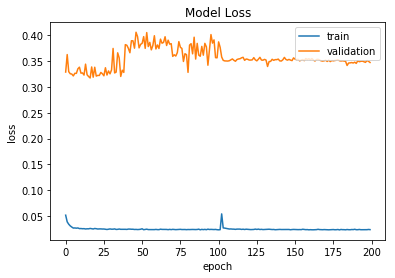

In [74]:
#Pruebas 32x32 matrices cortadas
print(history_15_32x32.history.keys())
f = plt.figure()
plt.plot(history_15_32x32.history['loss'])
plt.plot(history_15_32x32.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'val_coeff_determination', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'loss', 'coeff_determination', 'mean_absolute_percentage_error', 'mean_absolute_error'])


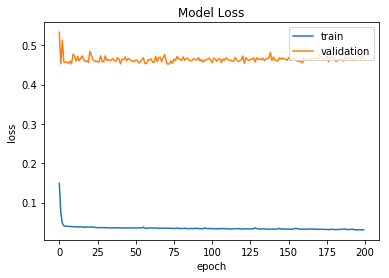

In [32]:
#Pruebas
print(history_15_32x32.history.keys())
f = plt.figure()
plt.plot(history_15_32x32.history['loss'])
plt.plot(history_15_32x32.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'val_coeff_determination', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'loss', 'coeff_determination', 'mean_absolute_percentage_error', 'mean_absolute_error'])


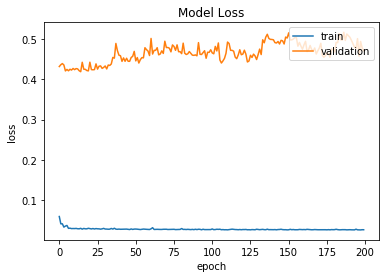

In [53]:
#Pruebas
print(history_15_32x32.history.keys())
f = plt.figure()
plt.plot(history_15_32x32.history['loss'])
plt.plot(history_15_32x32.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'val_coeff_determination', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'loss', 'coeff_determination', 'mean_absolute_percentage_error', 'mean_absolute_error'])


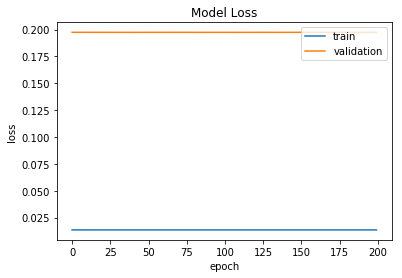

In [14]:
#Pruebas
print(history_1.history.keys())
f = plt.figure()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

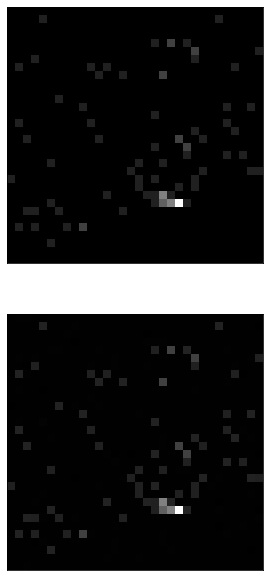

In [80]:
#Pruebas 32x32 matrices cortadas
n = 1
plt.figure(figsize=(16, 16))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(Y3c_test[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_grids[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

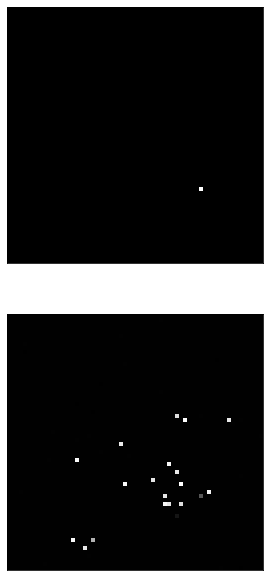

In [26]:
n = 1
plt.figure(figsize=(16, 16))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(Y3c_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_grids[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

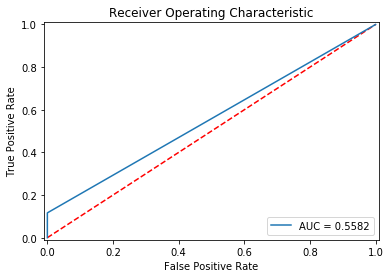

In [76]:
#Métrica
#Pruebas 32x32 matrices cortadas
f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, 'tab:blue', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.show()
#f.savefig('mx_roc.pdf', bbox_inches='tight')

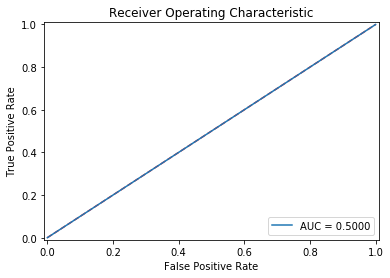

In [24]:
#Métrica
f = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, 'tab:blue', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.show()
#f.savefig('mx_roc.pdf', bbox_inches='tight')

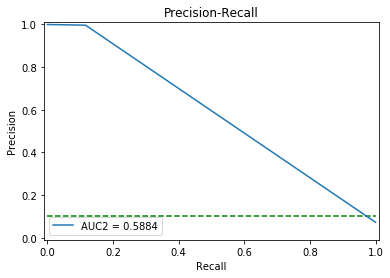

In [78]:
#Métrica
#Pruebas 32x32 matrices cortadas
f = plt.figure()
plt.title('Precision-Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.plot([0, 1], [0.1, 0.1],'g--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(recall, precision, 'tab:blue', label = 'AUC2 = %0.4f' % pr_auc)
plt.legend(loc = 'lower left')
plt.show()
#f.savefig('mx_pr.pdf', bbox_inches='tight')

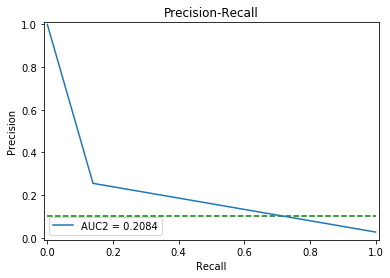

In [31]:
#Métrica
f = plt.figure()
plt.title('Precision-Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.plot([0, 1], [0.1, 0.1],'g--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(recall2, precision2, 'tab:blue', label = 'AUC2 = %0.4f' % pr_auc2)
plt.legend(loc = 'lower left')
plt.show()
#f.savefig('mx_pr.pdf', bbox_inches='tight')

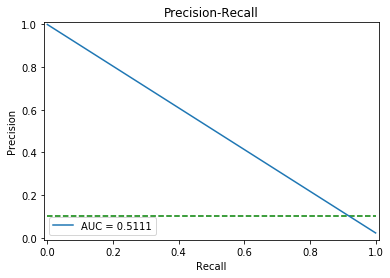

In [25]:
#Nueva
#Métrica
f = plt.figure()
plt.title('Precision-Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.plot([0, 1], [0.1, 0.1],'g--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(recall, precision, 'tab:blue', label = 'AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower left')
plt.show()
#f.savefig('mx_pr.pdf', bbox_inches='tight')

In [82]:
nstest = len(decoded_grids)
pixels = 32*32
list_prediction_pix = [[] for x in range(pixels)]
list_expected_pix = [[] for x in range(pixels)]
for i in range(nstest):
    for j in range(pixels):
        list_prediction_pix[j].append(decoded_grids[i][j])
        list_expected_pix[j].append(Y3c_test[i][j])

In [83]:
from sklearn.metrics import mean_squared_error
matrix_errors = np.zeros((pixels,), dtype=int)
for i in range(pixels):
    matrix_errors[i] = mean_squared_error(list_expected_pix[i], list_prediction_pix[i])
matrix_errors = np.array(matrix_errors).reshape(32,32)

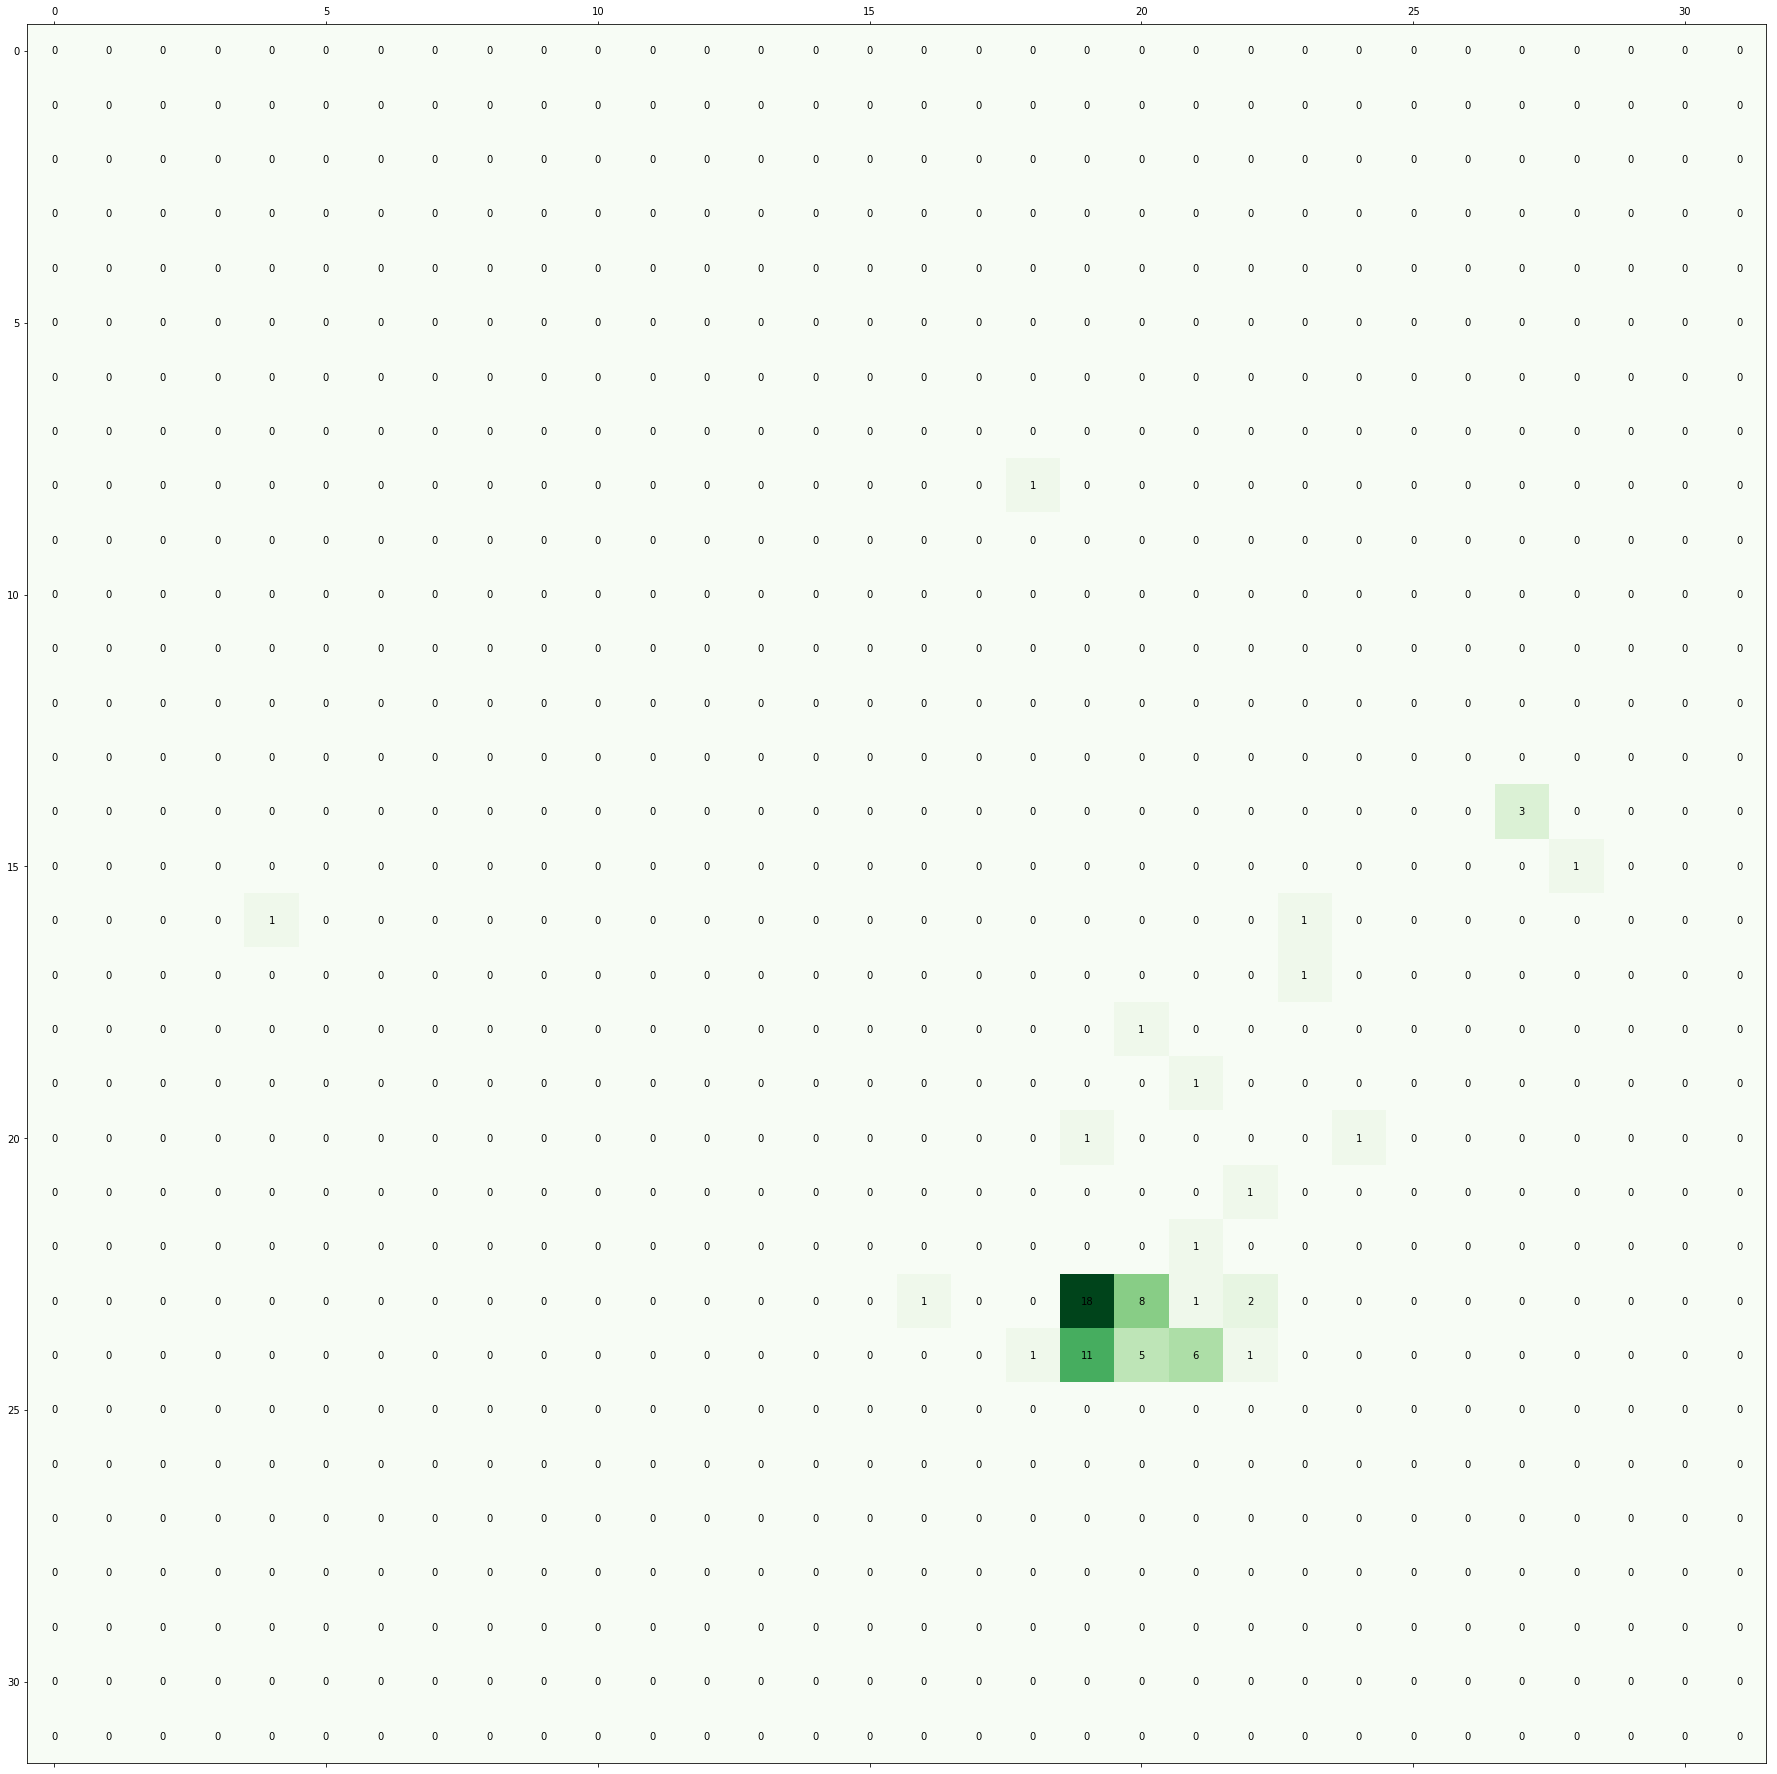

In [84]:
#Pruebas 32x32 matrices cortadas
rrc = 32
fig, ax = plt.subplots()
fig.set_figheight(rrc)
fig.set_figwidth(rrc)
ax.matshow(matrix_errors, cmap=plt.cm.Greens)

for i in range(rrc):
    for j in range(rrc):
        c = matrix_errors[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
fig.savefig('matrixoferrors32x32.pdf', bbox_inches='tight')

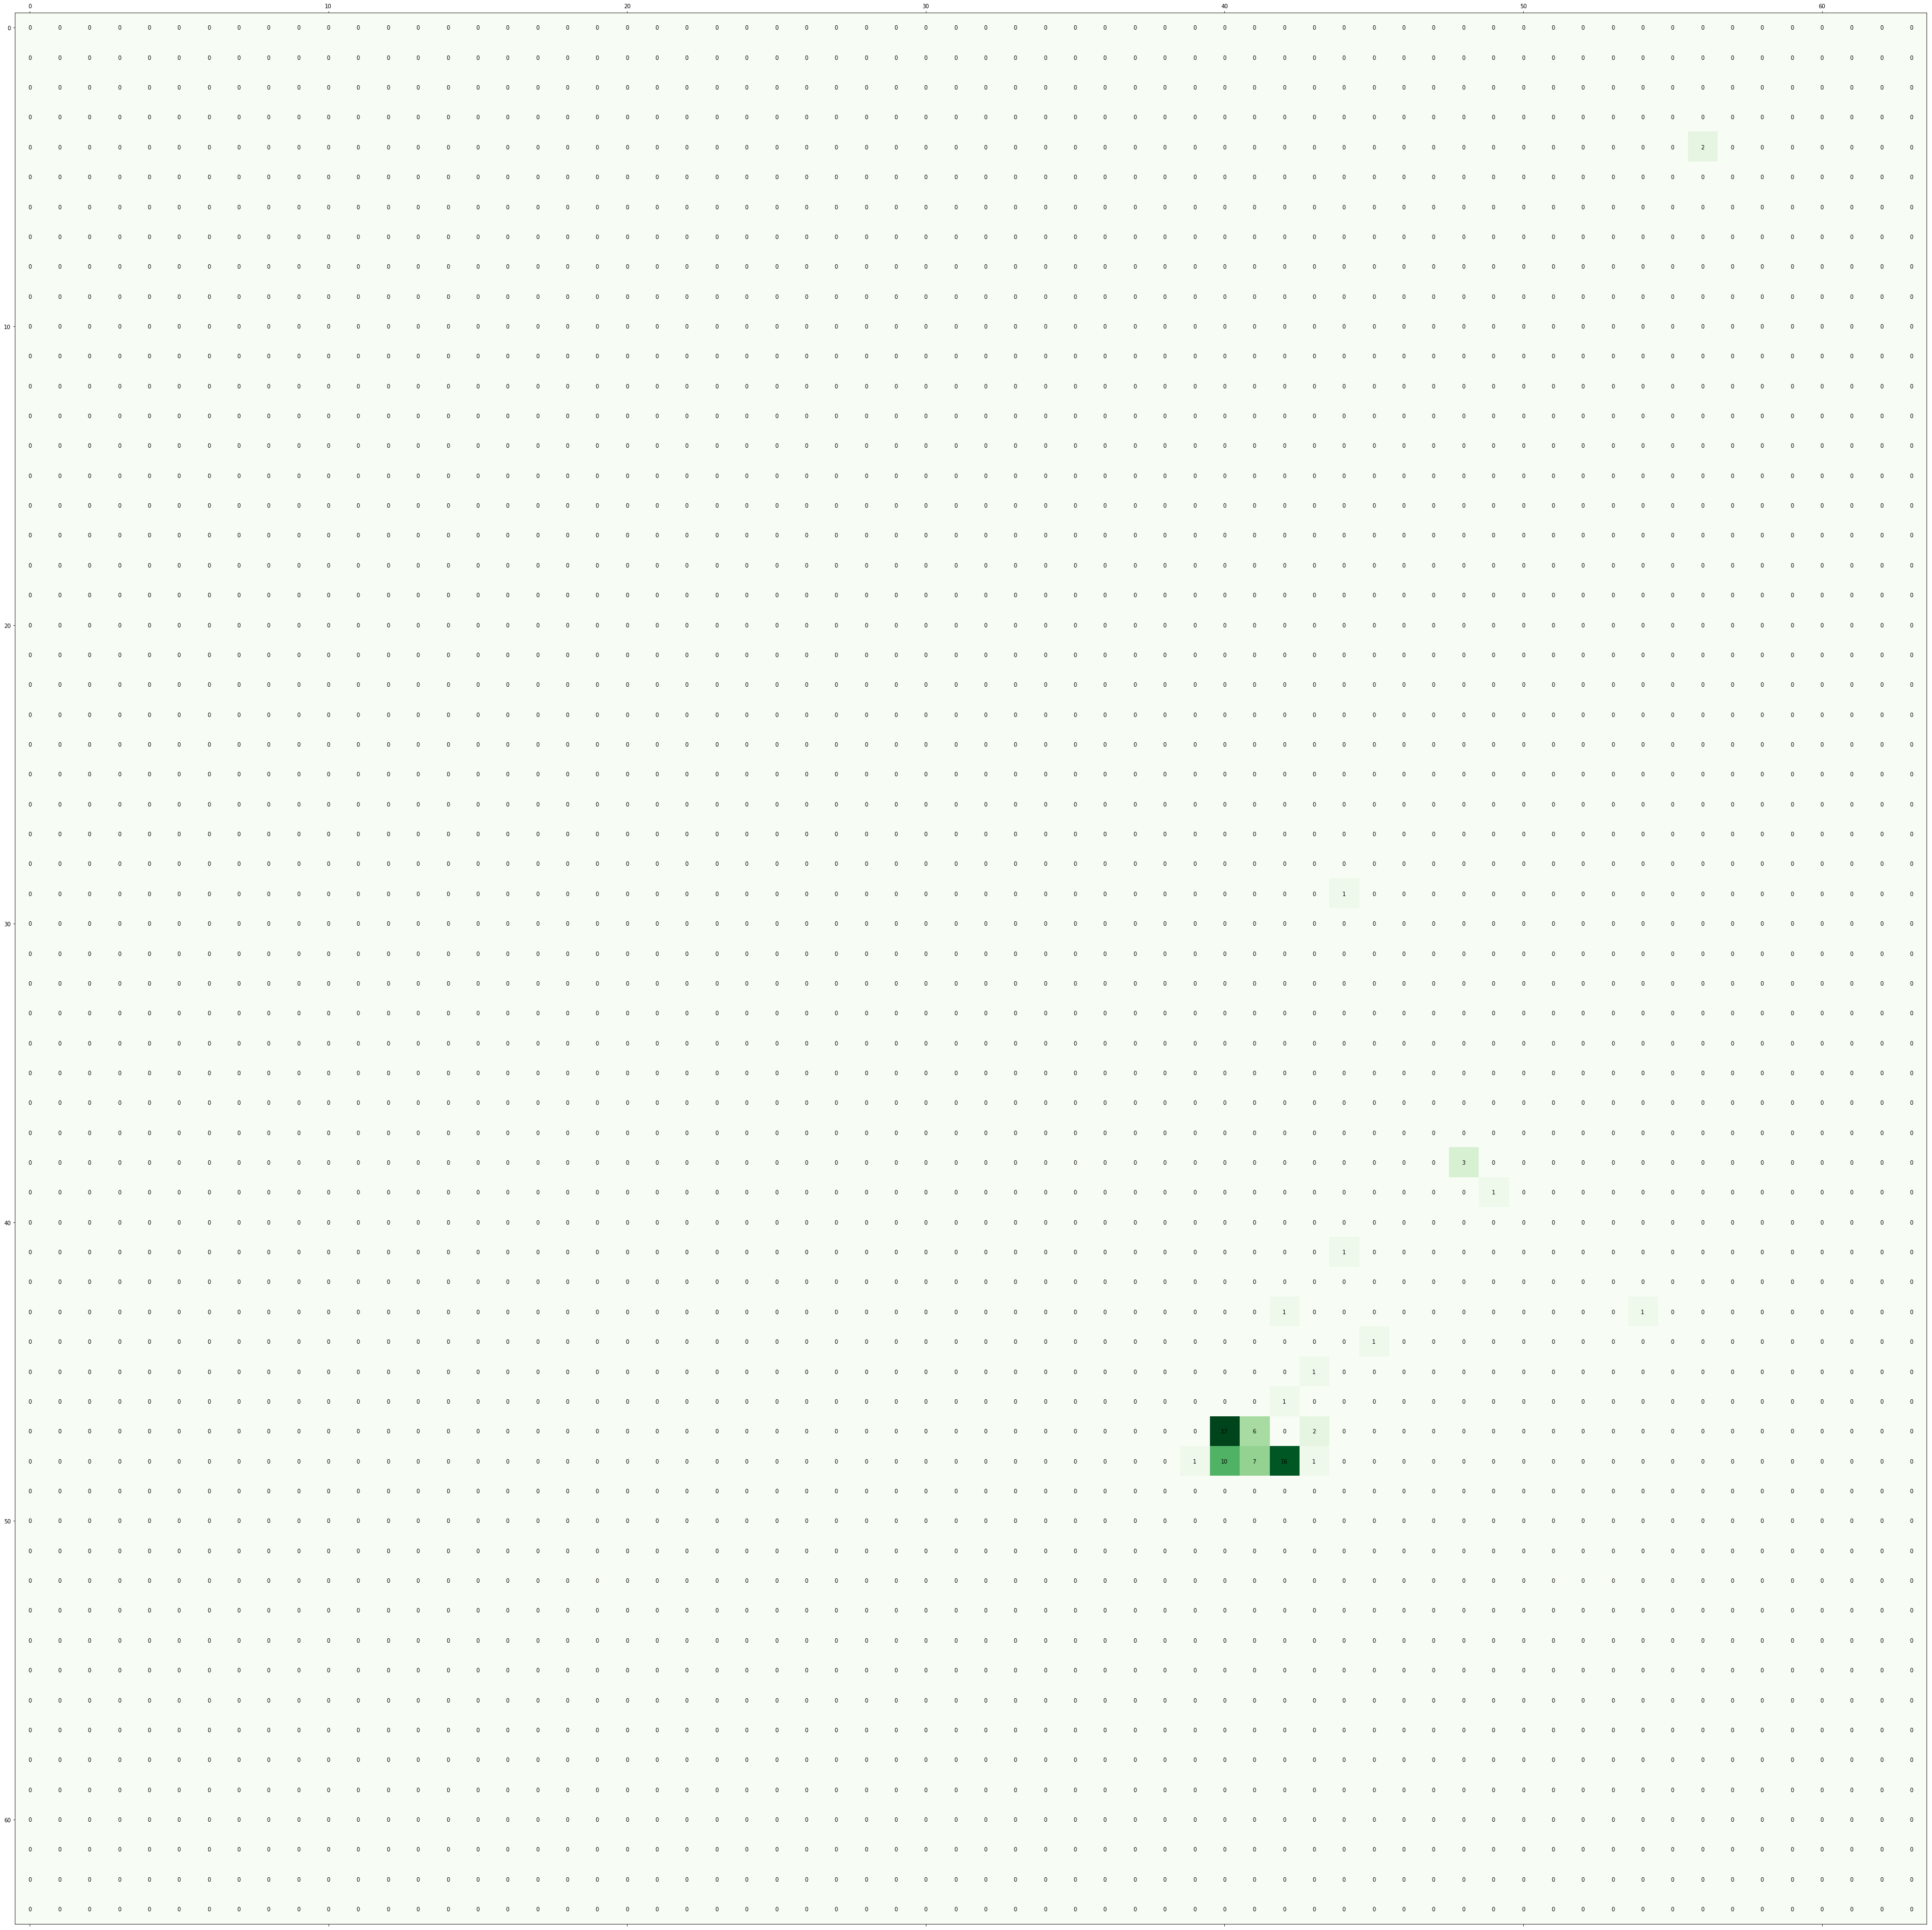

In [59]:
rrc = 64
fig, ax = plt.subplots()
fig.set_figheight(rrc)
fig.set_figwidth(rrc)
ax.matshow(matrix_errors, cmap=plt.cm.Greens)

for i in range(rrc):
    for j in range(rrc):
        c = matrix_errors[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
fig.savefig('matrixoferrors.pdf', bbox_inches='tight')